# Projet Séminaire Modélisation Statistique

Importations nécessaires:

In [1]:
library(readr)
library(readxl)
library(tidyr)
library(dplyr)
library(stringr)
library(purrr)
library(chron)
library(data.table)
library(zoo)

Warning message:
"le package 'readr' a été compilé avec la version R 4.1.3"
Warning message:
"le package 'tidyr' a été compilé avec la version R 4.1.3"
Warning message:
"le package 'dplyr' a été compilé avec la version R 4.1.3"

Attachement du package : 'dplyr'


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"le package 'chron' a été compilé avec la version R 4.1.3"

Attachement du package : 'data.table'


L'objet suivant est masqué depuis 'package:purrr':

    transpose


Les objets suivants sont masqués depuis 'package:dplyr':

    between, first, last



Attachement du package : 'zoo'


Les objets suivants sont masqués depuis 'package:base':

    as.Date, as.Date.numeric




In [2]:
#Set directory
setwd("C:/Users/Pauline/Documents/Github/Seminaire-Modelisation-Stat/Data")

### Ouverture et nettoyage des données

In [3]:
#Données originelles, non indicées
data_test <- read.csv("data_test.csv")
data_train <- read.csv("data_train.csv")
benchmark <- read.csv("benchmark.csv")
#Données qui serviront pour l'interpolation linéaire dans la partie Modélisation

In [4]:
#Suppression des données NA: on obtient des données de consommation toutes les 3h, bases de données indicées par 1
data_test_1 <- data_test %>% drop_na()
data_train_1 <- data_train %>% drop_na()
#Bases de données qui serviront pour la partie Statistiques Descriptives et la première partie de la Modélisation

In [5]:
#Base de données avec la consommation tous les demi-horaires, indicées par 0
data_train_0 <-  subset(data_train,select=c(DateTime,Consumption))
#Base de donnée qui servira pour la partie Statistiques Descriptives (saisonnalités)

On crée une colonne pour l'année, le mois, le jour, le jour de la semaine et l'heure.

In [6]:
data_train = data_train %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

data_test = data_test %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

data_train_0 = data_train_0 %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

data_train_1 = data_train_1 %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

data_test_1 = data_test_1 %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

benchmark = benchmark %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

In [7]:
data_train$Date = as.Date(data_train$Date, format = "%Y-%m-%d")
data_train["Weekday"] =  weekdays(data_train$Date)

data_test$Date = as.Date(data_test$Date, format = "%Y-%m-%d")
data_test["Weekday"] =  weekdays(data_test$Date)

data_train_0$Date = as.Date(data_train_0$Date, format = "%Y-%m-%d")
data_train_0["Weekday"] =  weekdays(data_train_0$Date)

data_train_1$Date = as.Date(data_train_1$Date, format = "%Y-%m-%d")
data_train_1["Weekday"] =  weekdays(data_train_1$Date)

data_test_1$Date = as.Date(data_test_1$Date, format = "%Y-%m-%d")
data_test_1["Weekday"] =  weekdays(data_test_1$Date)

benchmark$Date = as.Date(benchmark$Date, format = "%Y-%m-%d")
benchmark["Weekday"] =  weekdays(benchmark$Date)

##### Ajout jour férié

In [8]:
jours_feries <- read.csv("jours_feries_metropole.csv")

In [9]:
jours_feries$date = as.Date(jours_feries$date, format = "%Y-%m-%d")
jours_feries = jours_feries %>%
    filter(format(date, format = "%Y") > 2011) %>%
    select (-zone,-annee)

In [10]:
jours_feries = rename(jours_feries,Date=date)

In [11]:
data_train = left_join(data_train,jours_feries)

data_test = left_join(data_test,jours_feries)

data_train_0 = left_join(data_train_0,jours_feries)

data_train_1 = left_join(data_train_1,jours_feries)

data_test_1 = left_join(data_test_1,jours_feries)

Joining, by = "Date"
Joining, by = "Date"
Joining, by = "Date"
Joining, by = "Date"
Joining, by = "Date"


In [12]:
data_train$nom_jour_ferie[is.character(data_train$nom_jour_ferie) & is.na(data_train$nom_jour_ferie)] = 0
data_train = rename(data_train, jour_ferie = nom_jour_ferie)

data_test$nom_jour_ferie[is.character(data_test$nom_jour_ferie) & is.na(data_test$nom_jour_ferie)] = 0
data_test = rename(data_test, jour_ferie = nom_jour_ferie)

data_train_0$nom_jour_ferie[is.character(data_train_0$nom_jour_ferie) & is.na(data_train_0$nom_jour_ferie)] = 0
data_train_0 = rename(data_train_0, jour_ferie = nom_jour_ferie)

data_train_1$nom_jour_ferie[is.character(data_train_1$nom_jour_ferie) & is.na(data_train_1$nom_jour_ferie)] = 0
data_train_1 = rename(data_train_1, jour_ferie = nom_jour_ferie)

data_test_1$nom_jour_ferie[is.character(data_test_1$nom_jour_ferie) & is.na(data_test_1$nom_jour_ferie)] = 0
data_test_1 = rename(data_test_1, jour_ferie = nom_jour_ferie)

##### Ajout vacances scolaires

In [16]:
holidays <- read.csv("data_holidays.csv")

In [17]:
holidays$date = as.Date(holidays$date, format = "%Y-%m-%d")
holidays = holidays %>%
    filter(format(date, format = "%Y") > 2011) %>%
    select (-nom_vacances)

In [18]:
holidays = rename(holidays,Date=date)
holidays = rename(holidays,Holidays_A=vacances_zone_a)
holidays = rename(holidays,Holidays_B=vacances_zone_b)
holidays = rename(holidays,Holidays_C=vacances_zone_c)

In [19]:
data_train = left_join(data_train,holidays,"Date")

data_test = left_join(data_test,holidays,"Date")

data_train_0 = left_join(data_train_0,holidays,"Date")

data_train_1 = left_join(data_train_1,holidays,"Date")

data_test_1 = left_join(data_test_1,holidays,"Date")

In [20]:
data_train$Holidays_A <- as.integer(as.logical(data_train$Holidays_A))
data_train$Holidays_B <- as.integer(as.logical(data_train$Holidays_B))
data_train$Holidays_C <- as.integer(as.logical(data_train$Holidays_C))

data_test$Holidays_A <- as.integer(as.logical(data_test$Holidays_A))
data_test$Holidays_B <- as.integer(as.logical(data_test$Holidays_B))
data_test$Holidays_C <- as.integer(as.logical(data_test$Holidays_C))

data_train_0$Holidays_A <- as.integer(as.logical(data_train_0$Holidays_A))
data_train_0$Holidays_B <- as.integer(as.logical(data_train_0$Holidays_B))
data_train_0$Holidays_C <- as.integer(as.logical(data_train_0$Holidays_C))

data_train_1$Holidays_A <- as.integer(as.logical(data_train_1$Holidays_A))
data_train_1$Holidays_B <- as.integer(as.logical(data_train_1$Holidays_B))
data_train_1$Holidays_C <- as.integer(as.logical(data_train_1$Holidays_C))

data_test_1$Holidays_A <- as.integer(as.logical(data_test_1$Holidays_A))
data_test_1$Holidays_B <- as.integer(as.logical(data_test_1$Holidays_B))
data_test_1$Holidays_C <- as.integer(as.logical(data_test_1$Holidays_C))

In [21]:
data_train$Holidays <- 0
data_train$Holidays[data_train$Holidays_A==1 | data_train$Holidays_B==1 | data_train$Holidays_B==1] <- 1

data_test$Holidays <- 0
data_test$Holidays[data_test$Holidays_A==1 | data_test$Holidays_B==1 | data_test$Holidays_B==1] <- 1

data_train_0$Holidays <- 0
data_train_0$Holidays[data_train_0$Holidays_A==1 | data_train_0$Holidays_B==1 | data_train_0$Holidays_B==1] <- 1

data_train_1$Holidays <- 0
data_train_1$Holidays[data_train_1$Holidays_A==1 | data_train_1$Holidays_B==1 | data_train_1$Holidays_B==1] <- 1

data_test_1$Holidays <- 0
data_test_1$Holidays[data_test_1$Holidays_A==1 | data_test_1$Holidays_B==1 | data_test_1$Holidays_B==1] <- 1

### Statistiques Descriptives

In [19]:
library(ggplot2)
library(ggthemes)
library(repr)

Warning message:
"le package 'repr' a été compilé avec la version R 4.1.3"


In [20]:
summary(data_train_1)

      Date                Year              Month               Day           
 Min.   :2012-01-01   Length:26286       Length:26286       Length:26286      
 1st Qu.:2014-04-01   Class :character   Class :character   Class :character  
 Median :2016-06-30   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2016-07-01                                                           
 3rd Qu.:2018-10-01                                                           
 Max.   :2020-12-31                                                           
     Time            Consumption     Temperature       Nebulosity     
 Length:26286       Min.   :29482   Min.   :-0.366   Min.   :  7.667  
 Class :character   1st Qu.:44984   1st Qu.:11.207   1st Qu.: 68.000  
 Mode  :character   Median :52366   Median :14.523   Median : 80.588  
                    Mean   :54075   Mean   :14.876   Mean   : 76.117  
                    3rd Qu.:62286   3rd Qu.:18.203   3rd Qu.: 88.409  
                    M

##### Etude de la Température

`geom_smooth()` using formula 'y ~ x'



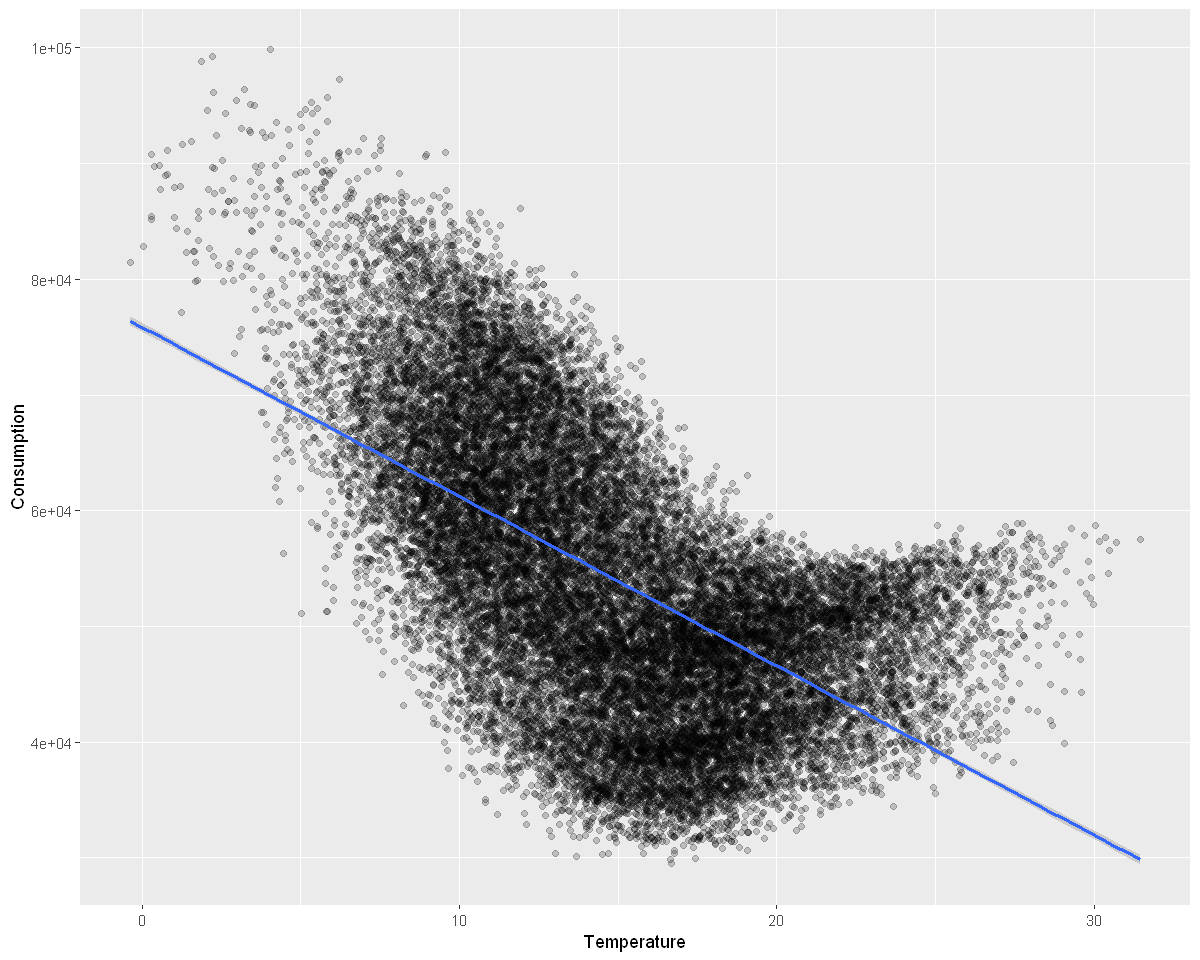

In [71]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train_1, aes(x = Temperature, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")
#Corrélation clairement négative entre la Température et la Consommation

In [75]:
#Normalisation des données
data_train_1$Temperature_normalized <- (data_train_1$Temperature - mean(data_train_1$Temperature)) / sd(data_train_1$Temperature)
data_train_1$Consumption_normalized <- (data_train_1$Consumption - mean(data_train_1$Consumption)) / sd(data_train_1$Consumption)
data_train_1$Nebulosity_normalized <- (data_train_1$Nebulosity - mean(data_train_1$Nebulosity)) / sd(data_train_1$Nebulosity)
data_train_1$Humidity_normalized <- (data_train_1$Humidity - mean(data_train_1$Humidity)) / sd(data_train_1$Humidity)

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): objet 'Date' introuvable

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(print(o

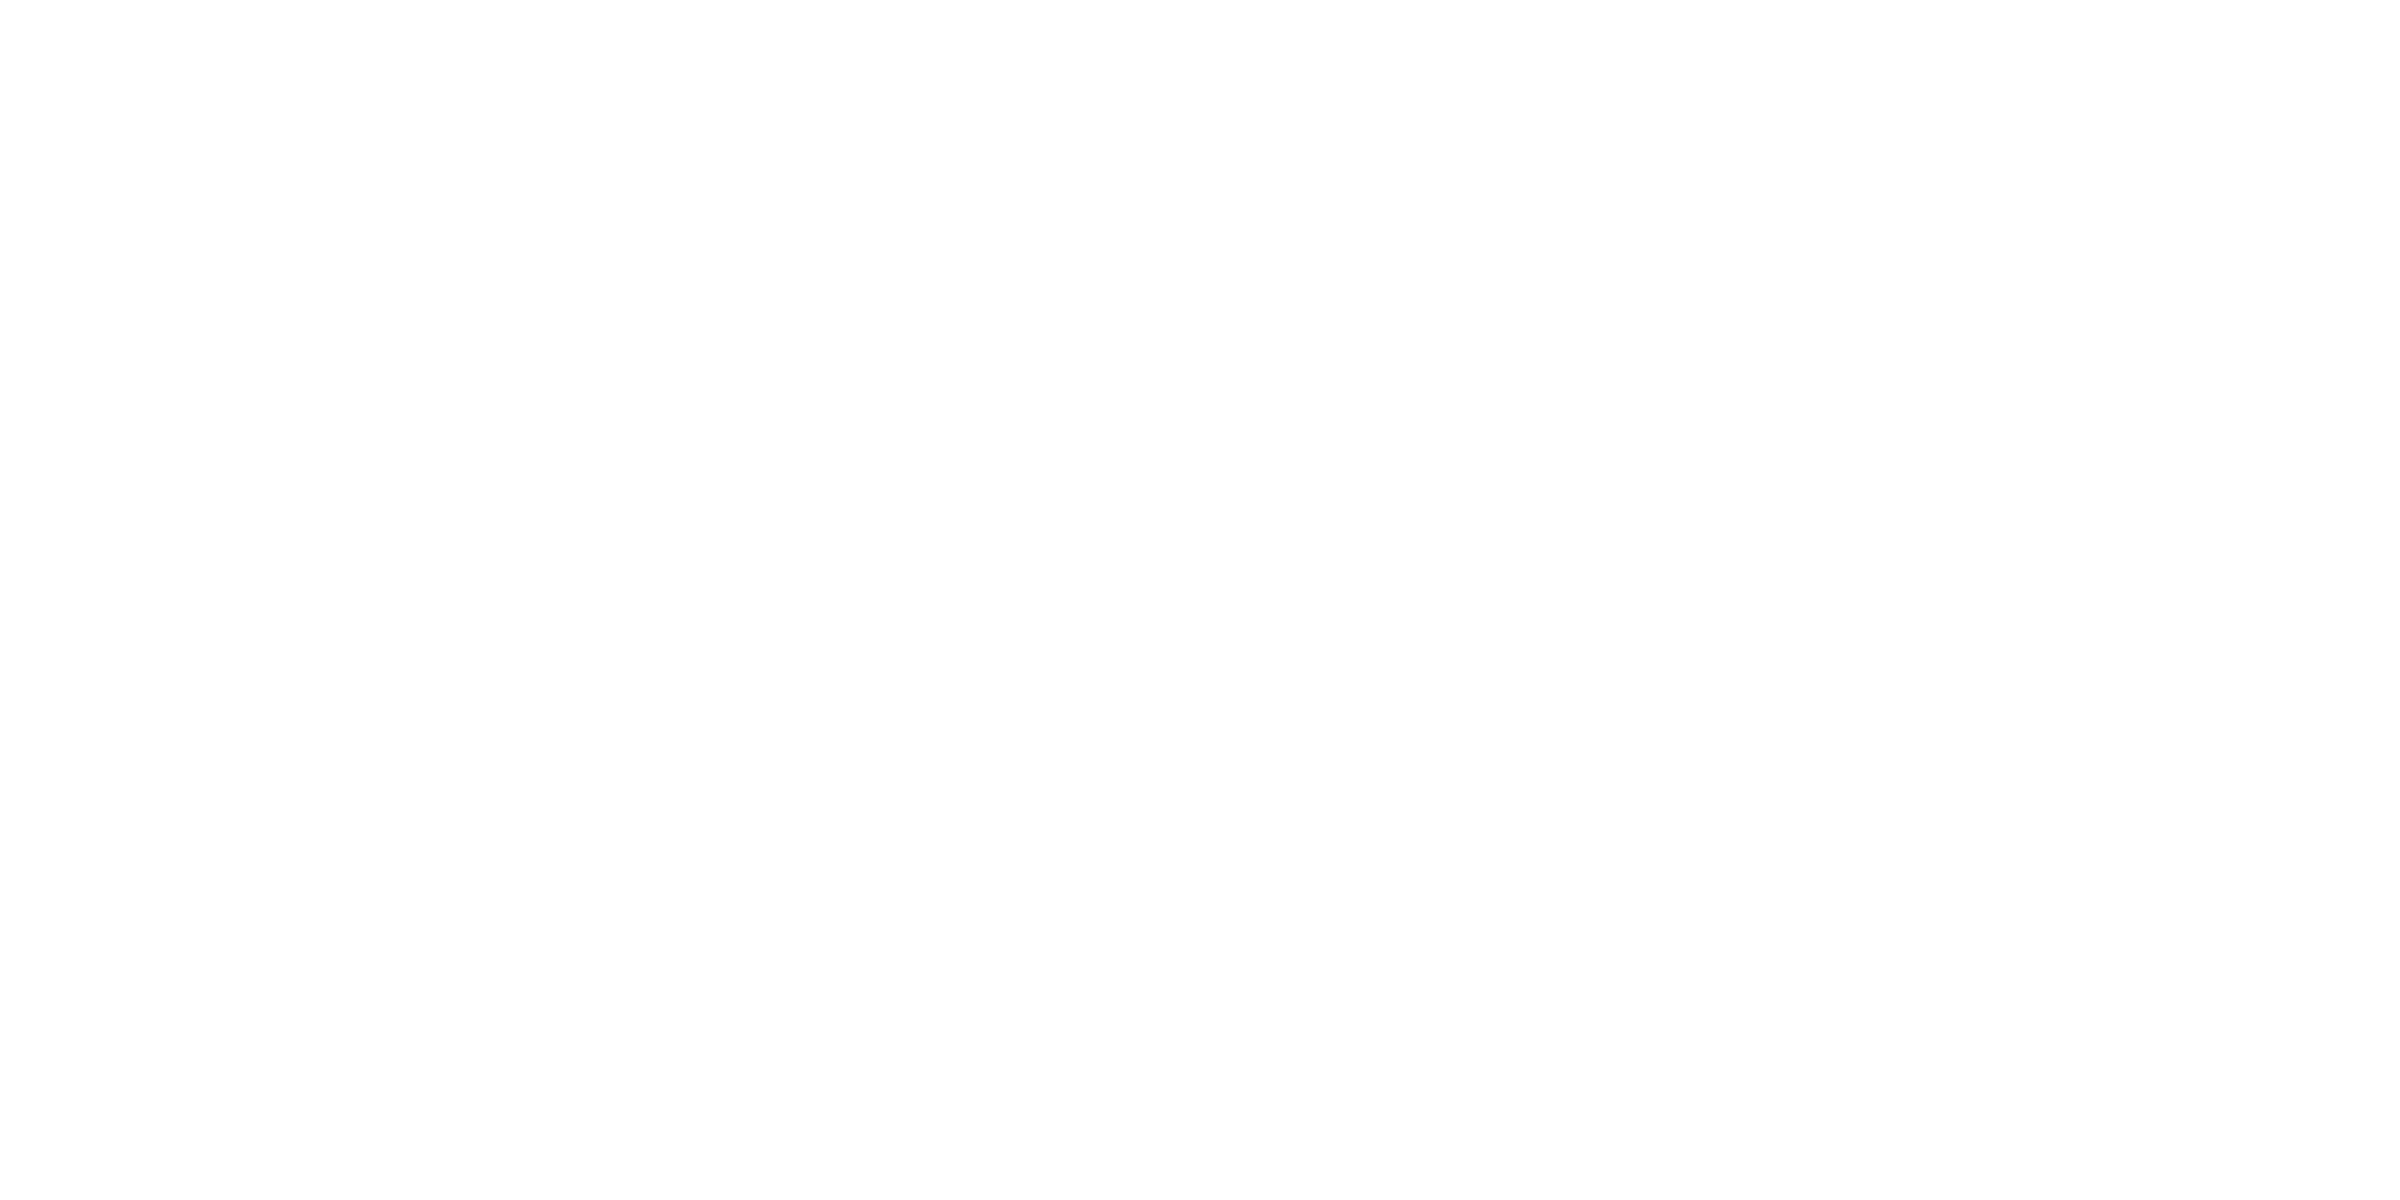

In [45]:
#Etude de l'évolution temporelle Température-Consommation entre 2012 et 2020
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Temperature')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consumption')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle de la Température et de la Consommation Electrique entre 2012 et 2020") +
    ylab("Consommation et Température")

In [24]:
#Etude sur une année en particulier
data_train_2012 <- subset(data_train_1, Year == 2012)

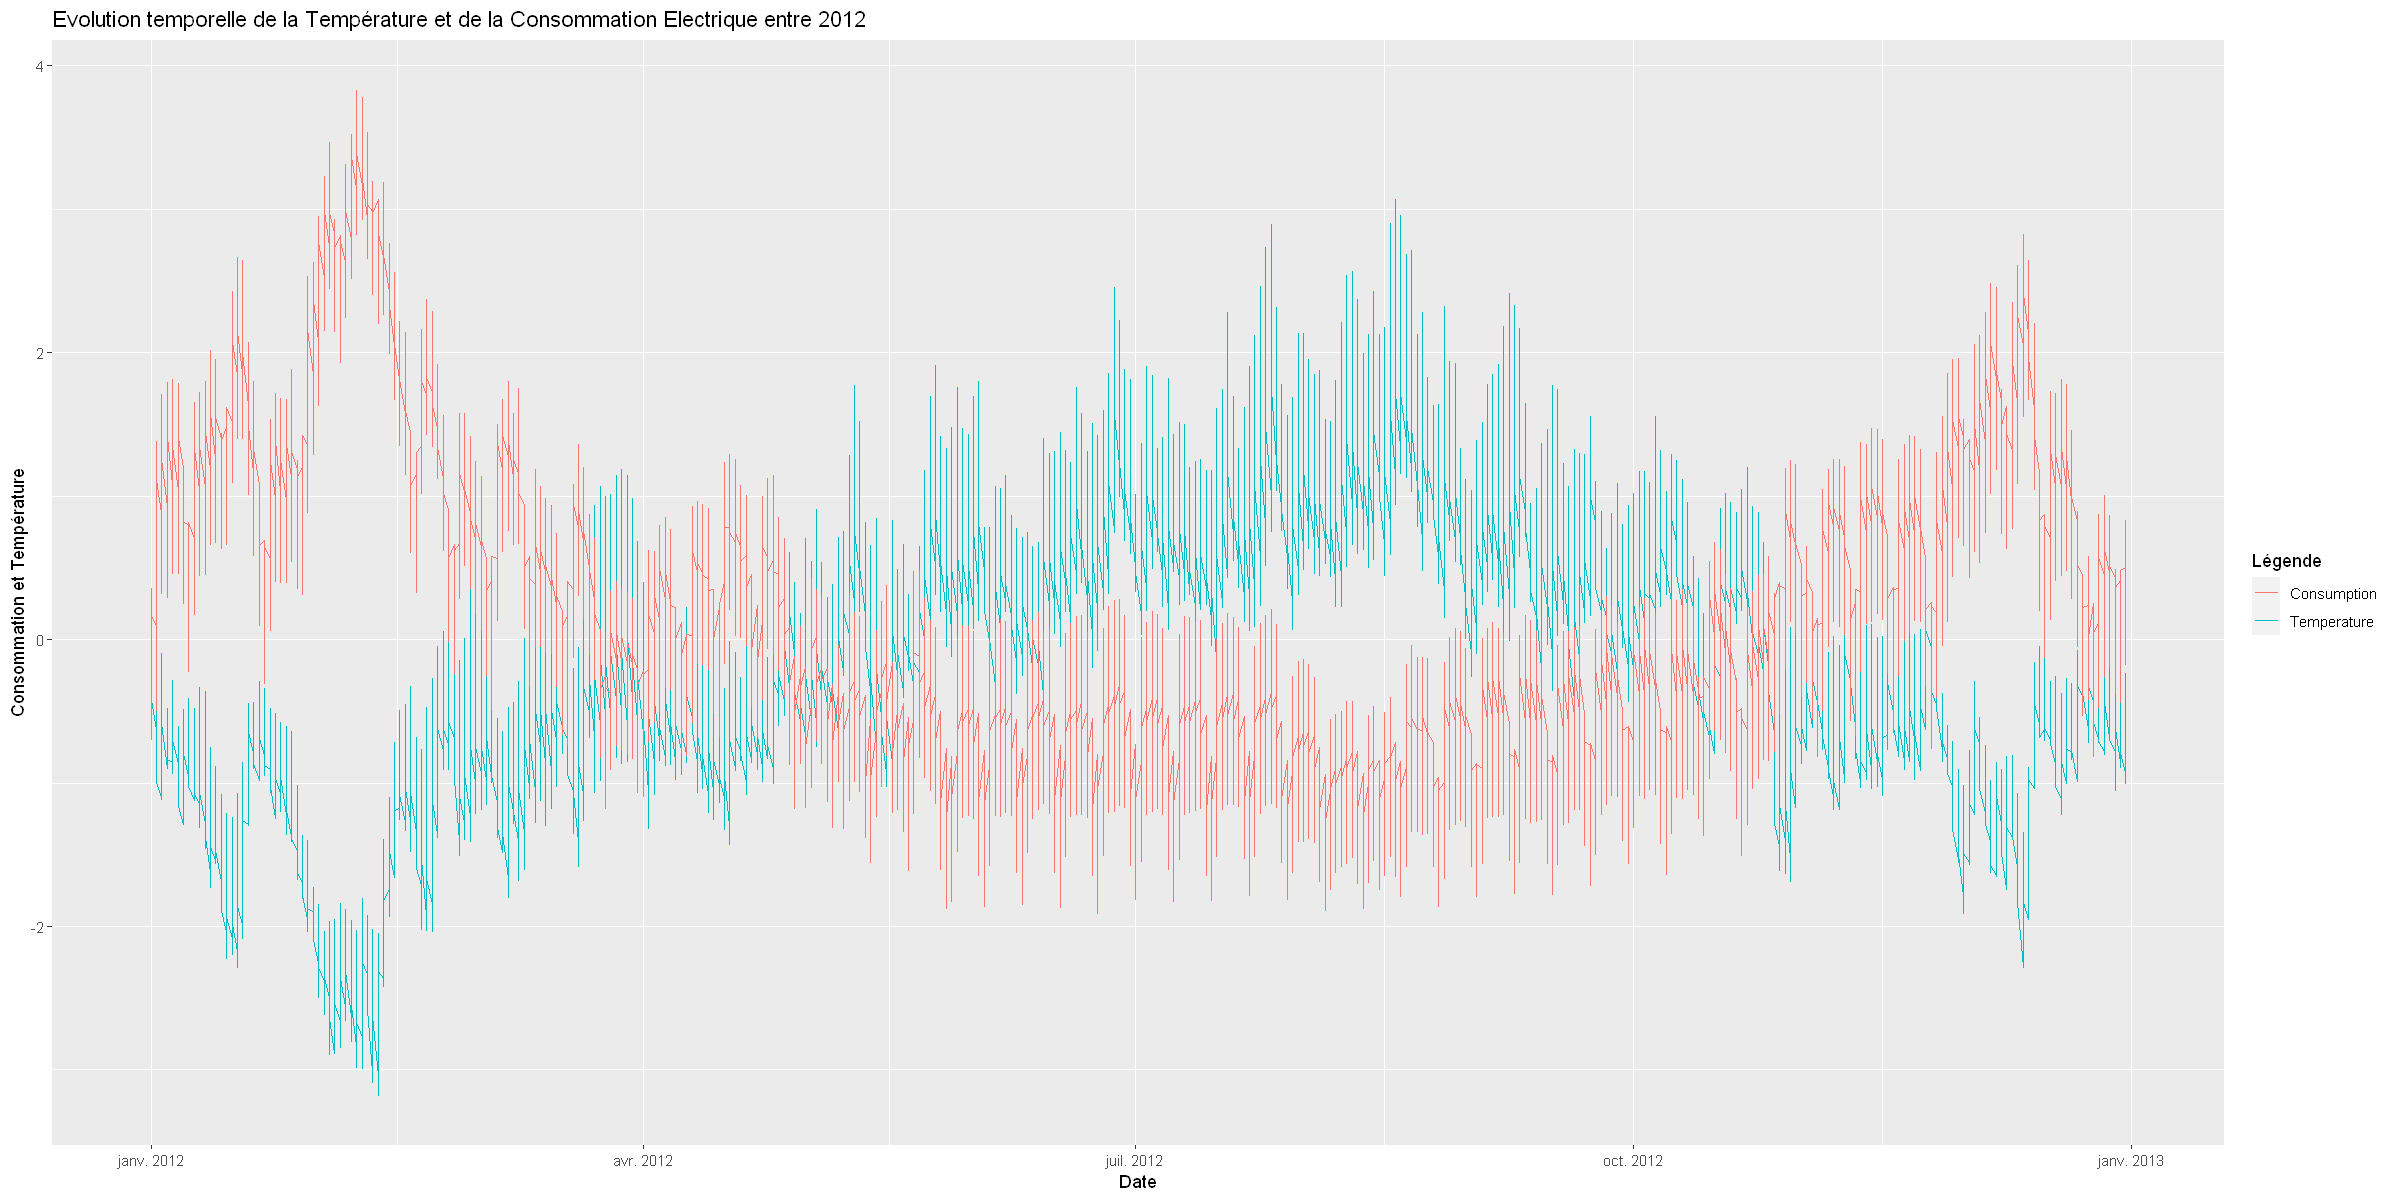

In [25]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_2012, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Temperature')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consumption')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle de la Température et de la Consommation Electrique entre 2012") +
    ylab("Consommation et Température")

In [26]:
#Construction d'une base annuelle "type": moyenne de la consommation à chaque période observée sur 9 ans
data_train_1_type <- data_train_1 %>%
   group_by(Month, Day, Time) %>% 
   summarise_at(vars("Consumption", "Temperature", "Nebulosity", "Humidity"), mean)

In [27]:
data_train_1_type$Date = paste(data_train_1_type$Month, data_train_1_type$Day, sep="-")
data_train_1_type$Date = as.Date(data_train_1_type$Date, format = "%m-%d")
data_train_1_type <- data_train_1_type %>% select(Date, everything())
data_train_1_type <- data_train_1_type %>% drop_na()

In [28]:
data_train_1_type$Temperature_normalized <- (data_train_1_type$Temperature - mean(data_train_1_type$Temperature)) / sd(data_train_1_type$Temperature)
data_train_1_type$Consumption_normalized <- (data_train_1_type$Consumption - mean(data_train_1_type$Consumption)) / sd(data_train_1_type$Consumption)
data_train_1_type$Nebulosity_normalized <- (data_train_1_type$Nebulosity - mean(data_train_1_type$Nebulosity)) / sd(data_train_1_type$Nebulosity)
data_train_1_type$Humidity_normalized <- (data_train_1_type$Humidity - mean(data_train_1_type$Humidity)) / sd(data_train_1_type$Humidity)

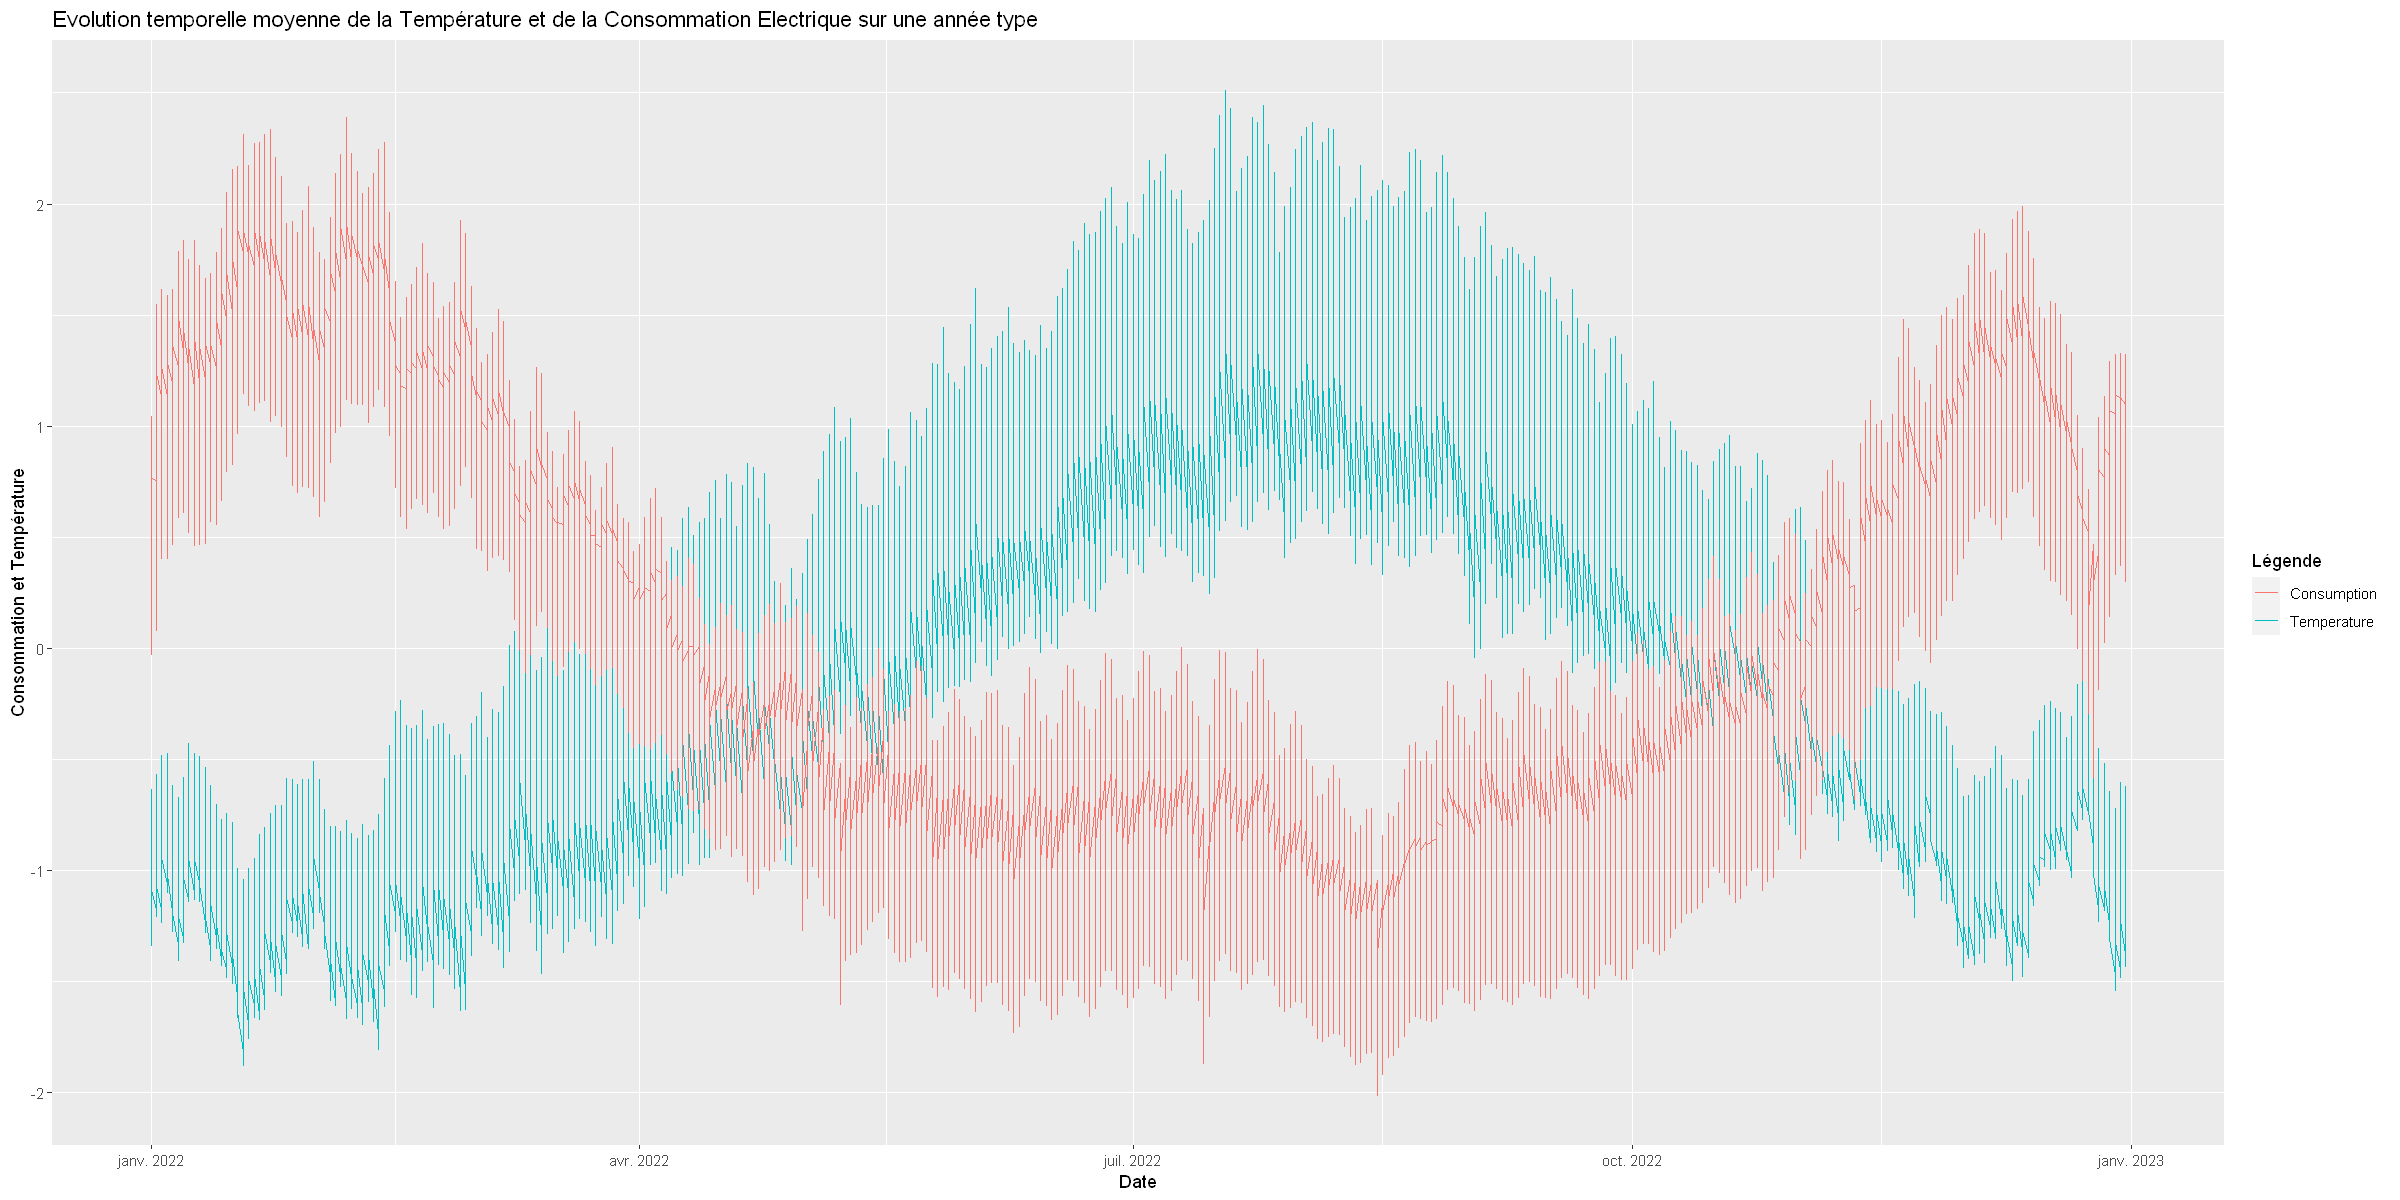

In [29]:
#Etude sur une année "type"
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1_type, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Temperature')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consumption')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Température et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Température")

In [30]:
#Aggrégation par jour pour avoir un graphique plus "aéré" (sans Time)
data_train_1_type_notime <- data_train_1_type %>%
   group_by(Date) %>% 
   summarise_at(vars("Consumption", "Temperature", "Nebulosity", "Humidity"), mean)

In [31]:
data_train_1_type_notime$Temperature_normalized <- (data_train_1_type_notime$Temperature - mean(data_train_1_type_notime$Temperature)) / sd(data_train_1_type_notime$Temperature)
data_train_1_type_notime$Consumption_normalized <- (data_train_1_type_notime$Consumption - mean(data_train_1_type_notime$Consumption)) / sd(data_train_1_type_notime$Consumption)
data_train_1_type_notime$Nebulosity_normalized <- (data_train_1_type_notime$Nebulosity - mean(data_train_1_type_notime$Nebulosity)) / sd(data_train_1_type_notime$Nebulosity)
data_train_1_type_notime$Humidity_normalized <- (data_train_1_type_notime$Humidity - mean(data_train_1_type_notime$Humidity)) / sd(data_train_1_type_notime$Humidity)

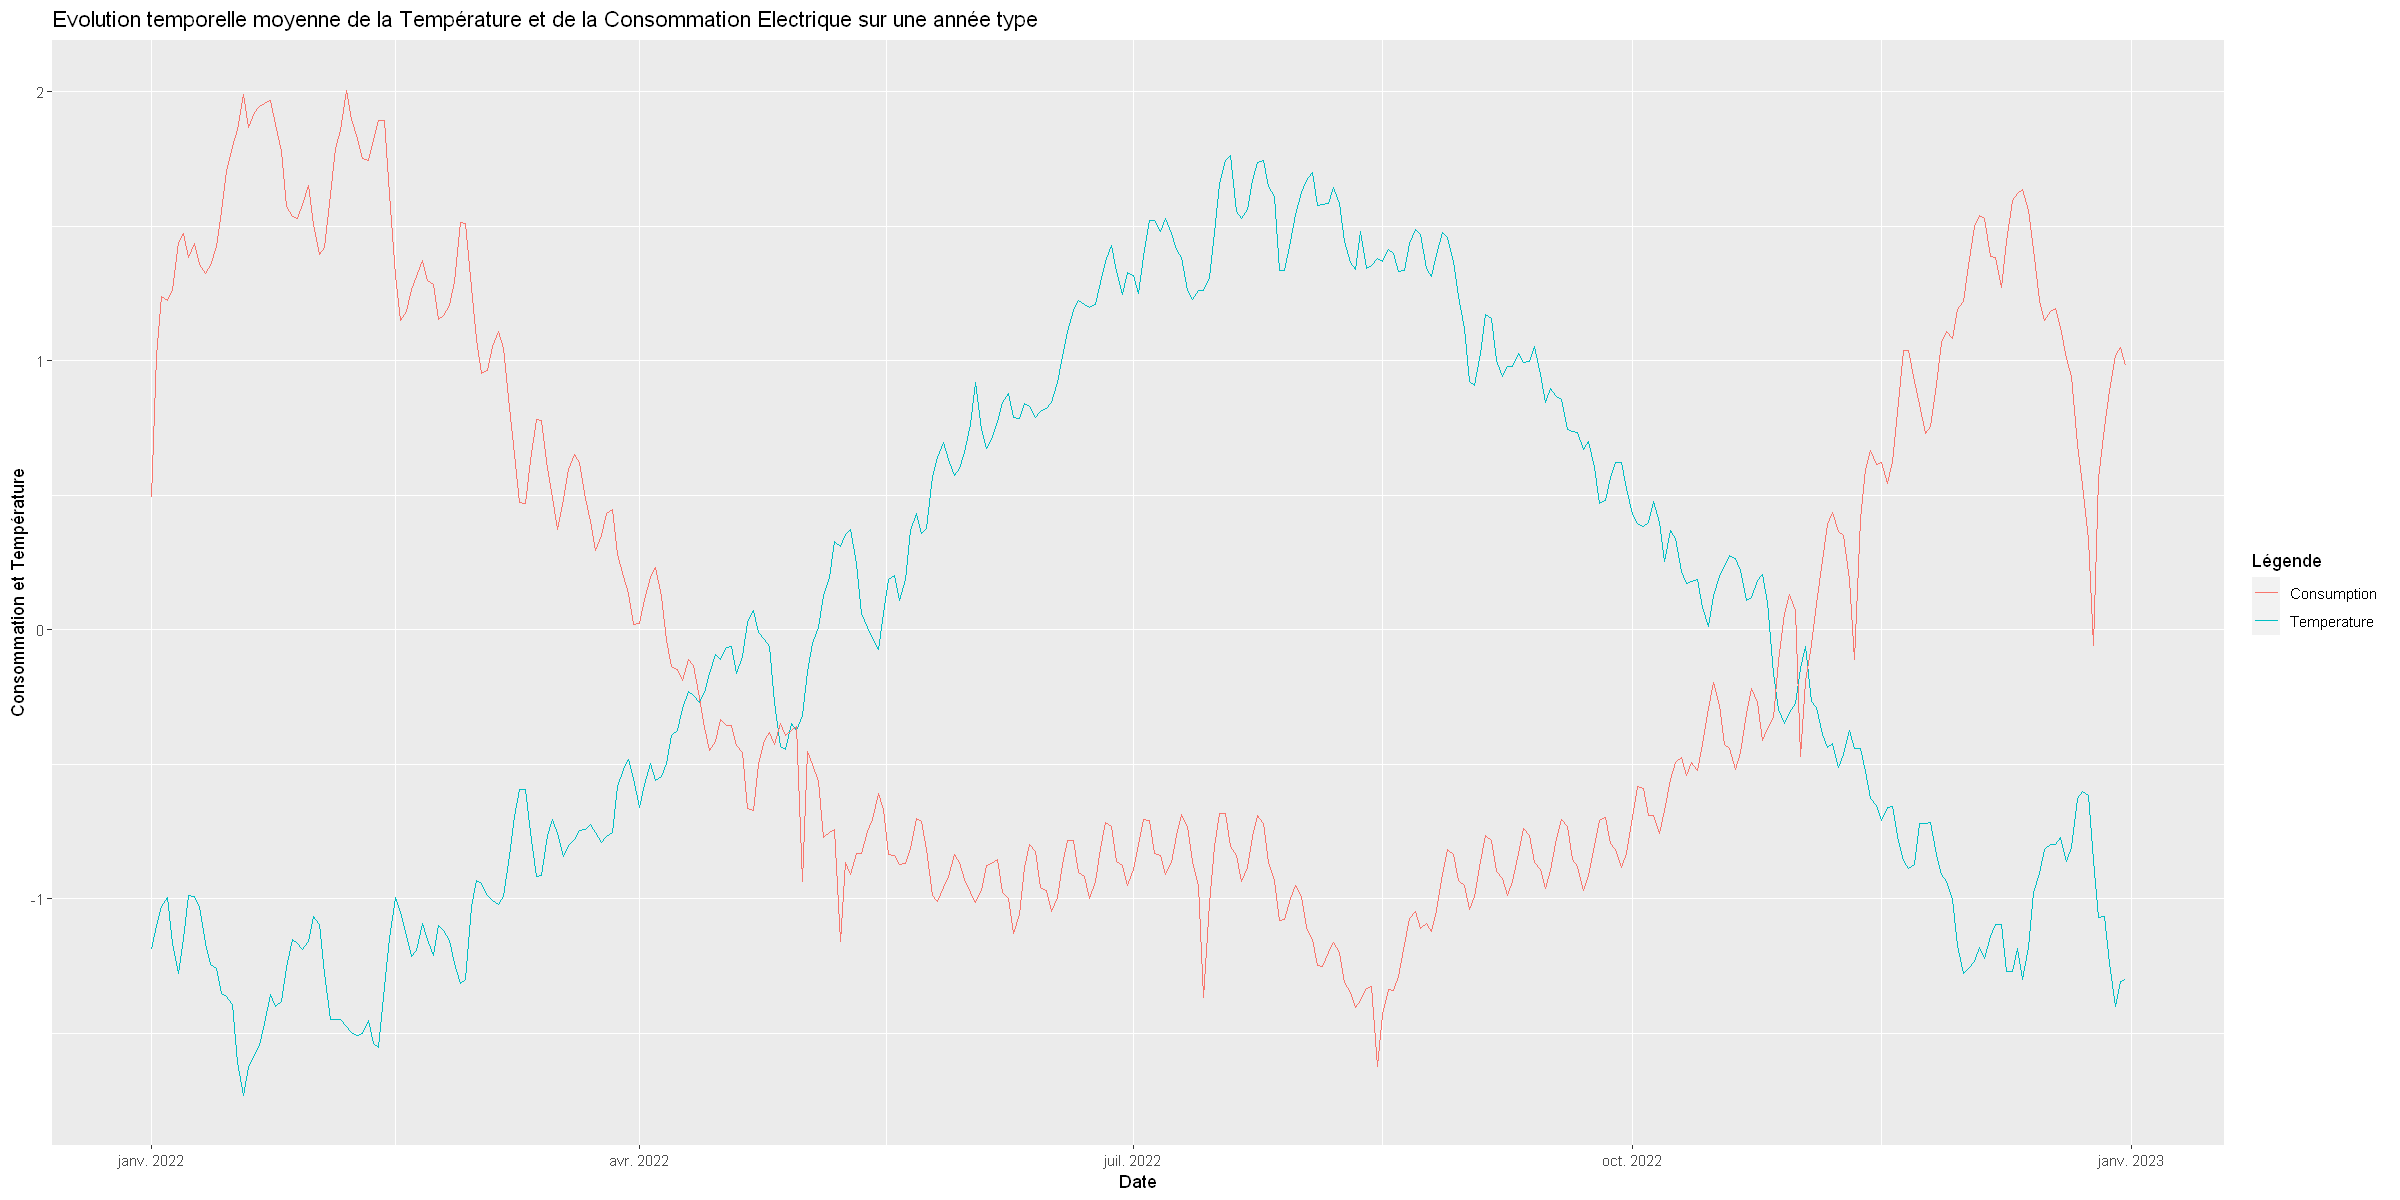

In [32]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1_type_notime, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Temperature')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consumption')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Température et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Température")

Nous constatons clairement à travers notre corrélogramme et nos différents graphiques, que la corrélation entre la température et la consommation électrique est négative. Ces 2 variables ont une évolution temporelle antagoniste sur l'année.

##### Etude de la Nébulosité 

`geom_smooth()` using formula 'y ~ x'



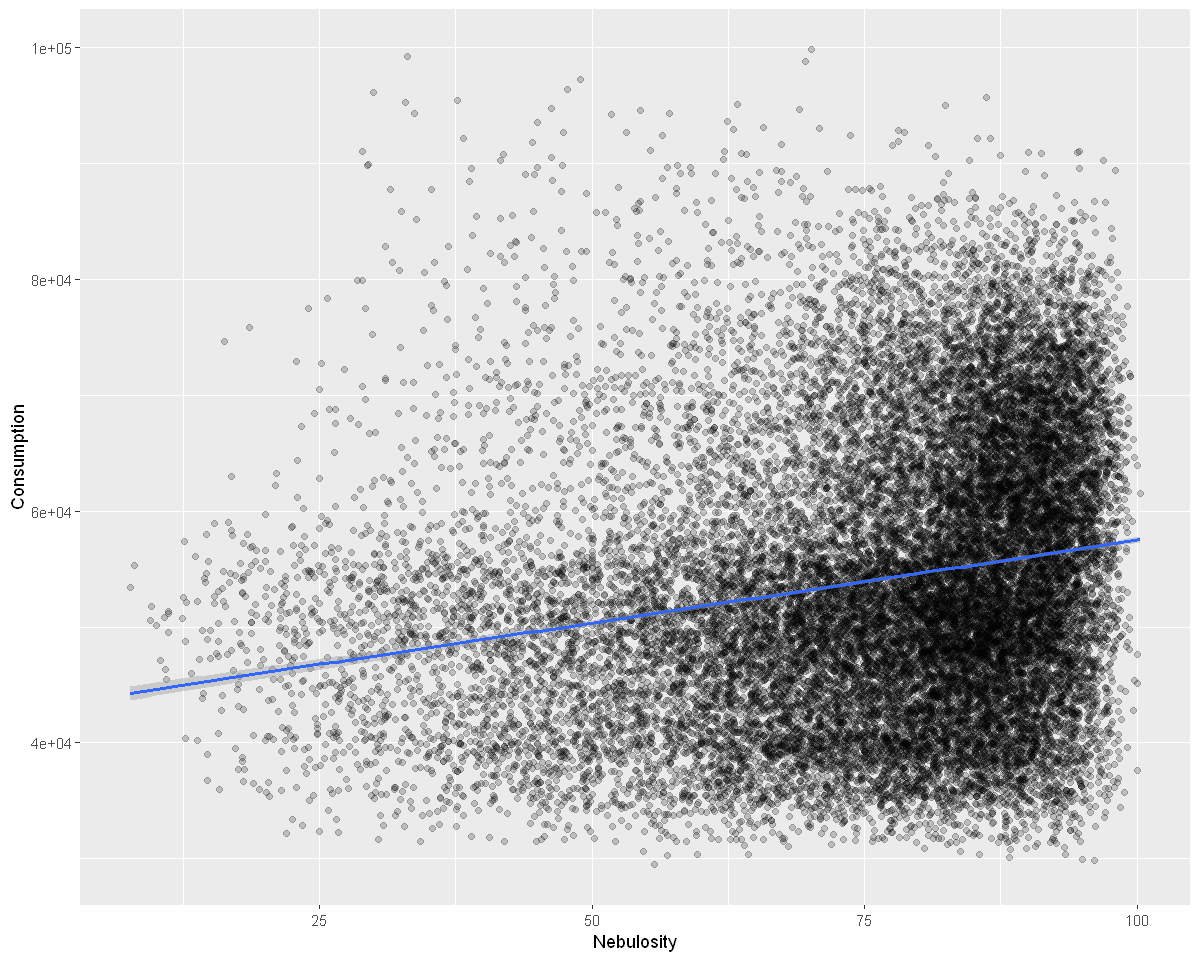

In [33]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train_1, aes(x = Nebulosity, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")
#Corrélation positive

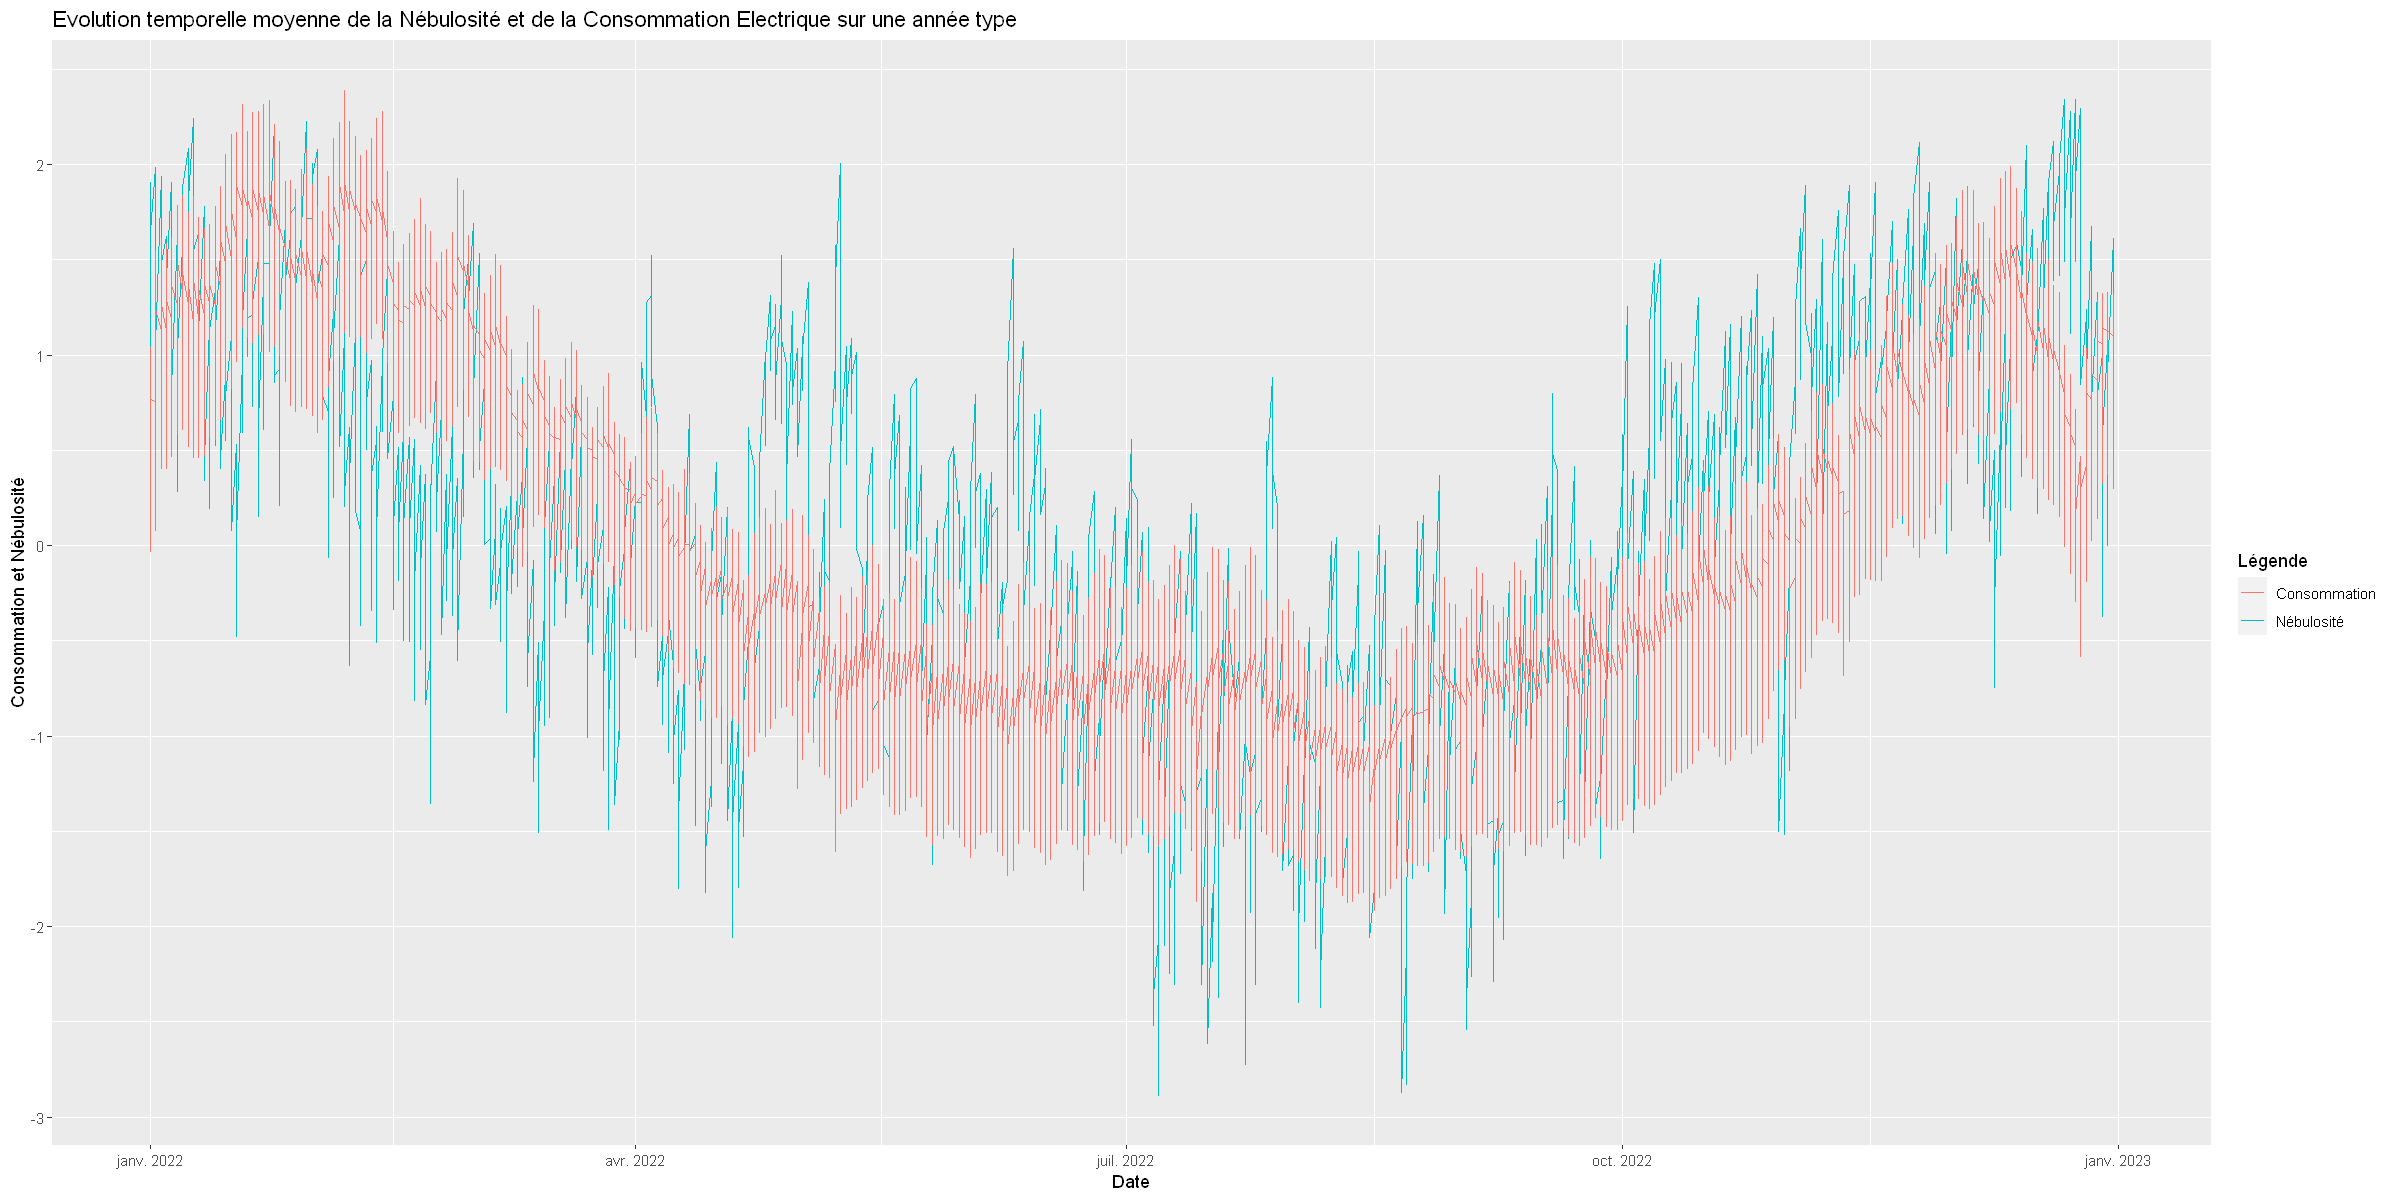

In [34]:
#Etude sur notre année type
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1_type, aes(x=Date, y=Nebulosity_normalized, group = 1, color = 'Nébulosité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Nébulosité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Nébulosité")

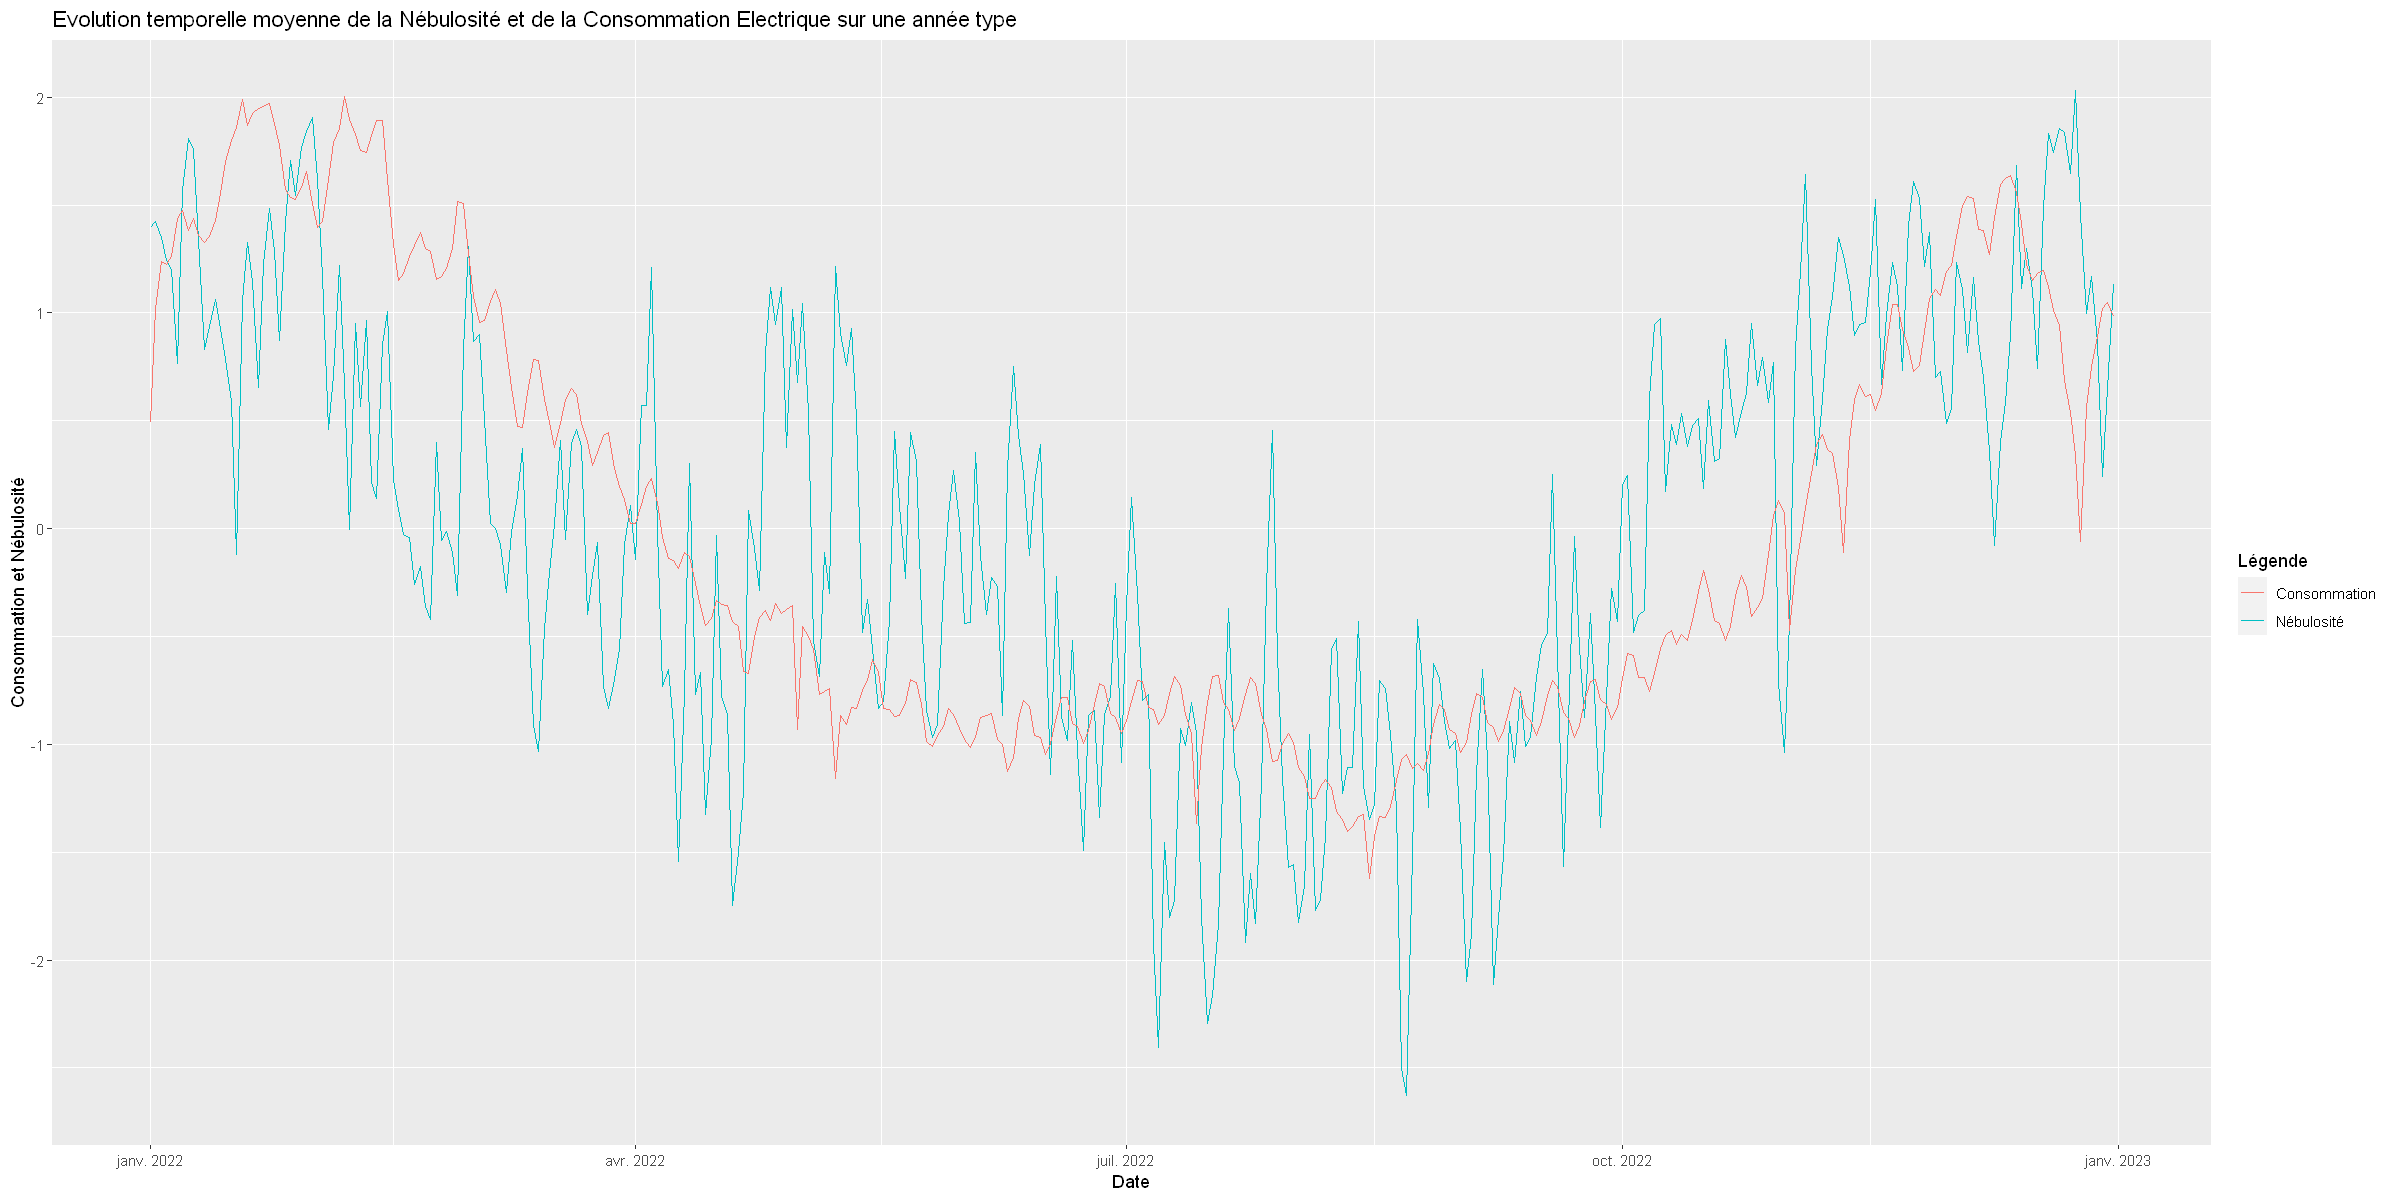

In [35]:
#Etude sur notre année type, sans Time
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1_type_notime, aes(x=Date, y=Nebulosity_normalized, group = 1, color = 'Nébulosité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Nébulosité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Nébulosité")

La nébulosité et la consommation électrique semblent avoir une corrélation positive et partager une même trajectoire temporelle

##### Etude de l'Humidité

`geom_smooth()` using formula 'y ~ x'



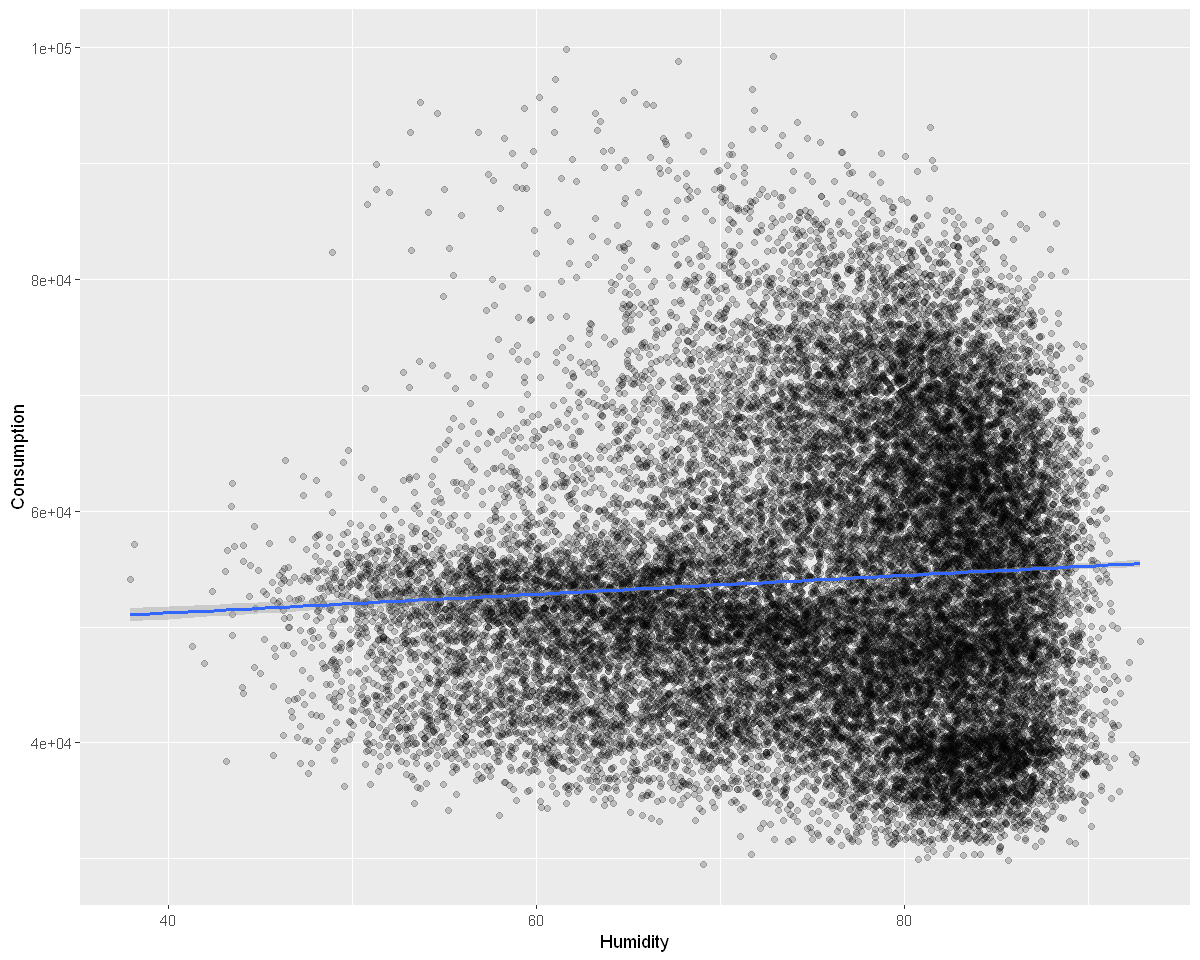

In [36]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train_1, aes(x = Humidity, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")
#Très faible corrélation positive

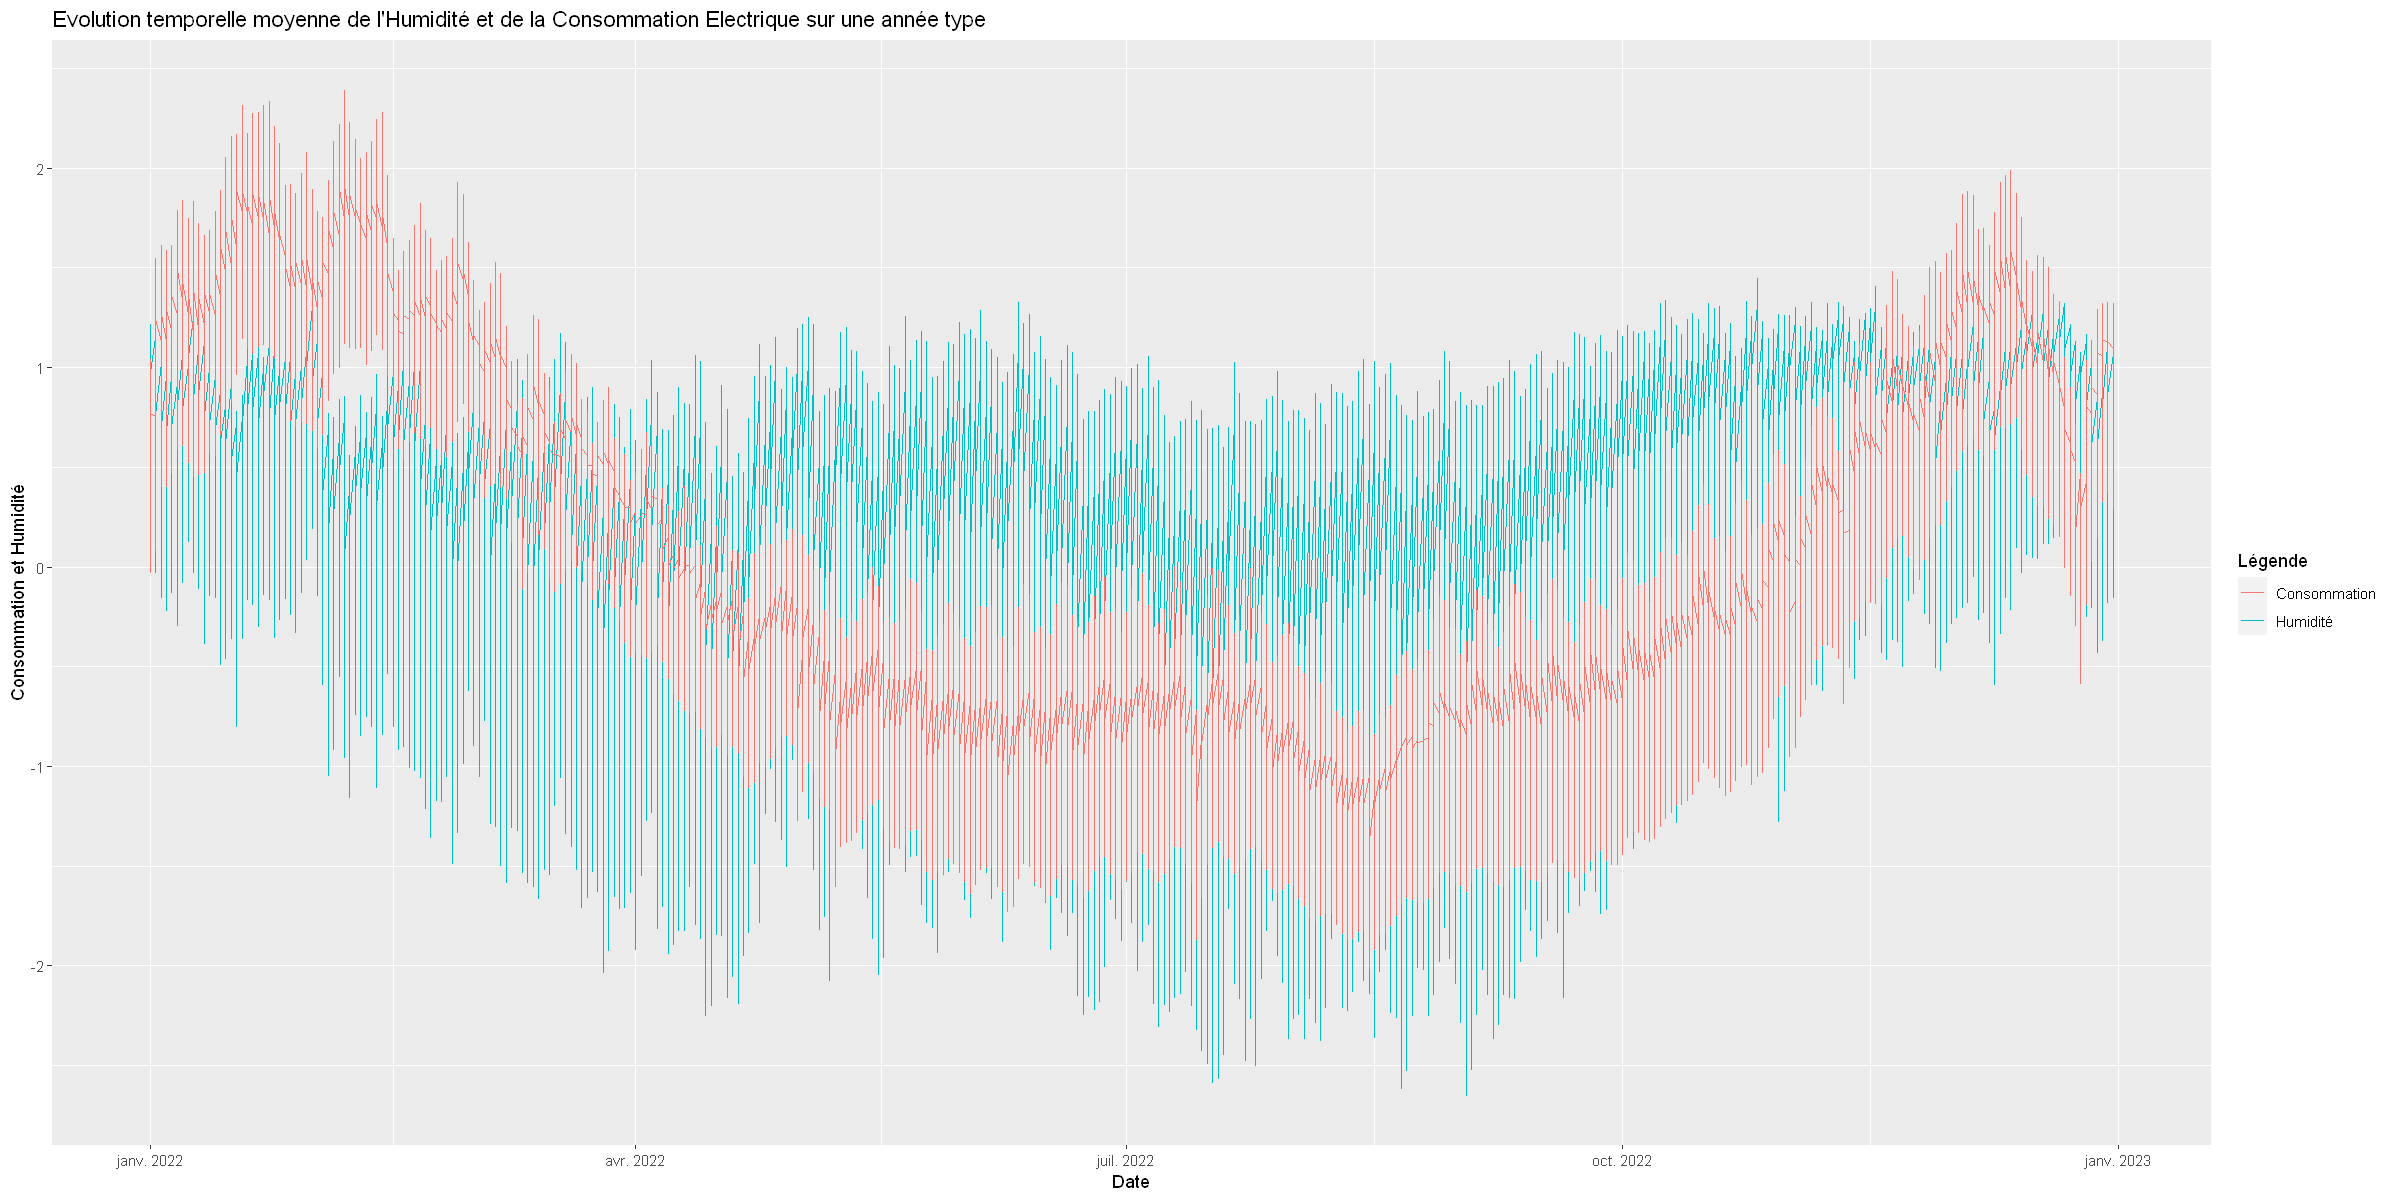

In [37]:
#Etude sur notre année type
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1_type, aes(x=Date, y=Humidity_normalized, group = 1, color = 'Humidité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de l'Humidité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Humidité")

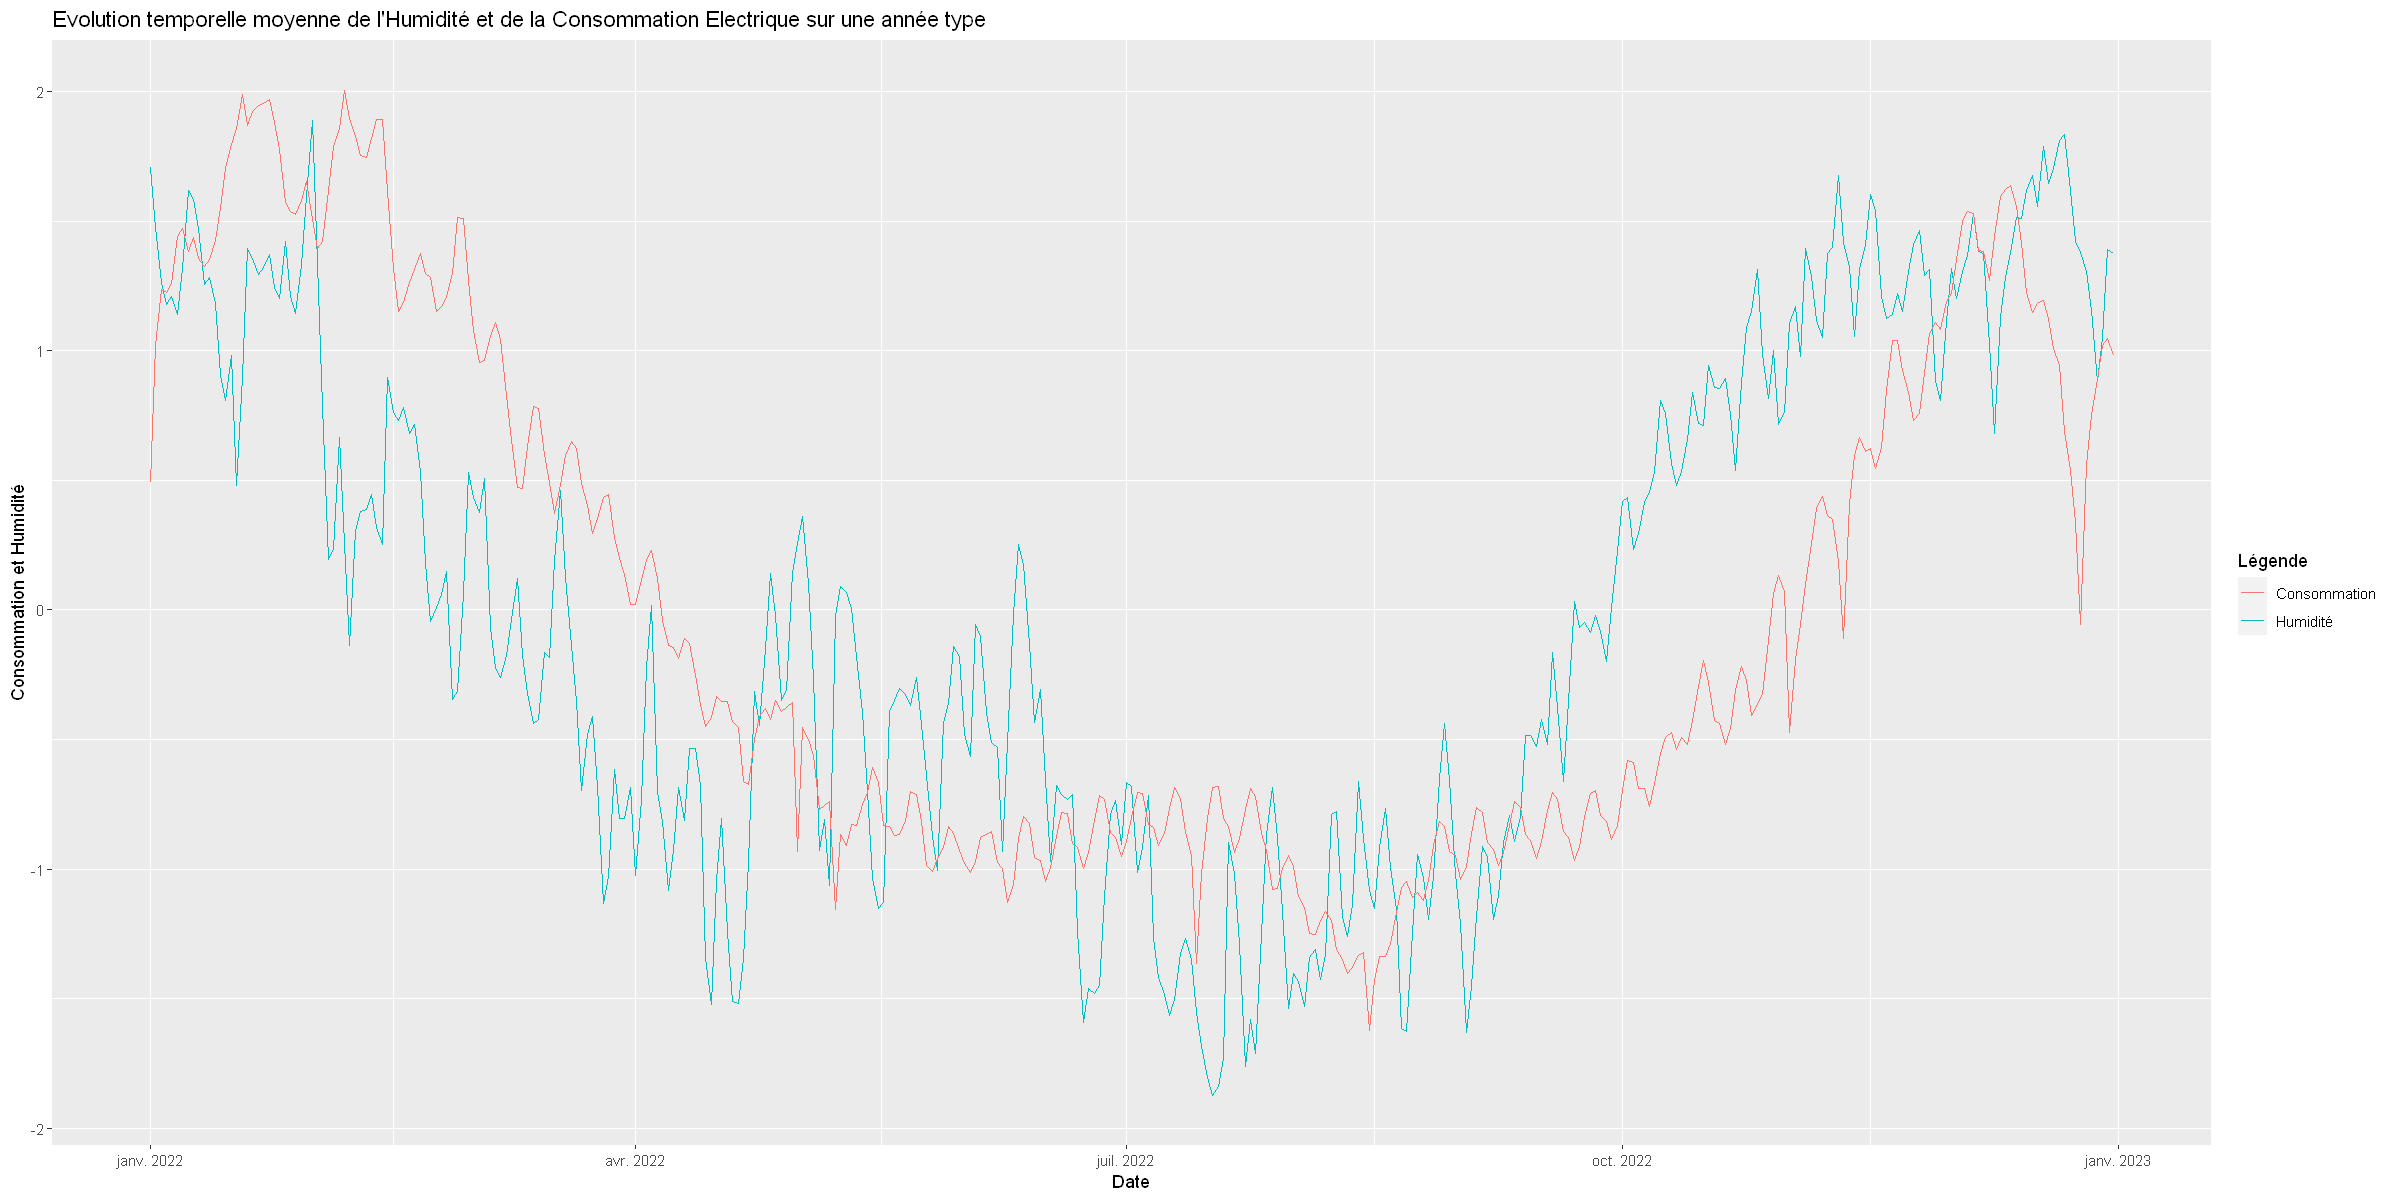

In [38]:
#Etude sur l'année type, sans Time
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1_type_notime, aes(x=Date, y=Humidity_normalized, group = 1, color = 'Humidité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de l'Humidité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Humidité")

L'humidité et la consommation électrique semblent être corrélées positivement. L'humidité semble suivre la mêmetrajectoire temporelle que la consommation électrique, mais moins que la nébulosité.

##### Etude de la saisonnalité annuelle

In [39]:
#Aggrégation par jour dans la base de données data_train_0 pour avoir un graphique plus aéré (sans Time)
data_train_0_notime <- data_train_0 %>%
   group_by(Date) %>% 
   summarise_at(vars("Consumption"), mean)

In [40]:
data_train_0_notime = data_train_0_notime %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

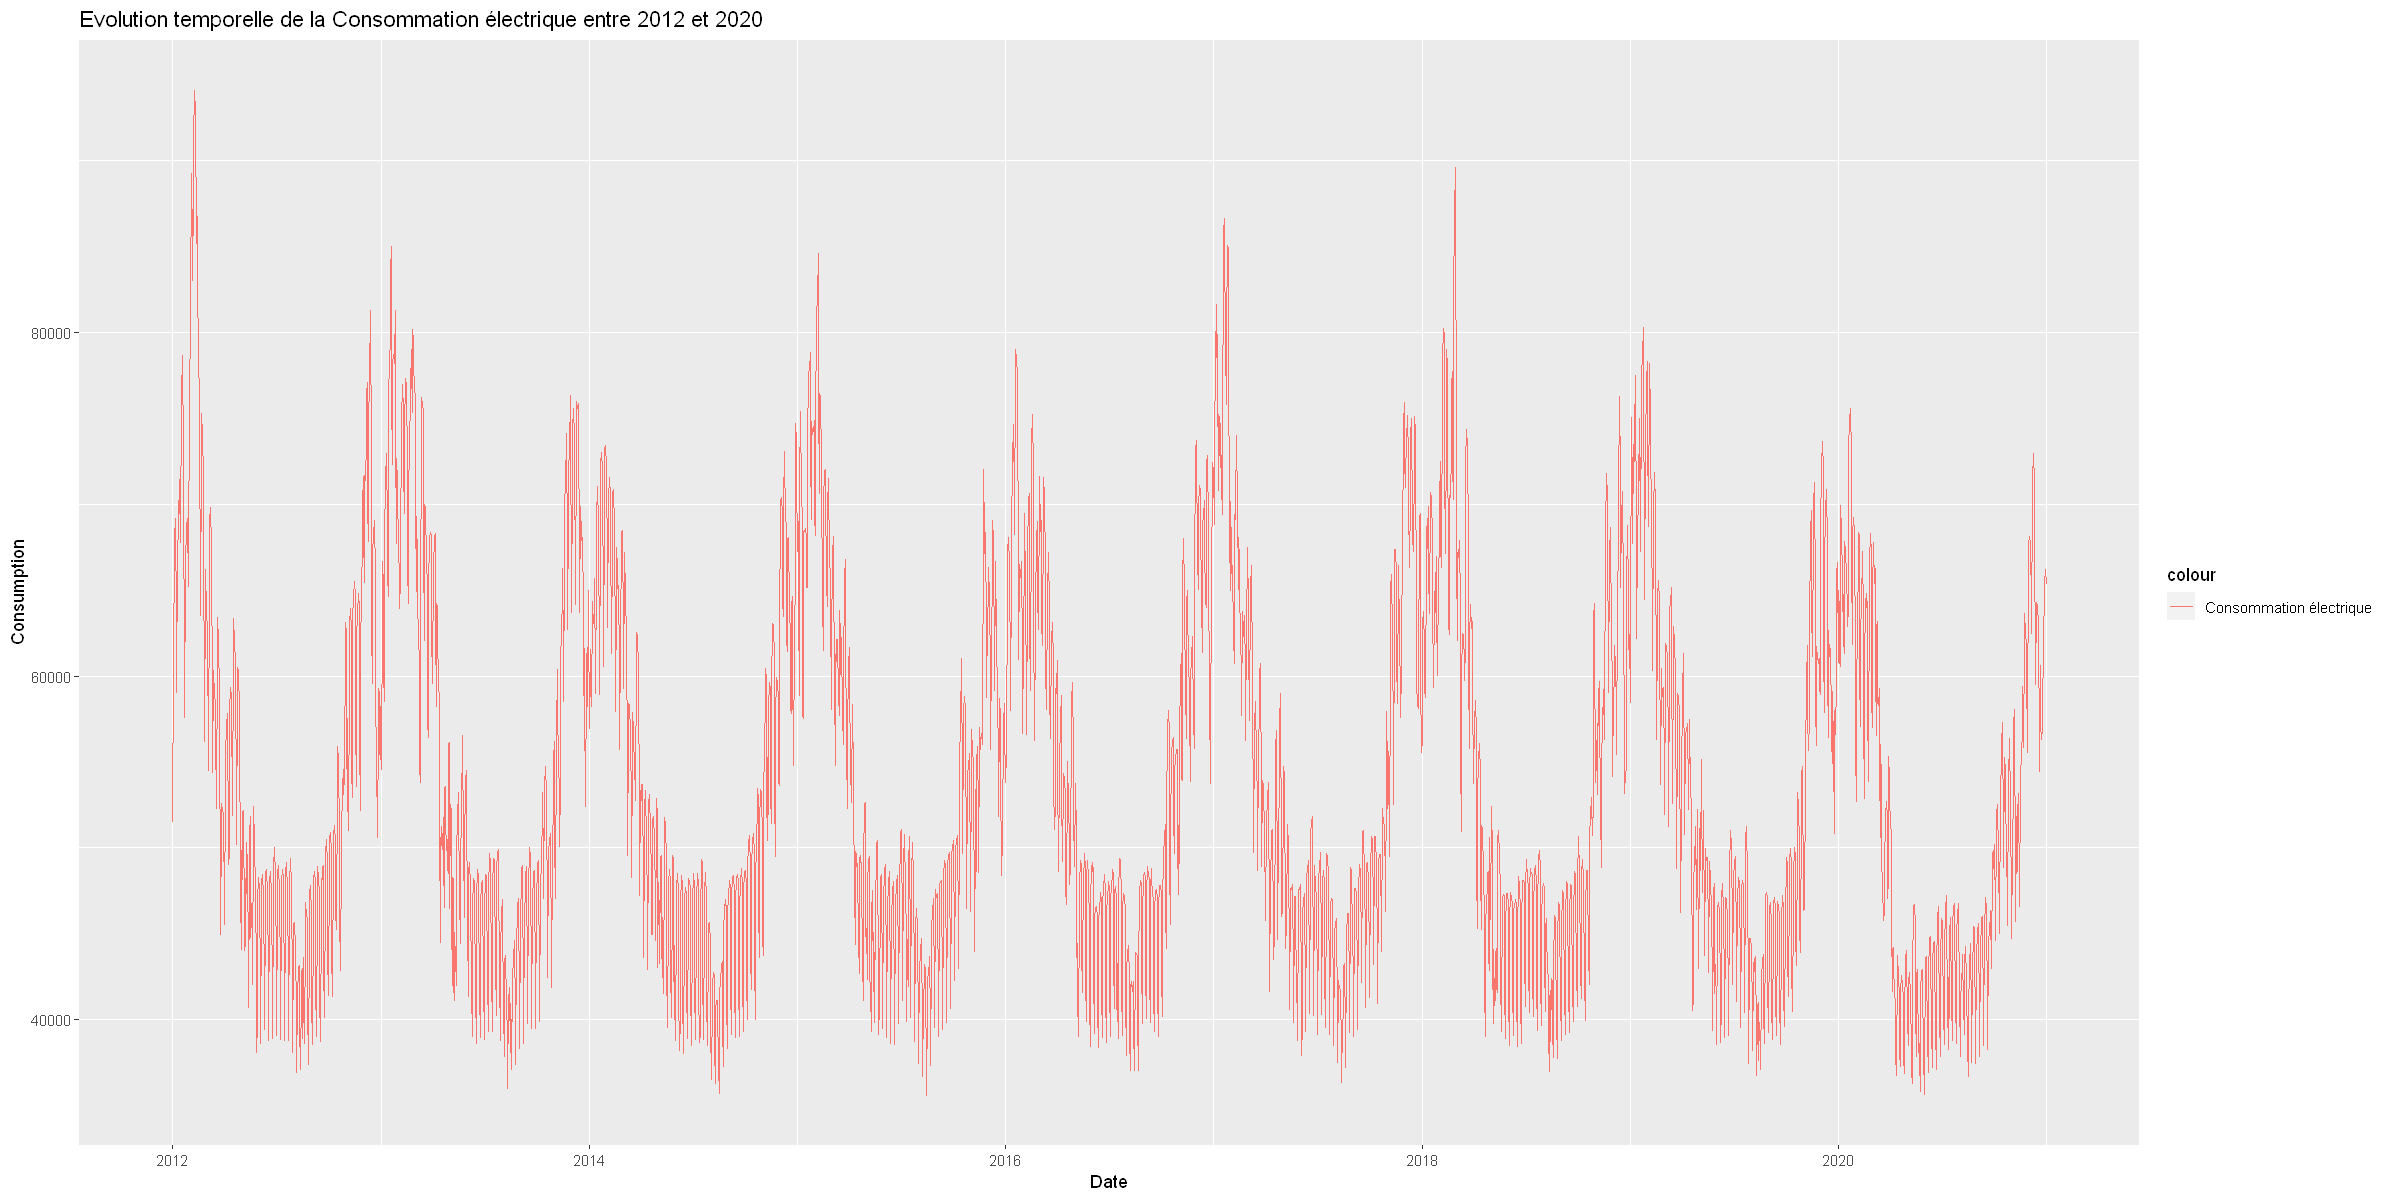

In [41]:
#Représentation de la consommation électrique par jour entre 2012 et 2020
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_notime, aes(Date, Consumption, colour="Consommation électrique")) + geom_line() + ggtitle("Evolution temporelle de la Consommation électrique entre 2012 et 2020")

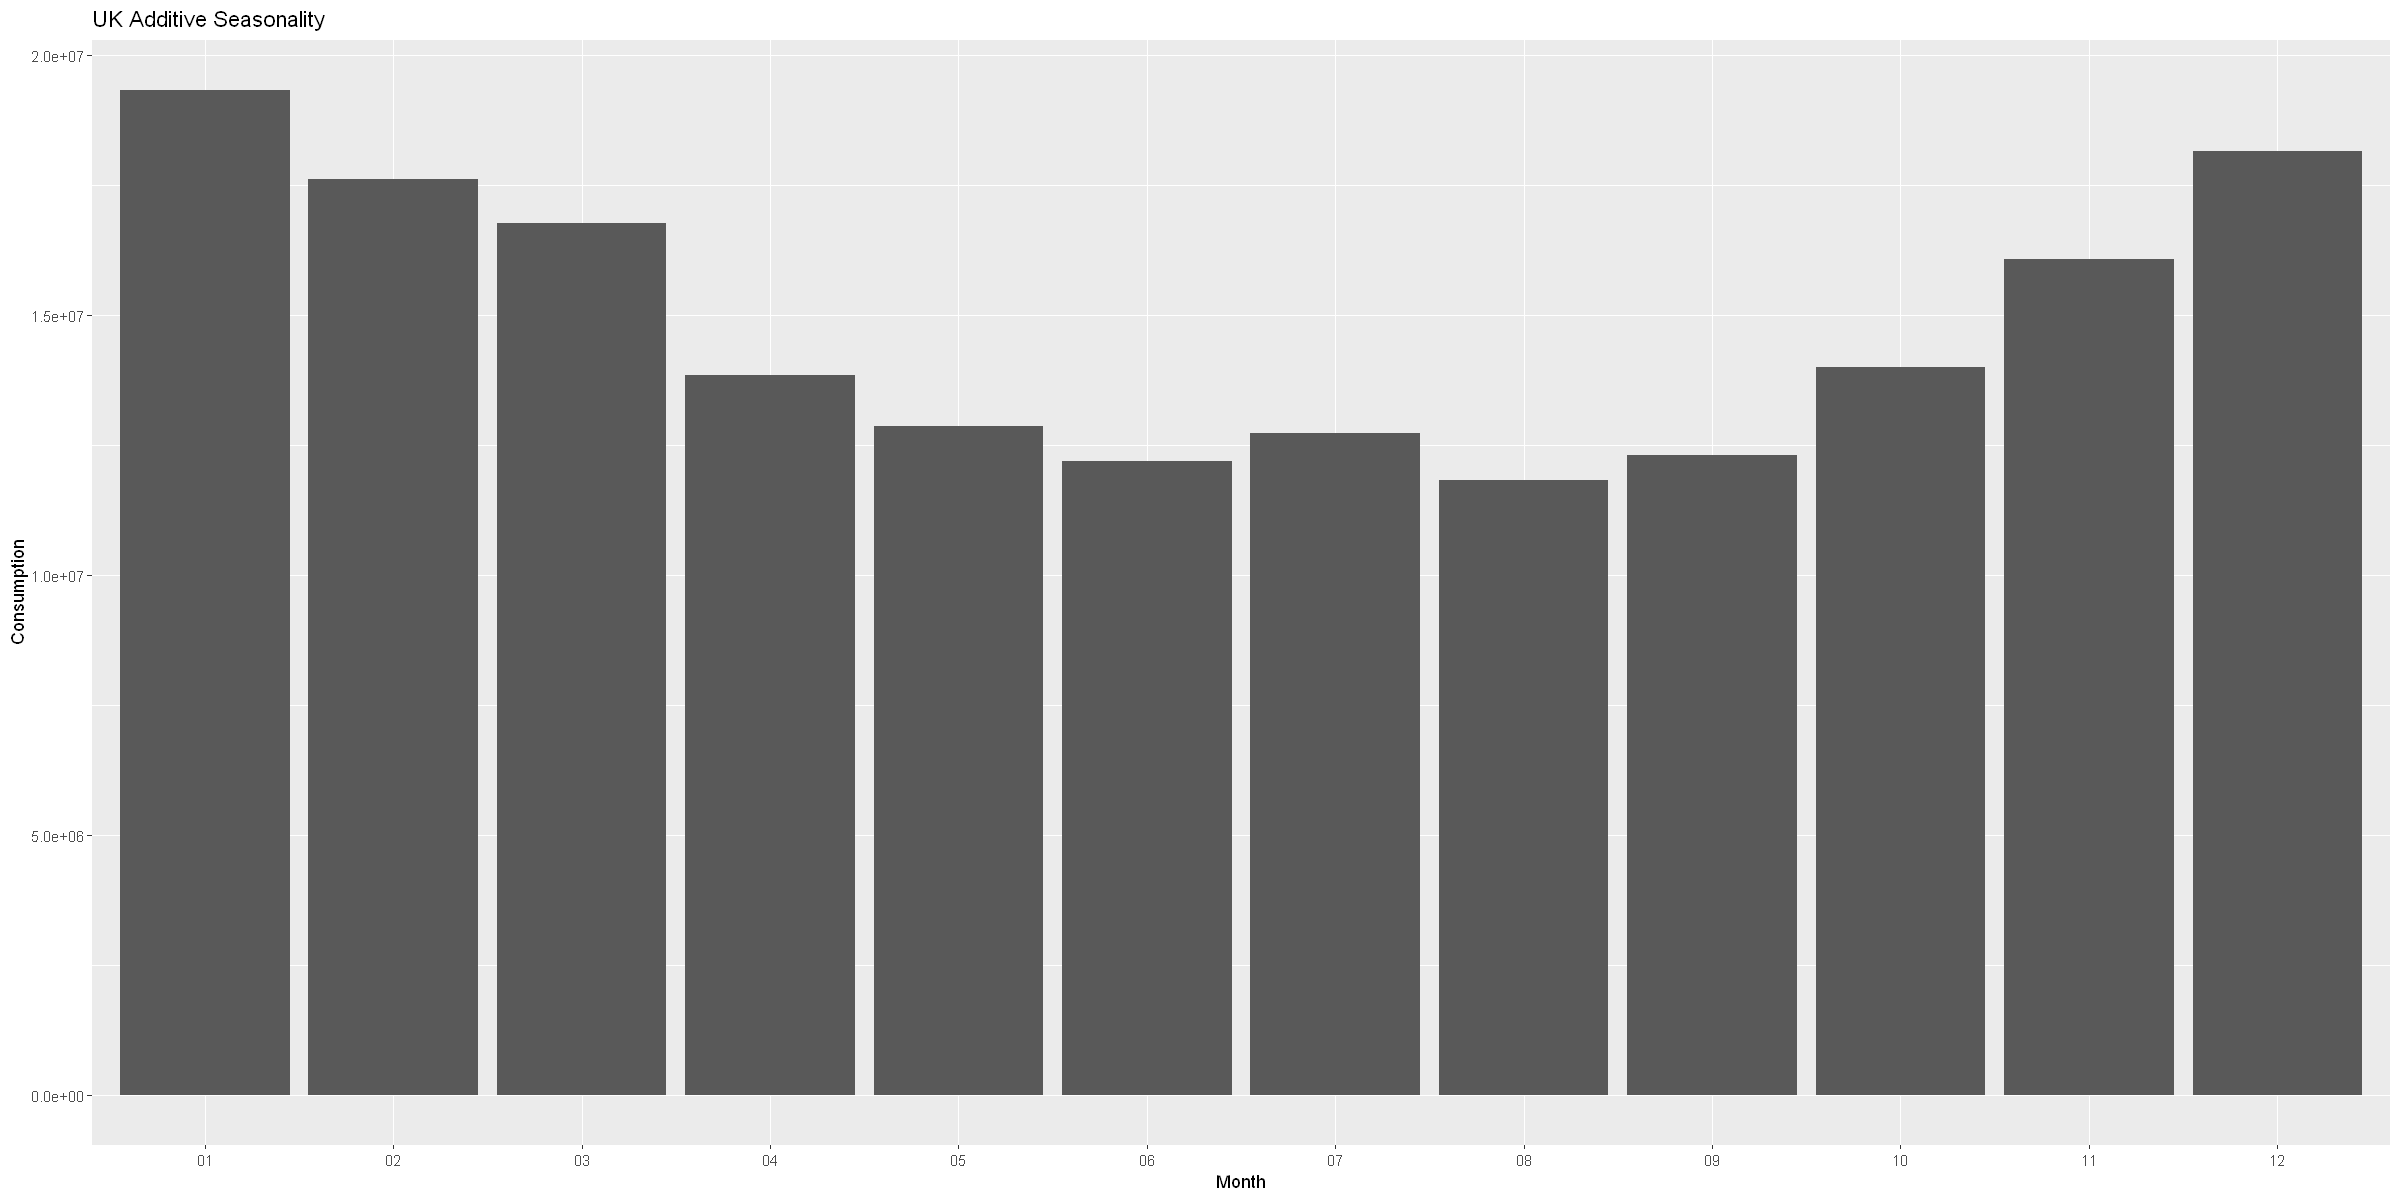

In [42]:
#Consommations électriques cumulées par mois entre 2012 et 2020
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_notime,aes(Month,Consumption)) + geom_bar(stat = "identity") + ggtitle("UK Additive Seasonality")

In [45]:
#Création d'une année "type" pour data_train_0, comme nous l'avons fait pour data_train_1
data_train_0_type <- data_train_0 %>%
   group_by(Month, Day, Time) %>% 
   summarise_at(vars("Consumption"), mean)

data_train_0_type$Date = paste(data_train_0_type$Month, data_train_0_type$Day, sep="-")
data_train_0_type$Date = as.Date(data_train_0_type$Date, format = "%m-%d")
data_train_0_type <- data_train_0_type %>% select(Date, everything())
data_train_0_type <- data_train_0_type %>% drop_na()

data_train_0_type_notime <- data_train_0_type %>%
   group_by(Date) %>% 
   summarise_at(vars("Consumption"), mean)

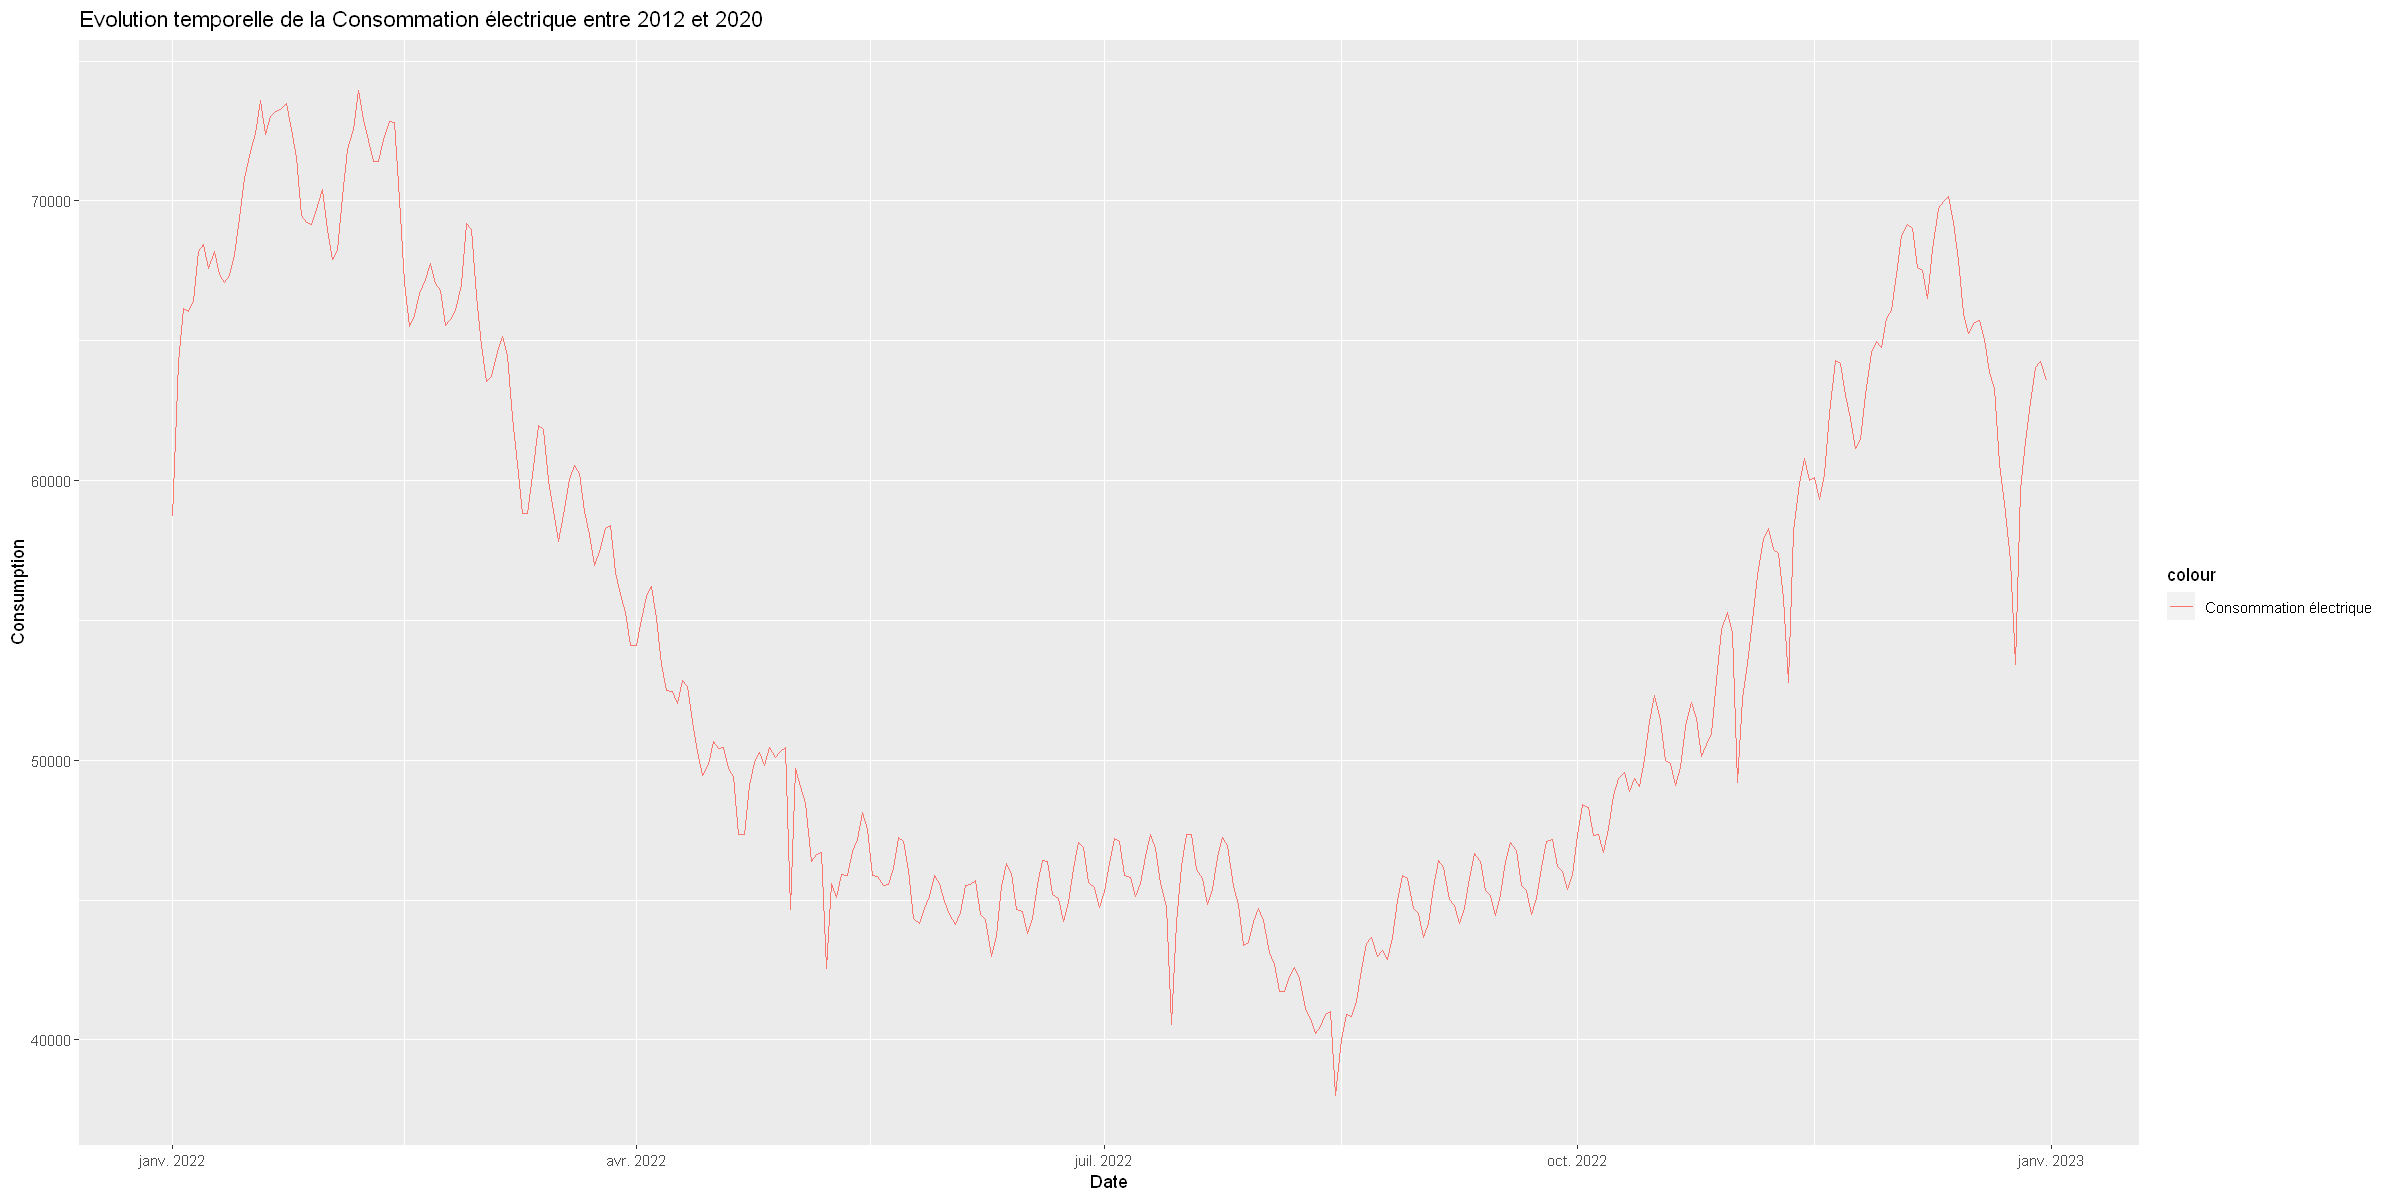

In [46]:
#Représentation de la consommation électrique sur notre année type
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_type_notime, aes(Date, Consumption, colour="Consommation électrique")) + geom_line() + ggtitle("Evolution temporelle de la Consommation électrique entre 2012 et 2020")

Nous observons clairement une saisonnalité annuelle, avec plus de consommation électrique en hiver dont un pic entre novembre et février, et moins de consommation électrique en été avec un pic observé entre juin et août

##### Etude de la saisonnalité mensuelle

In [47]:
data_train_0_type_notime = data_train_0_type_notime %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

In [48]:
#Création d'un mois type: aggréation par le numéro de jour du mois sur les 12 mois des 9 années
data_train_0_month_type <- data_train_0_type_notime %>%
                group_by(Day) %>%
                summarise_at(vars("Consumption"), mean)

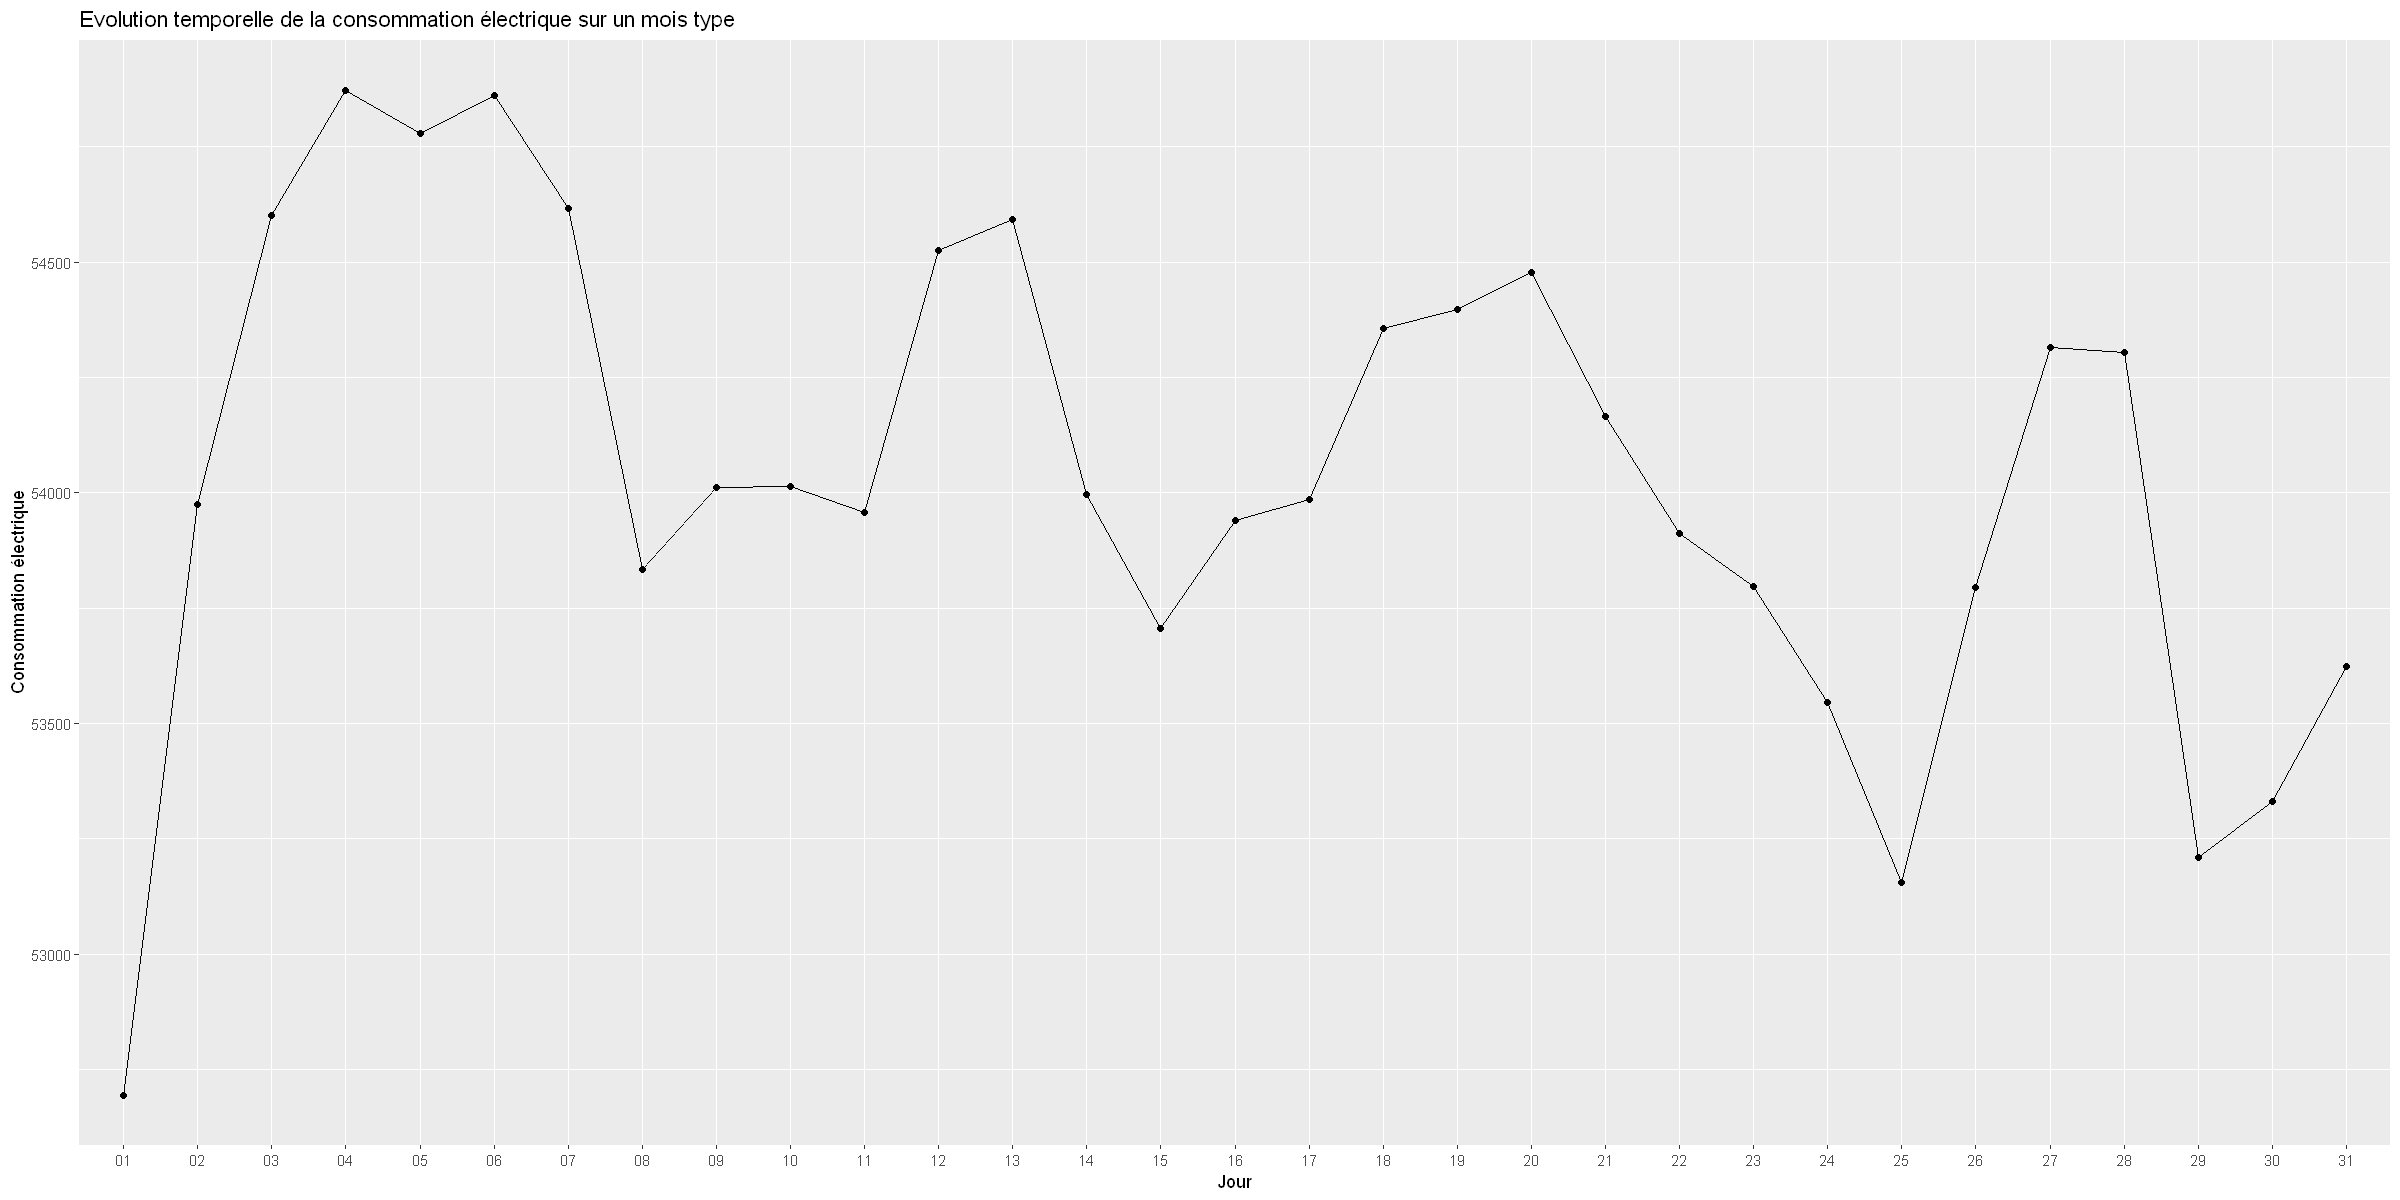

In [49]:
#Représentation graphique de la consommation électrique sur notre mois type
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_month_type, aes(Day, Consumption, group = 1)) +
         geom_point() +
         geom_line() +
         labs(x = "Jour", y = "Consommation électrique", 
              title = "Evolution temporelle de la consommation électrique sur un mois type")

On observe une forte hausse en début de mois et certains pics à certains jours du mois: pics à la hausse les 3,5, 13, 20, 27 et 28 de chaque mois et pics à la baisse le 1er, 8, 15, 25 et 29 de chaque mois

##### Etude de la saisonnalité hebdomadaire

In [50]:
#Création d'une semaine type: aggrégation par jour de la semaine
data_train_0 <- data_train_0 %>%
  mutate(Day_number = case_when(
    data_train_0$Weekday == "lundi" ~ 1,
    data_train_0$Weekday == "mardi" ~ 2,
    data_train_0$Weekday == "mercredi" ~ 3,
    data_train_0$Weekday == "jeudi" ~ 4,
    data_train_0$Weekday == "vendredi" ~ 5,
    data_train_0$Weekday == "samedi" ~ 6,
    data_train_0$Weekday == "dimanche" ~ 7,
    ))

data_train_0_day_type <- data_train_0 %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

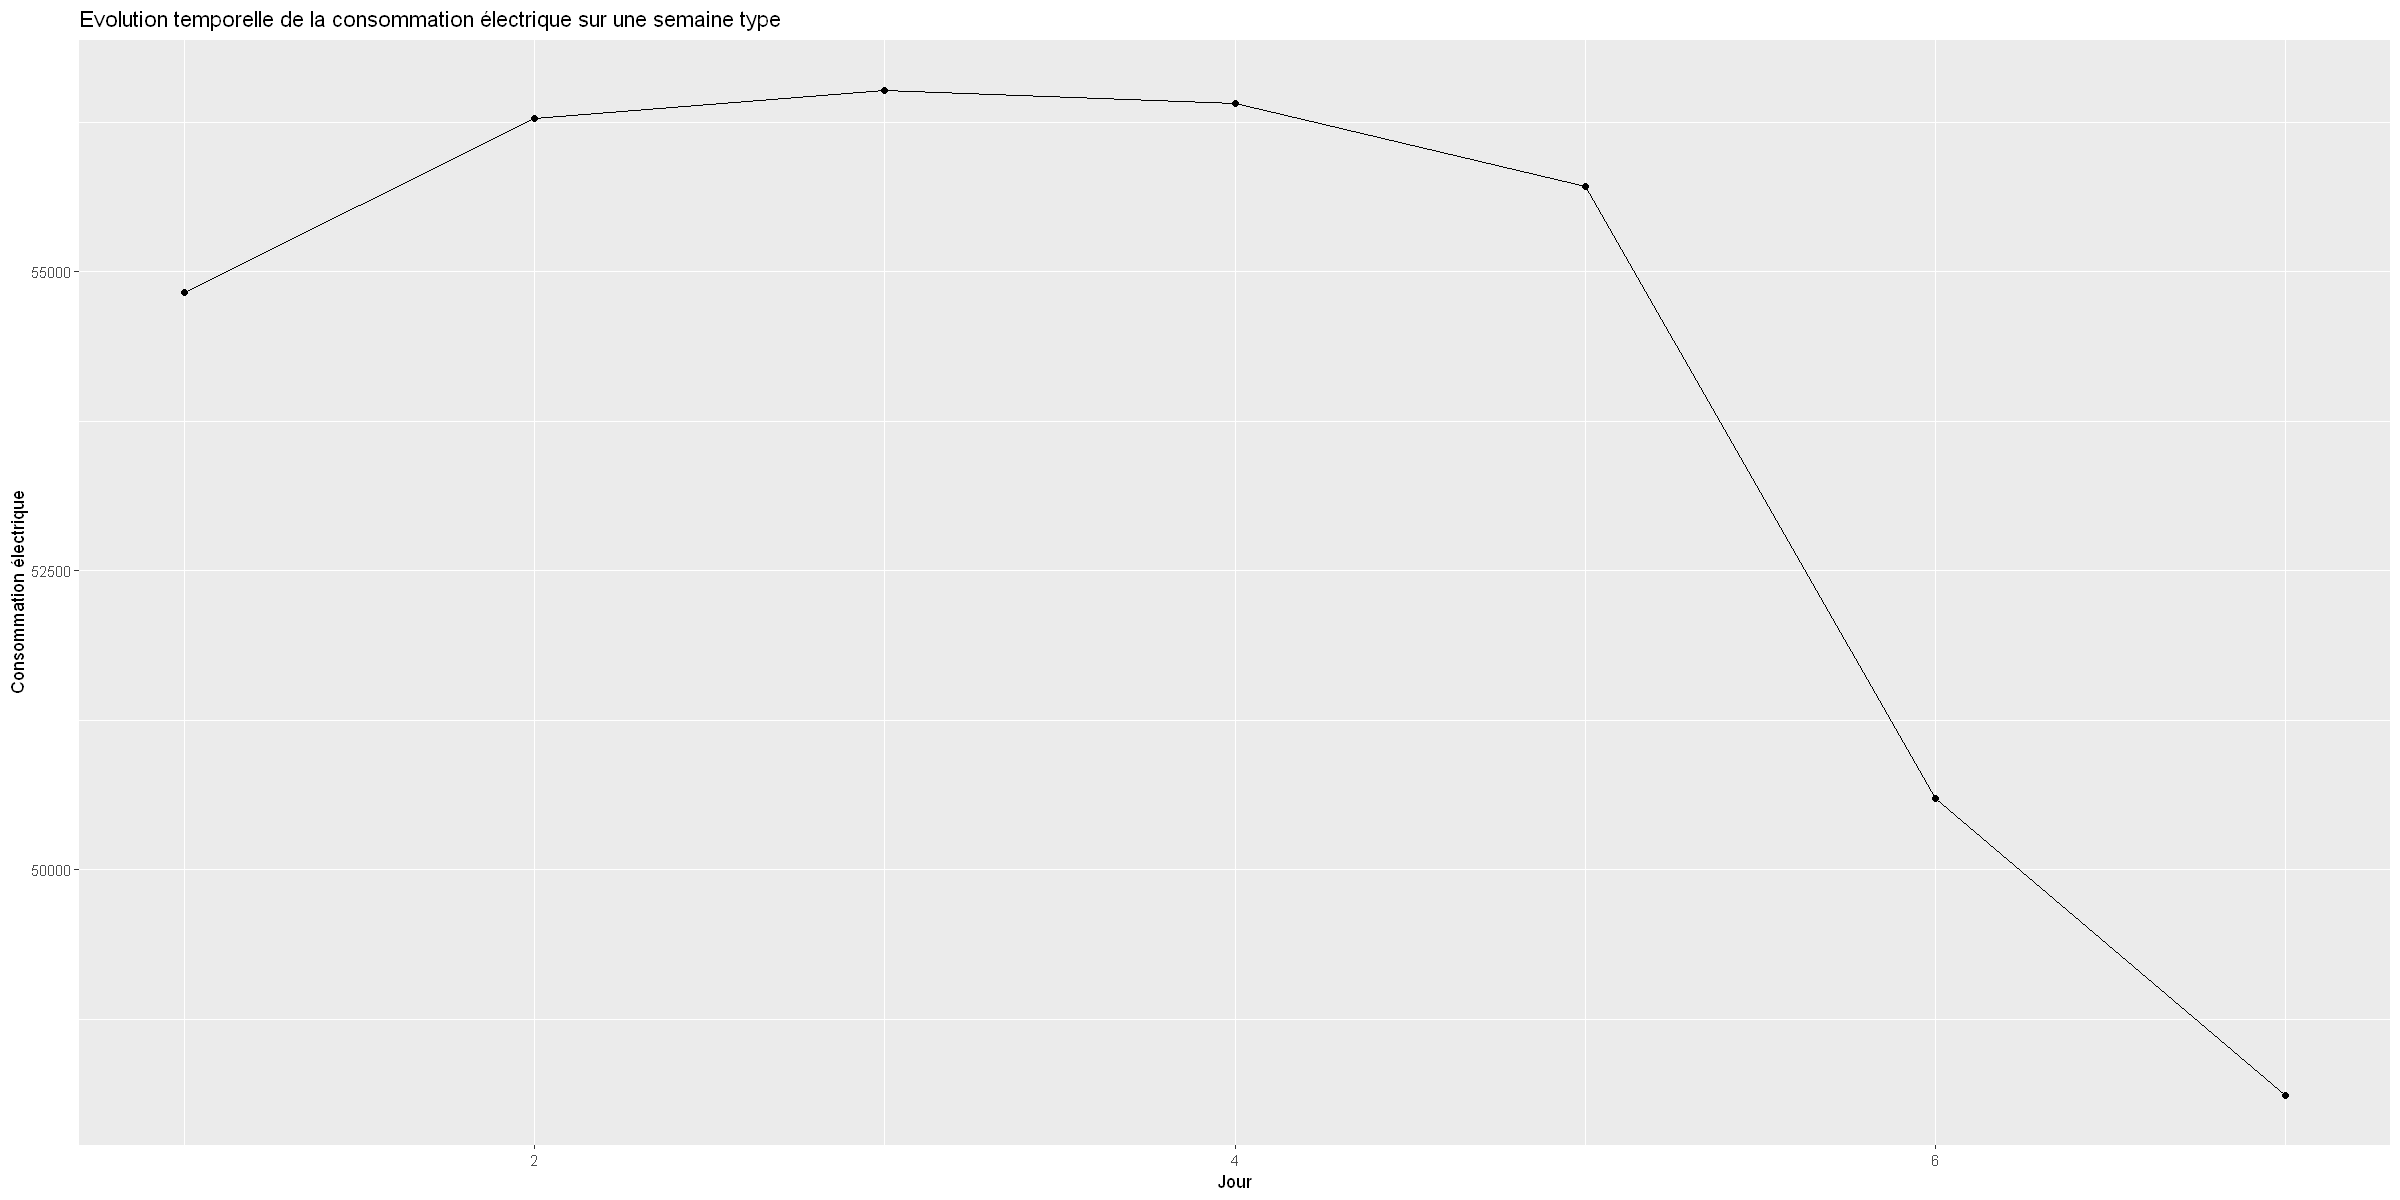

In [51]:
#Reorésentation graphique de la consommation électrique sur notre semaine type
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_day_type, aes(Day_number, Consumption, group = 1)) +
         geom_point() +
         geom_line() +
         labs(x = "Jour", y = "Consommation électrique", 
              title = "Evolution temporelle de la consommation électrique sur une semaine type")

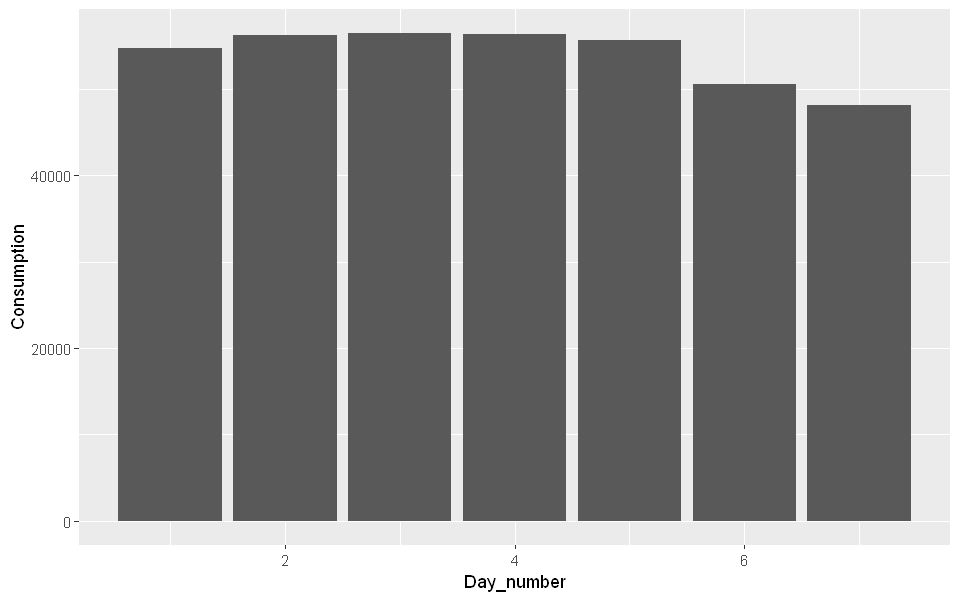

In [52]:
#Consommation électrique par jour de notre semaine type
options(repr.plot.width=8, repr.plot.height=5)
ggplot(data=data_train_0_day_type, aes(x=Day_number, y=Consumption)) + geom_bar(stat="identity")

Nous observons de consommation le mardi-mercredi-jeudi, une diminution le vendredi et une grande diminution le week-end. Nous observons également une plus faible consommation le lundi par rapport aux autres jours ouvrés.

##### Etude de la saisonnalité journalière

In [53]:
#Création d'une journée type: aggrégation par 'Time'
data_train_0_time_type <- data_train_0 %>%
    group_by(Time) %>%
    summarise_at(vars("Consumption"), mean)

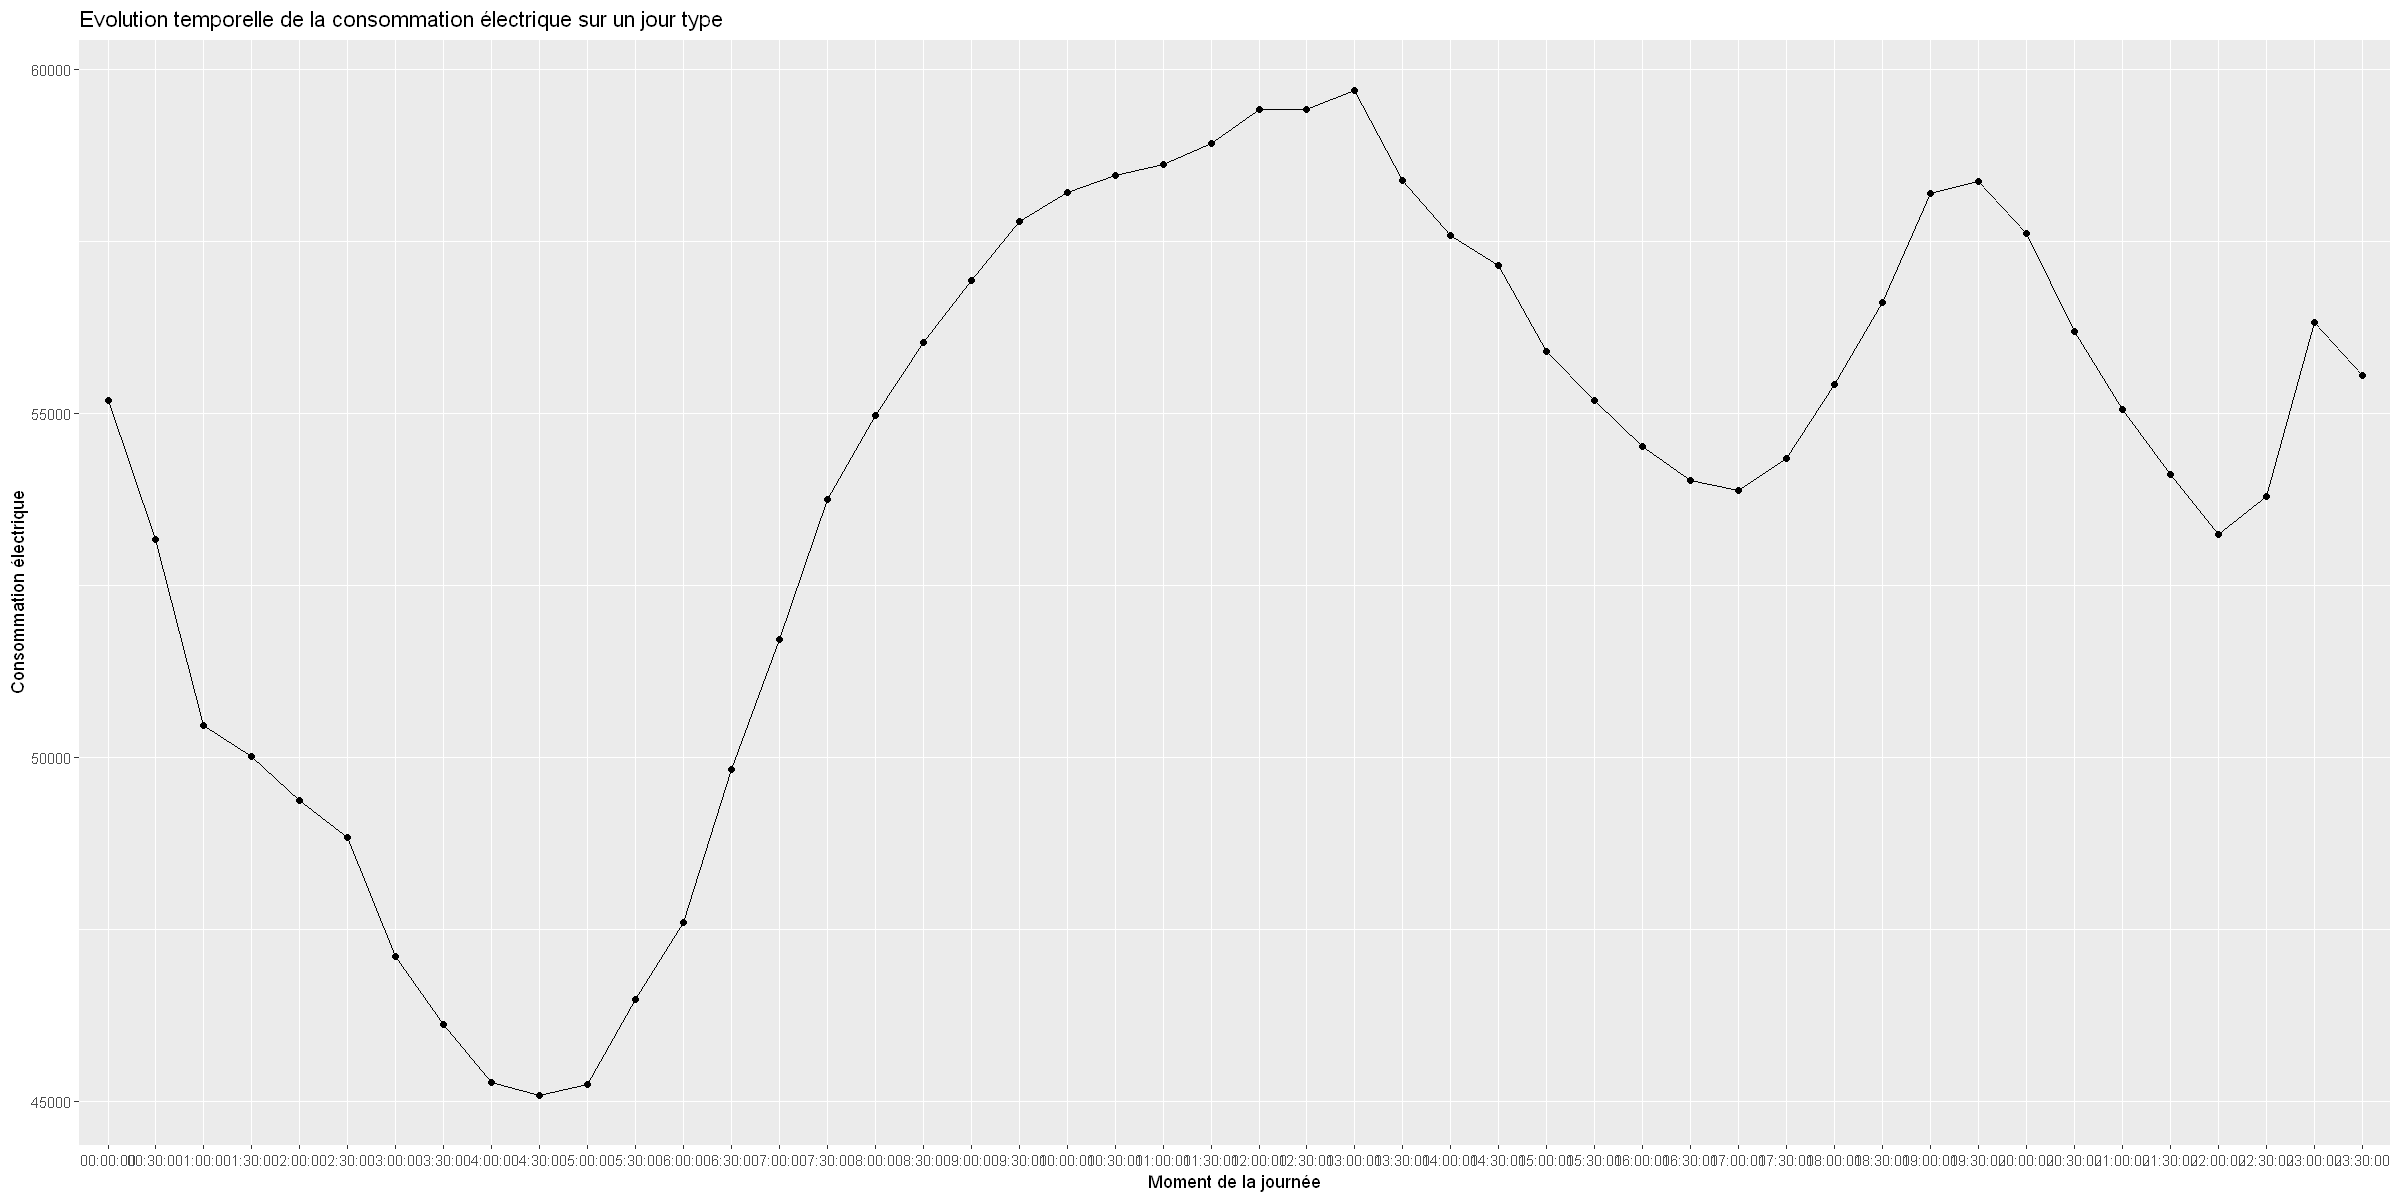

In [54]:
#Représentation graphique de la consommation électrique sur notre journée type
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_time_type, aes(Time, Consumption, group = 1)) +
         geom_point() +
         geom_line() +
         labs(x = "Moment de la journée", y = "Consommation électrique", 
              title = "Evolution temporelle de la consommation électrique sur un jour type")

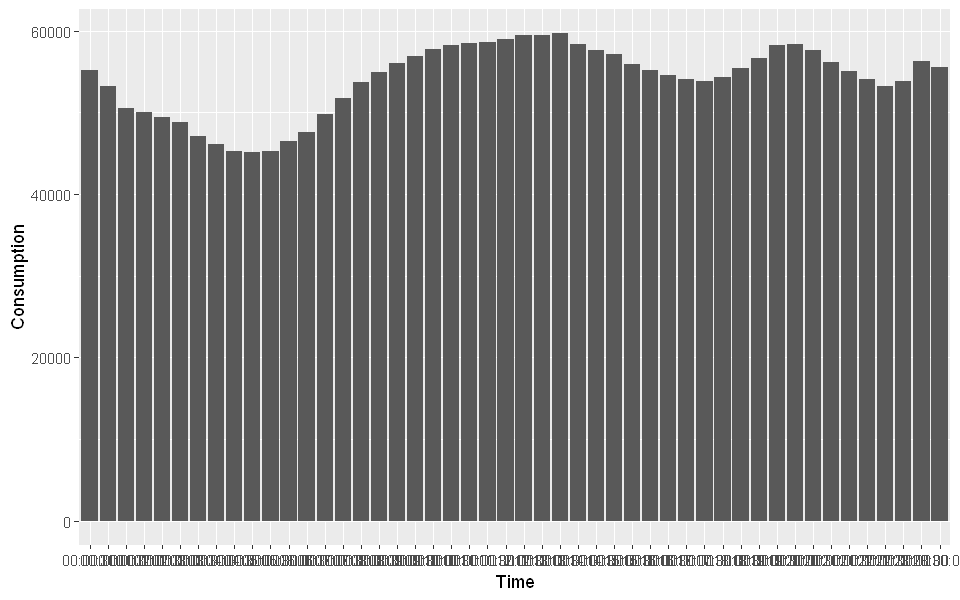

In [55]:
#Consommation électrique pour chaque période de notre journée type
options(repr.plot.width=8, repr.plot.height=5)
ggplot(data=data_train_0_time_type, aes(x=Time, y=Consumption)) + geom_bar(stat="identity")

Nous observons une forte hausse de la consommation électrique à partir de 6h du matin, puis un pic de la consommation à midi. La consommation électrique diminue à 15h puis il y a un second pic de la consommation entre 17h et 20h, puis une baisse de la consommation à partir de 20h qui s'accentue à partir de minuit.

##### Etude des jours fériés

In [56]:
#Aggrégation de la consommation électrique par jour férié (en différenciant les jours fériés)
data_train_0_ferie <- data_train_0 %>%
    group_by(jour_ferie) %>%
    summarise_at(vars("Consumption"), mean)

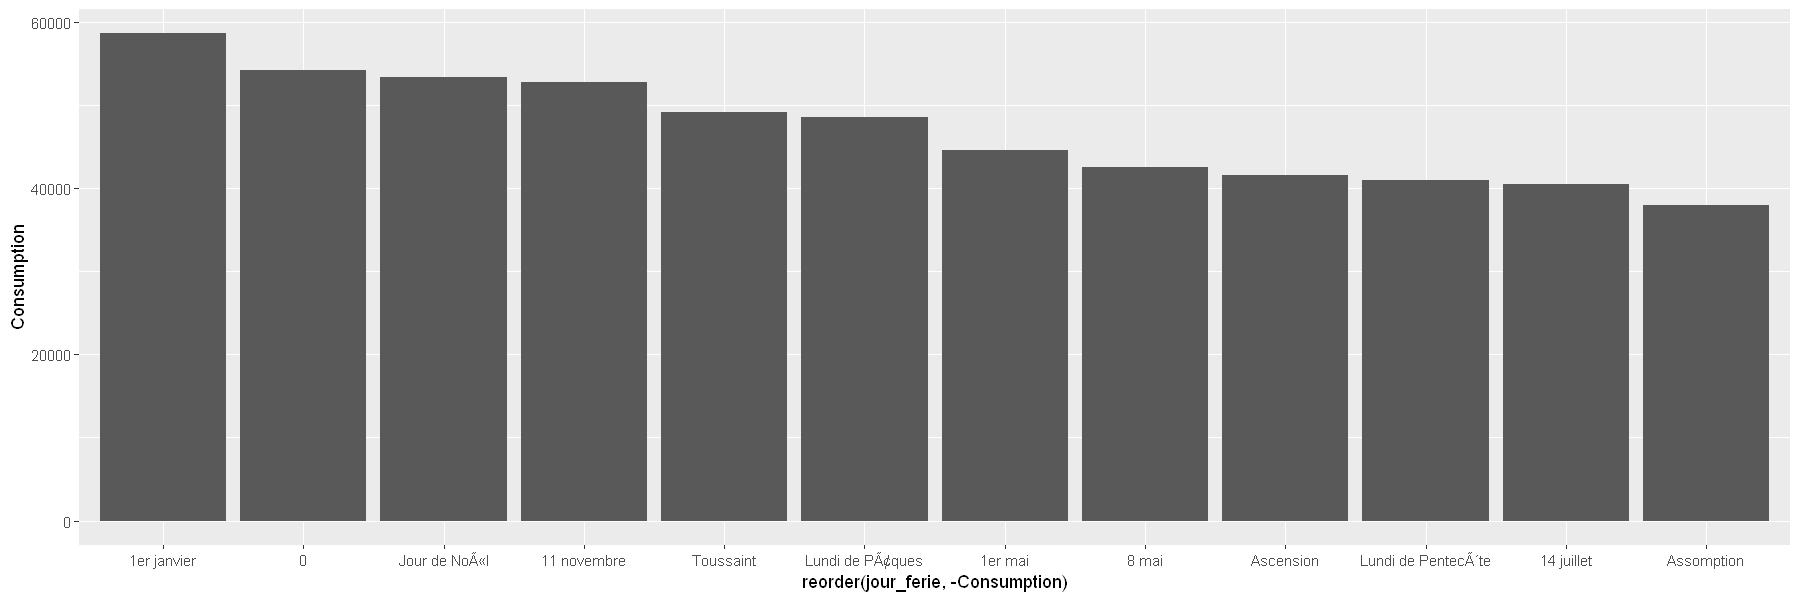

In [57]:
#Consommations électriques cumulées par jour férié entre 2012 et 2020
options(repr.plot.width=15, repr.plot.height=5)
ggplot(data=data_train_0_ferie, aes(x=reorder(jour_ferie, -Consumption), y=Consumption)) + geom_bar(stat="identity")

In [58]:
#Création d'un jour férié type: aggrégation par jour férié (en ne différenciant pas les jours fériés)
data_train_0_ferie <- data_train_0_ferie %>%
  mutate(jour_ferie = case_when(
    data_train_0_ferie$jour_ferie == 0 ~ 0,
    data_train_0_ferie$jour_ferie != 0 ~ 1,
    ))

data_train_0_ferie <- data_train_0_ferie %>%
    group_by(jour_ferie) %>%
    summarise_at(vars("Consumption"), mean)

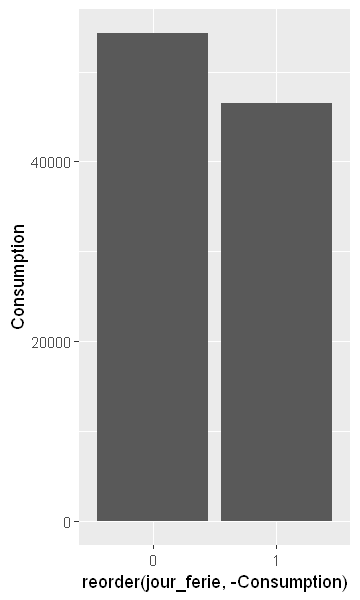

In [59]:
#Consommations électriques cumulées en jour férié ou hors jour férié
options(repr.plot.width=3, repr.plot.height=5)
ggplot(data=data_train_0_ferie, aes(x=reorder(jour_ferie, -Consumption), y=Consumption)) + geom_bar(stat="identity")

In [61]:
#Calcul de la variation de consommation électrique
data_train_0_ferie$growth <- with(data_train_0_ferie, ave(Consumption,
                          FUN=function(x) c(NA, diff(x) / tail(x, -1))))
data_train_0_ferie

jour_ferie,Consumption,growth
<dbl>,<dbl>,<dbl>
0,54298.93,NA
1,46471.68,-0.1684304


En moyenne, la consommation d'électricité diminue de 17% environ en jour férié. Mais on constate des disparités selon le type de jour férié: on consomme davantage le 1er janvier et beaucoup moins lors de l'Assomption, lié également à la saison et température liées au mois du jour férié.

##### Etudes des vacances

In [62]:
#Création d'un jour de vacances type: aggrégation faite avec la variable 'Holidays'
data_train_0_holidays <- data_train_0 %>%
    group_by(Holidays) %>%
    summarise_at(vars("Consumption"), mean)

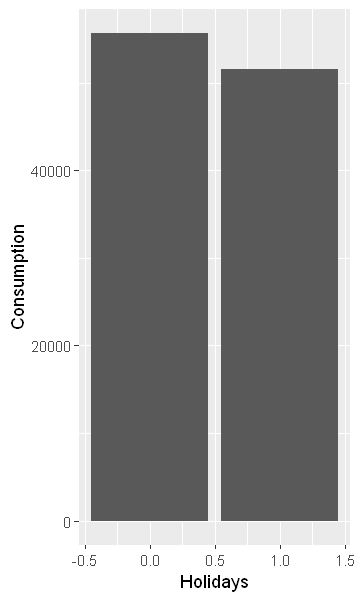

In [63]:
#Consommations électriques cumulées en ou hors vacances entre 2012 et 2020
options(repr.plot.width=3, repr.plot.height=5)
ggplot(data=data_train_0_holidays, aes(x=Holidays, y=Consumption)) + geom_bar(stat="identity")

In [64]:
#Calcul de la variation de consommation électrique
data_train_0_holidays$growth <- with(data_train_0_holidays, ave(Consumption,
                          FUN=function(x) c(NA, diff(x) / tail(x, -1))))
data_train_0_holidays

Holidays,Consumption,growth
<dbl>,<dbl>,<dbl>
0,55655.22,NA
1,51569.04,-0.07923698


En moyenne, la consommation d'électricité diminue de 8% environ pendant les vacances.

In [65]:
#On calcule les variations de consommation électrique par zone de vacances
data_train_day_type_holidays_A <- subset(data_train_0, Holidays_A==1)
data_train_day_type_holidays_A <- data_train_day_type_holidays_A %>%
  mutate(Day_number = case_when(
    data_train_day_type_holidays_A$Weekday == "lundi" ~ 1,
    data_train_day_type_holidays_A$Weekday == "mardi" ~ 2,
    data_train_day_type_holidays_A$Weekday == "mercredi" ~ 3,
    data_train_day_type_holidays_A$Weekday == "jeudi" ~ 4,
    data_train_day_type_holidays_A$Weekday == "vendredi" ~ 5,
    data_train_day_type_holidays_A$Weekday == "samedi" ~ 6,
    data_train_day_type_holidays_A$Weekday == "dimanche" ~ 7,
    ))

data_train_day_type_holidays_A <- data_train_day_type_holidays_A %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

data_train_day_type_holidays_B <- subset(data_train_0, Holidays_B==1)
data_train_day_type_holidays_B <- data_train_day_type_holidays_B %>%
  mutate(Day_number = case_when(
    data_train_day_type_holidays_B$Weekday == "lundi" ~ 1,
    data_train_day_type_holidays_B$Weekday == "mardi" ~ 2,
    data_train_day_type_holidays_B$Weekday == "mercredi" ~ 3,
    data_train_day_type_holidays_B$Weekday == "jeudi" ~ 4,
    data_train_day_type_holidays_B$Weekday == "vendredi" ~ 5,
    data_train_day_type_holidays_B$Weekday == "samedi" ~ 6,
    data_train_day_type_holidays_B$Weekday == "dimanche" ~ 7,
    ))

data_train_day_type_holidays_B <- data_train_day_type_holidays_B %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

data_train_day_type_holidays_C <- subset(data_train_0, Holidays_C==1)
data_train_day_type_holidays_C <- data_train_day_type_holidays_C %>%
  mutate(Day_number = case_when(
    data_train_day_type_holidays_C$Weekday == "lundi" ~ 1,
    data_train_day_type_holidays_C$Weekday == "mardi" ~ 2,
    data_train_day_type_holidays_C$Weekday == "mercredi" ~ 3,
    data_train_day_type_holidays_C$Weekday == "jeudi" ~ 4,
    data_train_day_type_holidays_C$Weekday == "vendredi" ~ 5,
    data_train_day_type_holidays_C$Weekday == "samedi" ~ 6,
    data_train_day_type_holidays_C$Weekday == "dimanche" ~ 7,
    ))

data_train_day_type_holidays_C <- data_train_day_type_holidays_C %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

data_train_day_type_holidays <- subset(data_train_0, Holidays==1)
data_train_day_type_holidays <- data_train_day_type_holidays %>%
  mutate(Day_number = case_when(
    data_train_day_type_holidays$Weekday == "lundi" ~ 1,
    data_train_day_type_holidays$Weekday == "mardi" ~ 2,
    data_train_day_type_holidays$Weekday == "mercredi" ~ 3,
    data_train_day_type_holidays$Weekday == "jeudi" ~ 4,
    data_train_day_type_holidays$Weekday == "vendredi" ~ 5,
    data_train_day_type_holidays$Weekday == "samedi" ~ 6,
    data_train_day_type_holidays$Weekday == "dimanche" ~ 7,
    ))

data_train_day_type_holidays <- data_train_day_type_holidays %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

data_train_0_day_type$Consumption_A <- data_train_day_type_holidays_A$Consumption
data_train_0_day_type$Consumption_B <- data_train_day_type_holidays_B$Consumption
data_train_0_day_type$Consumption_C <- data_train_day_type_holidays_C$Consumption
data_train_0_day_type$Consumption_nozone <- data_train_day_type_holidays$Consumption

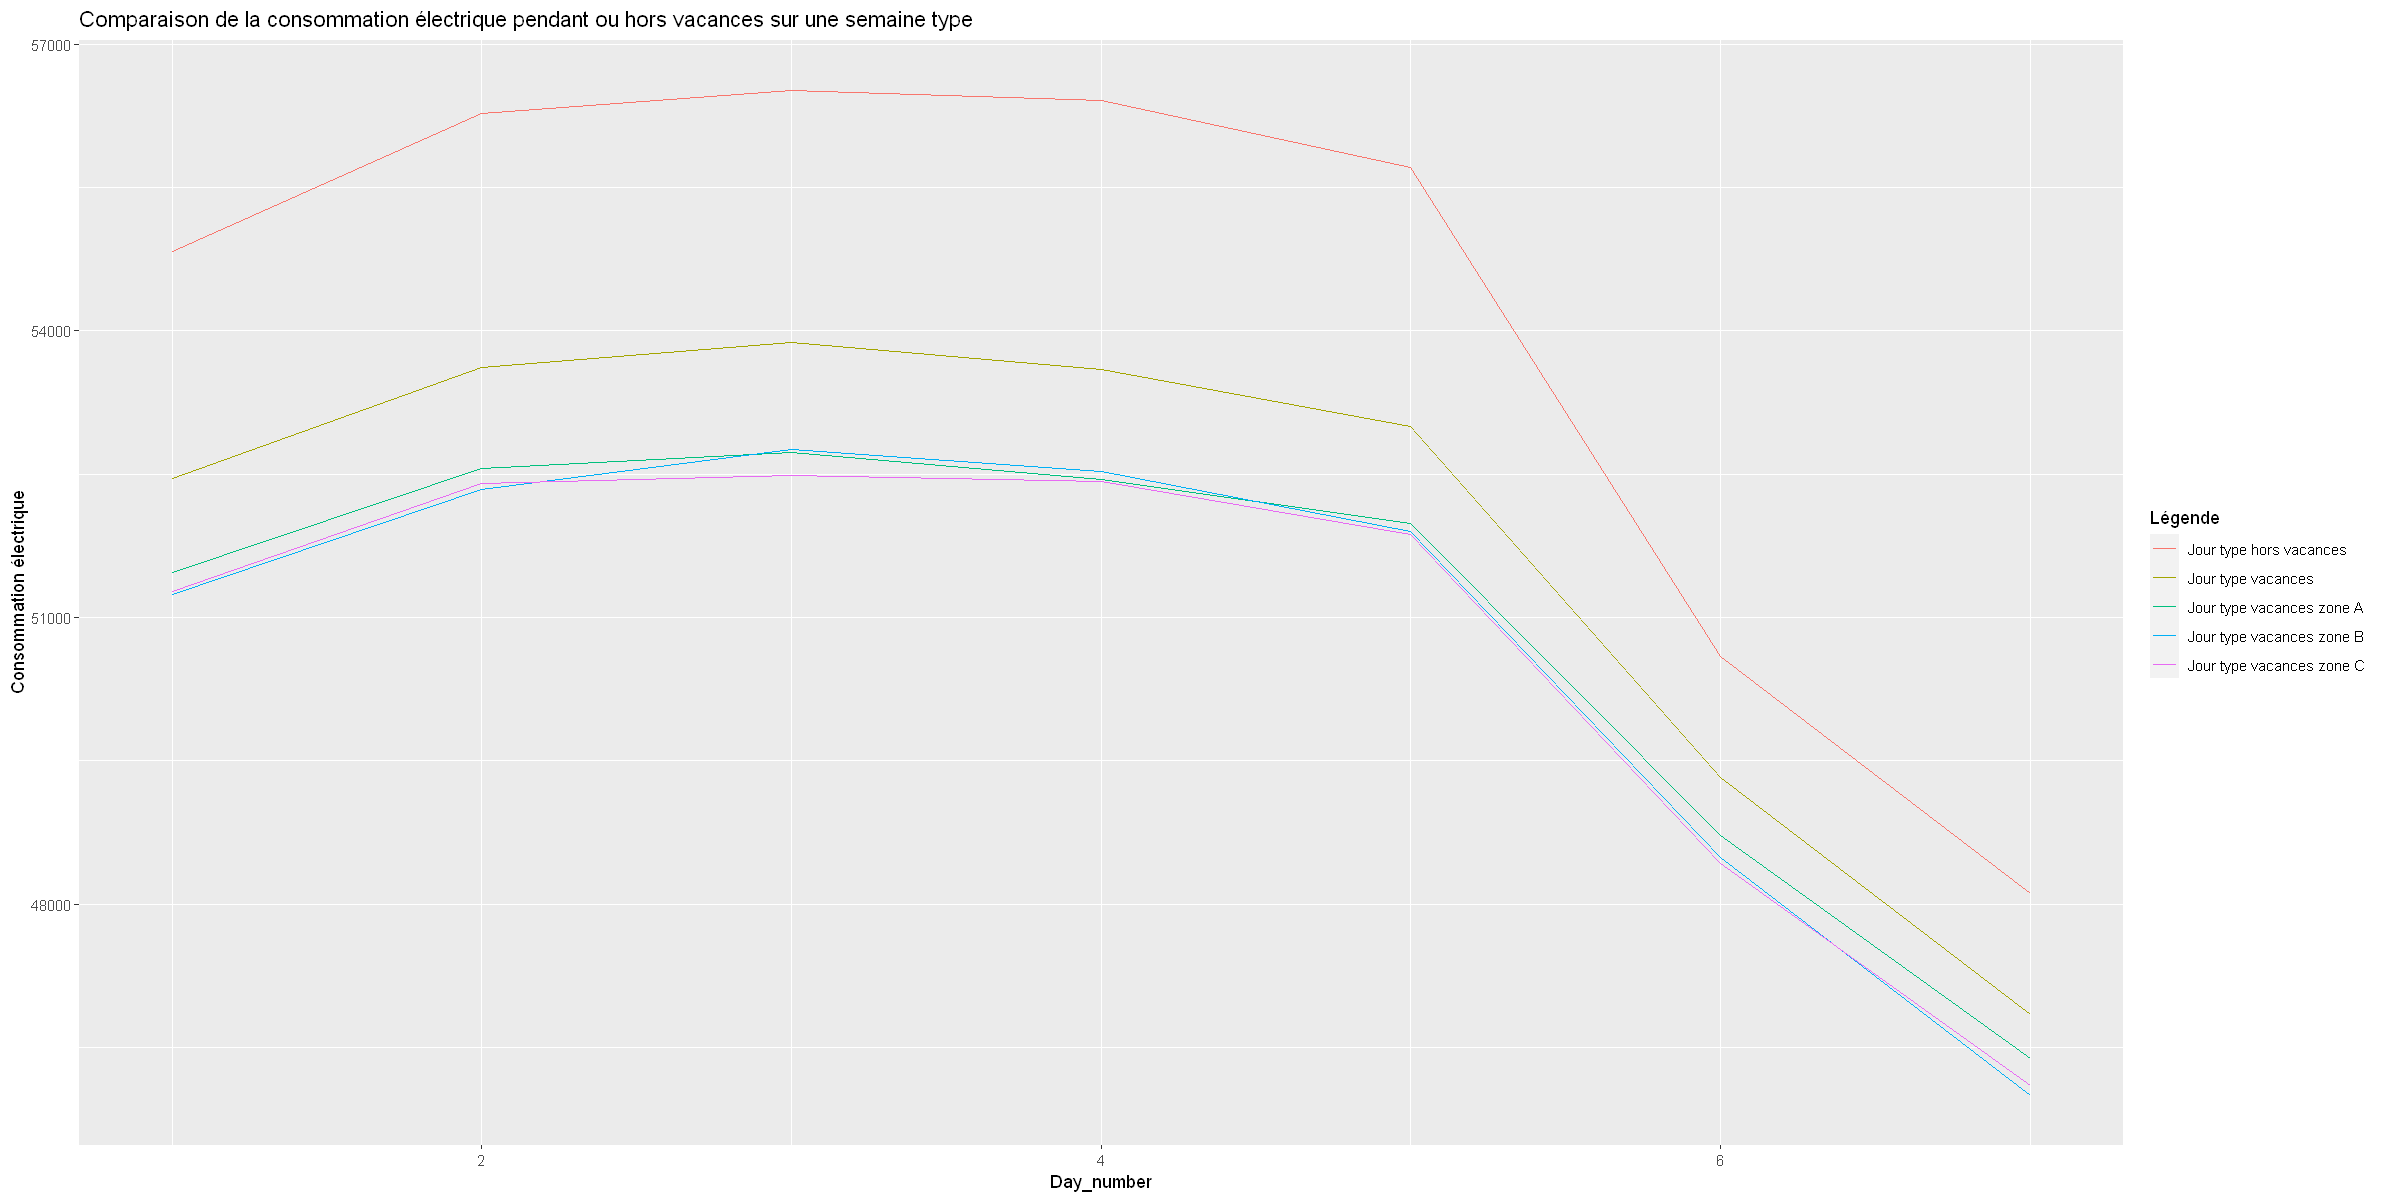

In [67]:
#Représentations graphiques de la consommation électrique hors vacances, et en vacances selon les zones A, B ou C
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_day_type, aes(x=Day_number, y=Consumption, group = 1, color = 'Jour type hors vacances')) + 
    geom_line() +
    geom_line(aes(x=Day_number, y=Consumption_A, colour = 'Jour type vacances zone A')) +
    geom_line(aes(x=Day_number, y=Consumption_B, colour = 'Jour type vacances zone B')) +
    geom_line(aes(x=Day_number, y=Consumption_C, colour = 'Jour type vacances zone C')) +
    geom_line(aes(x=Day_number, y=Consumption_nozone, colour = 'Jour type vacances')) +
    labs(colour = "Légende") +
    labs(title = "Comparaison de la consommation électrique pendant ou hors vacances sur une semaine type") +
    ylab("Consommation électrique")

Comme on pouvait s'y attendre, la consommation électrique est moindre quand on considère chaque zone de vacances individuellement. La diminution de la consommation électrique lors des vacances est semblable entre les zones.

In [68]:
#Pour calculer la variation observée on crée un jour de vacances type zone B
data_train_holidays_B <- data_train_0 %>%
    group_by(Holidays_B) %>%
    summarise_at(vars("Consumption"), mean)
data_train_holidays_B$growth <- with(data_train_holidays_B, ave(Consumption,
                          FUN=function(x) c(NA, diff(x) / tail(x, -1))))
data_train_holidays_B

Holidays_B,Consumption,growth
<int>,<dbl>,<dbl>
0,55894.67,NA
1,50484.32,-0.107169


Avec plus de précision, on peut donc dire que la consommation électrique diminue en moyenne de 11% environ lors des vacances scolaires.

##### Etudes des jours ouvrables

In [69]:
#Définition jour ouvrable
data_train_0 <- data_train_0 %>%
  mutate(Jour_ouvrable = case_when(
    data_train_0$Holidays == 1 ~ 0,
    data_train_0$jour_ferie != 0 ~ 0,
    data_train_0$Weekday == "lundi" ~ 1,
    data_train_0$Weekday == "mardi" ~ 1,
    data_train_0$Weekday == "mercredi" ~ 1,
    data_train_0$Weekday == "jeudi" ~ 1,
    data_train_0$Weekday == "vendredi" ~ 1,
    data_train_0$Weekday == "samedi" ~ 0,
    data_train_0$Weekday == "dimanche" ~ 0,
    ))

#Création d'un jour ouvrable type: aggréation par jour ouvrable
data_train_0_jour_ouvrable <- data_train_0 %>%
    group_by(Jour_ouvrable) %>%
    summarise_at(vars("Consumption"), mean)

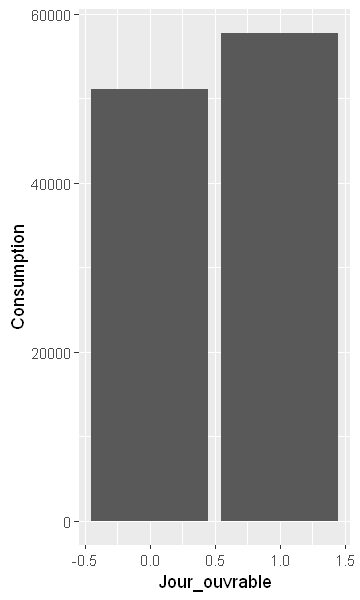

In [70]:
#Consommations électriques cumulées par jour ouvrables entre 2012 et 2020
options(repr.plot.width=3, repr.plot.height=5)
ggplot(data=data_train_0_jour_ouvrable, aes(x=Jour_ouvrable, y=Consumption)) + geom_bar(stat="identity")

In [71]:
#Calcul de la variation observée
data_train_0_jour_ouvrable$growth <- with(data_train_0_jour_ouvrable, ave(Consumption,
                          FUN=function(x) c(NA, diff(x) / tail(x, -1))))
data_train_0_jour_ouvrable

Jour_ouvrable,Consumption,growth
<dbl>,<dbl>,<dbl>
0,51132.21,NA
1,57733.08,0.1143342


En moyenne, la consommation électrique est supérieure de 11% environ en jour ouvrable.

###### Etude de l'activité économique

In [72]:
#Téléchargement d'un indice de production industrielle sur le site de l'INSEE
prod_ind <- read.csv("indice_production_industrielle.csv", sep= ";")
prod_ind <- subset(prod_ind, select=c(1,2))
colnames(prod_ind) <- c("Date","Indice_prod")
prod_ind$Year <- substr(prod_ind$Date,1,4)
prod_ind$Month <- substr(prod_ind$Date,6,7)
prod_ind = subset(prod_ind, select = -c(Date) )

In [73]:
#Création d'une base de données avec une ligne par mois (consommations électriques sommées), pour éviter d'avoir des données dupliquées
data_train_0_month_mean <- data_train_0 %>%
    group_by(Year,Month) %>%
    summarise_at(vars("Consumption"), sum)

#Fusion des 2 bases
data_train_0_month_mean = left_join(data_train_0_month_mean, prod_ind ,c("Year","Month"))

#Consommation et indice de production normalisés
data_train_0_month_mean$Indice_prod_normalized <- (data_train_0_month_mean$Indice_prod - mean(data_train_0_month_mean$Indice_prod)) / sd(data_train_0_month_mean$Indice_prod)
data_train_0_month_mean$Consumption_normalized <- (data_train_0_month_mean$Consumption - mean(data_train_0_month_mean$Consumption)) / sd(data_train_0_month_mean$Consumption)

In [74]:
#Ajout d'une variable Date
data_train_0_month_mean$Date <- paste(data_train_0_month_mean$Year, data_train_0_month_mean$Month, sep="-")
data_train_0_month_mean$Date <- paste0(data_train_0_month_mean$Date,'-01')
data_train_0_month_mean$Date <- as.Date(data_train_0_month_mean$Date, format = "%Y-%m-%d")

`geom_smooth()` using formula 'y ~ x'



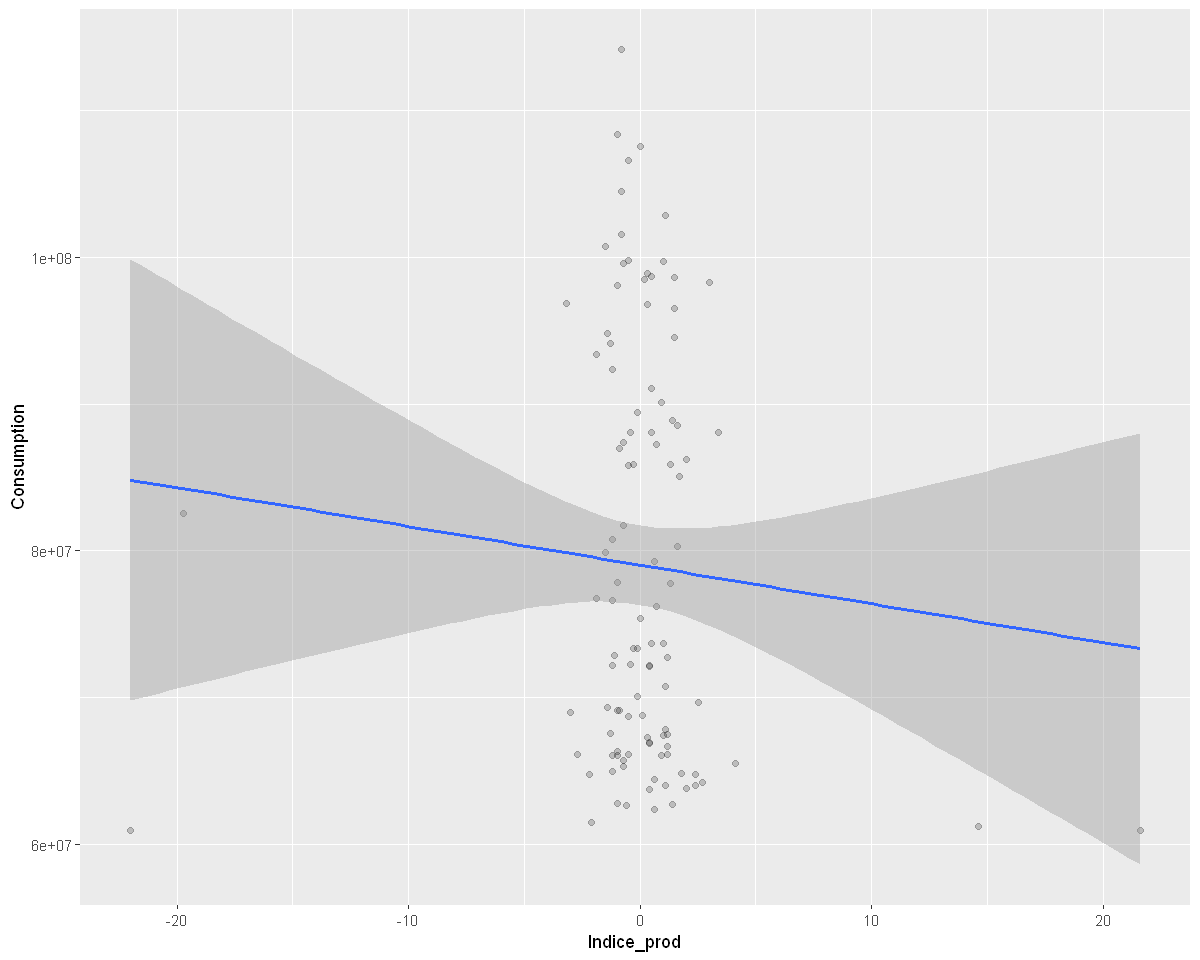

In [75]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train_0_month_mean, aes(x = Indice_prod, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")
#Faible corrélation négative

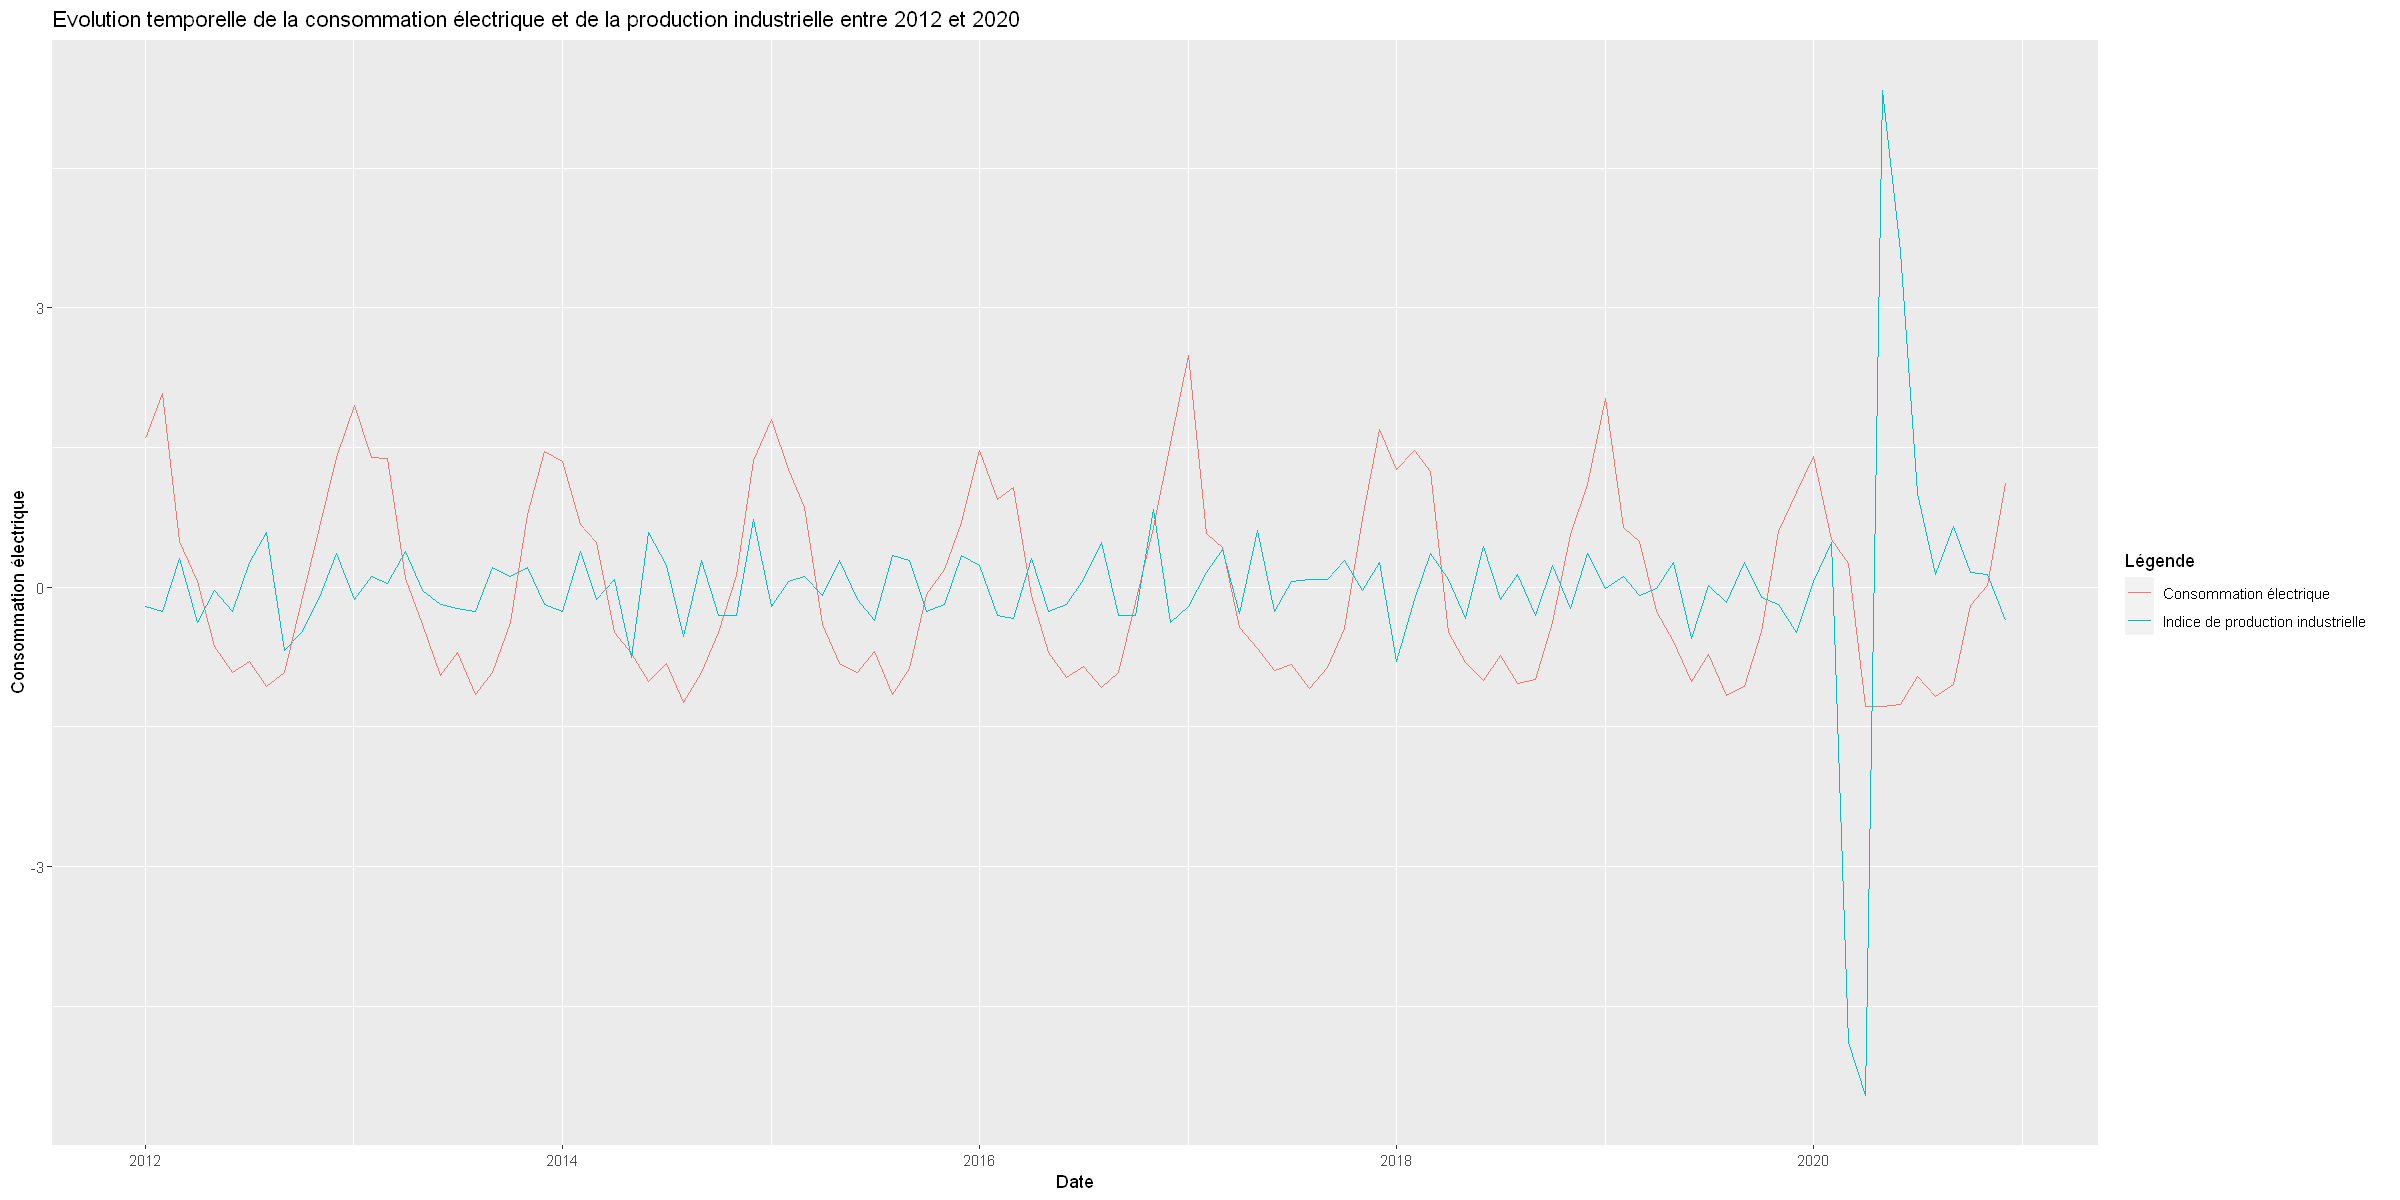

In [76]:
#Représentations graphiques de l'évolution temporelle de la consommmation électrique et de la représentation industrielle
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_month_mean, aes(x=Date, y=Consumption_normalized, group = 1, color = 'Consommation électrique')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Indice_prod_normalized, colour = 'Indice de production industrielle')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle de la consommation électrique et de la production industrielle entre 2012 et 2020") +
    ylab("Consommation électrique")

Nous n'observons pas de corrélation particulière entre la consommation électrique et la production industrielle, et donc avec l'activité économique.

###### Etude des événements exceptionnels

Par exemple, étudions l'incidence du covid sur l'année 2020, par rapport aux années antérieures

In [77]:
#Création d'une année type avec données entre 2012 et 2019
data_train_no2020 <- subset(data_train_0, Year!=2020)
data_train_no2020 <- data_train_no2020 %>% group_by(Day,Month) %>%  summarise_at(vars("Consumption"), mean)
data_train_no2020 = rename(data_train_no2020, Consumption_no2020 = Consumption)

#Base de données 2020
data_train_2020 <- subset(data_train_0, Year==2020)
data_train_2020 <- data_train_2020 %>% group_by(Day,Month) %>%  summarise_at(vars("Consumption"), mean)
data_train_2020 = rename(data_train_2020, Consumption_2020 = Consumption)

#Fusion des 2 bases pour réaliser le graphique
data_train_ev_ex <- left_join(data_train_no2020,data_train_2020, by=c("Day","Month"))

data_train_ev_ex$Date = paste(data_train_ev_ex$Month, data_train_ev_ex$Day, sep="-")
data_train_ev_ex$Date = as.Date(data_train_ev_ex$Date, format = "%m-%d")
data_train_ev_ex <- data_train_ev_ex %>% select(Date, everything())
data_train_ev_ex <- data_train_ev_ex %>% drop_na()

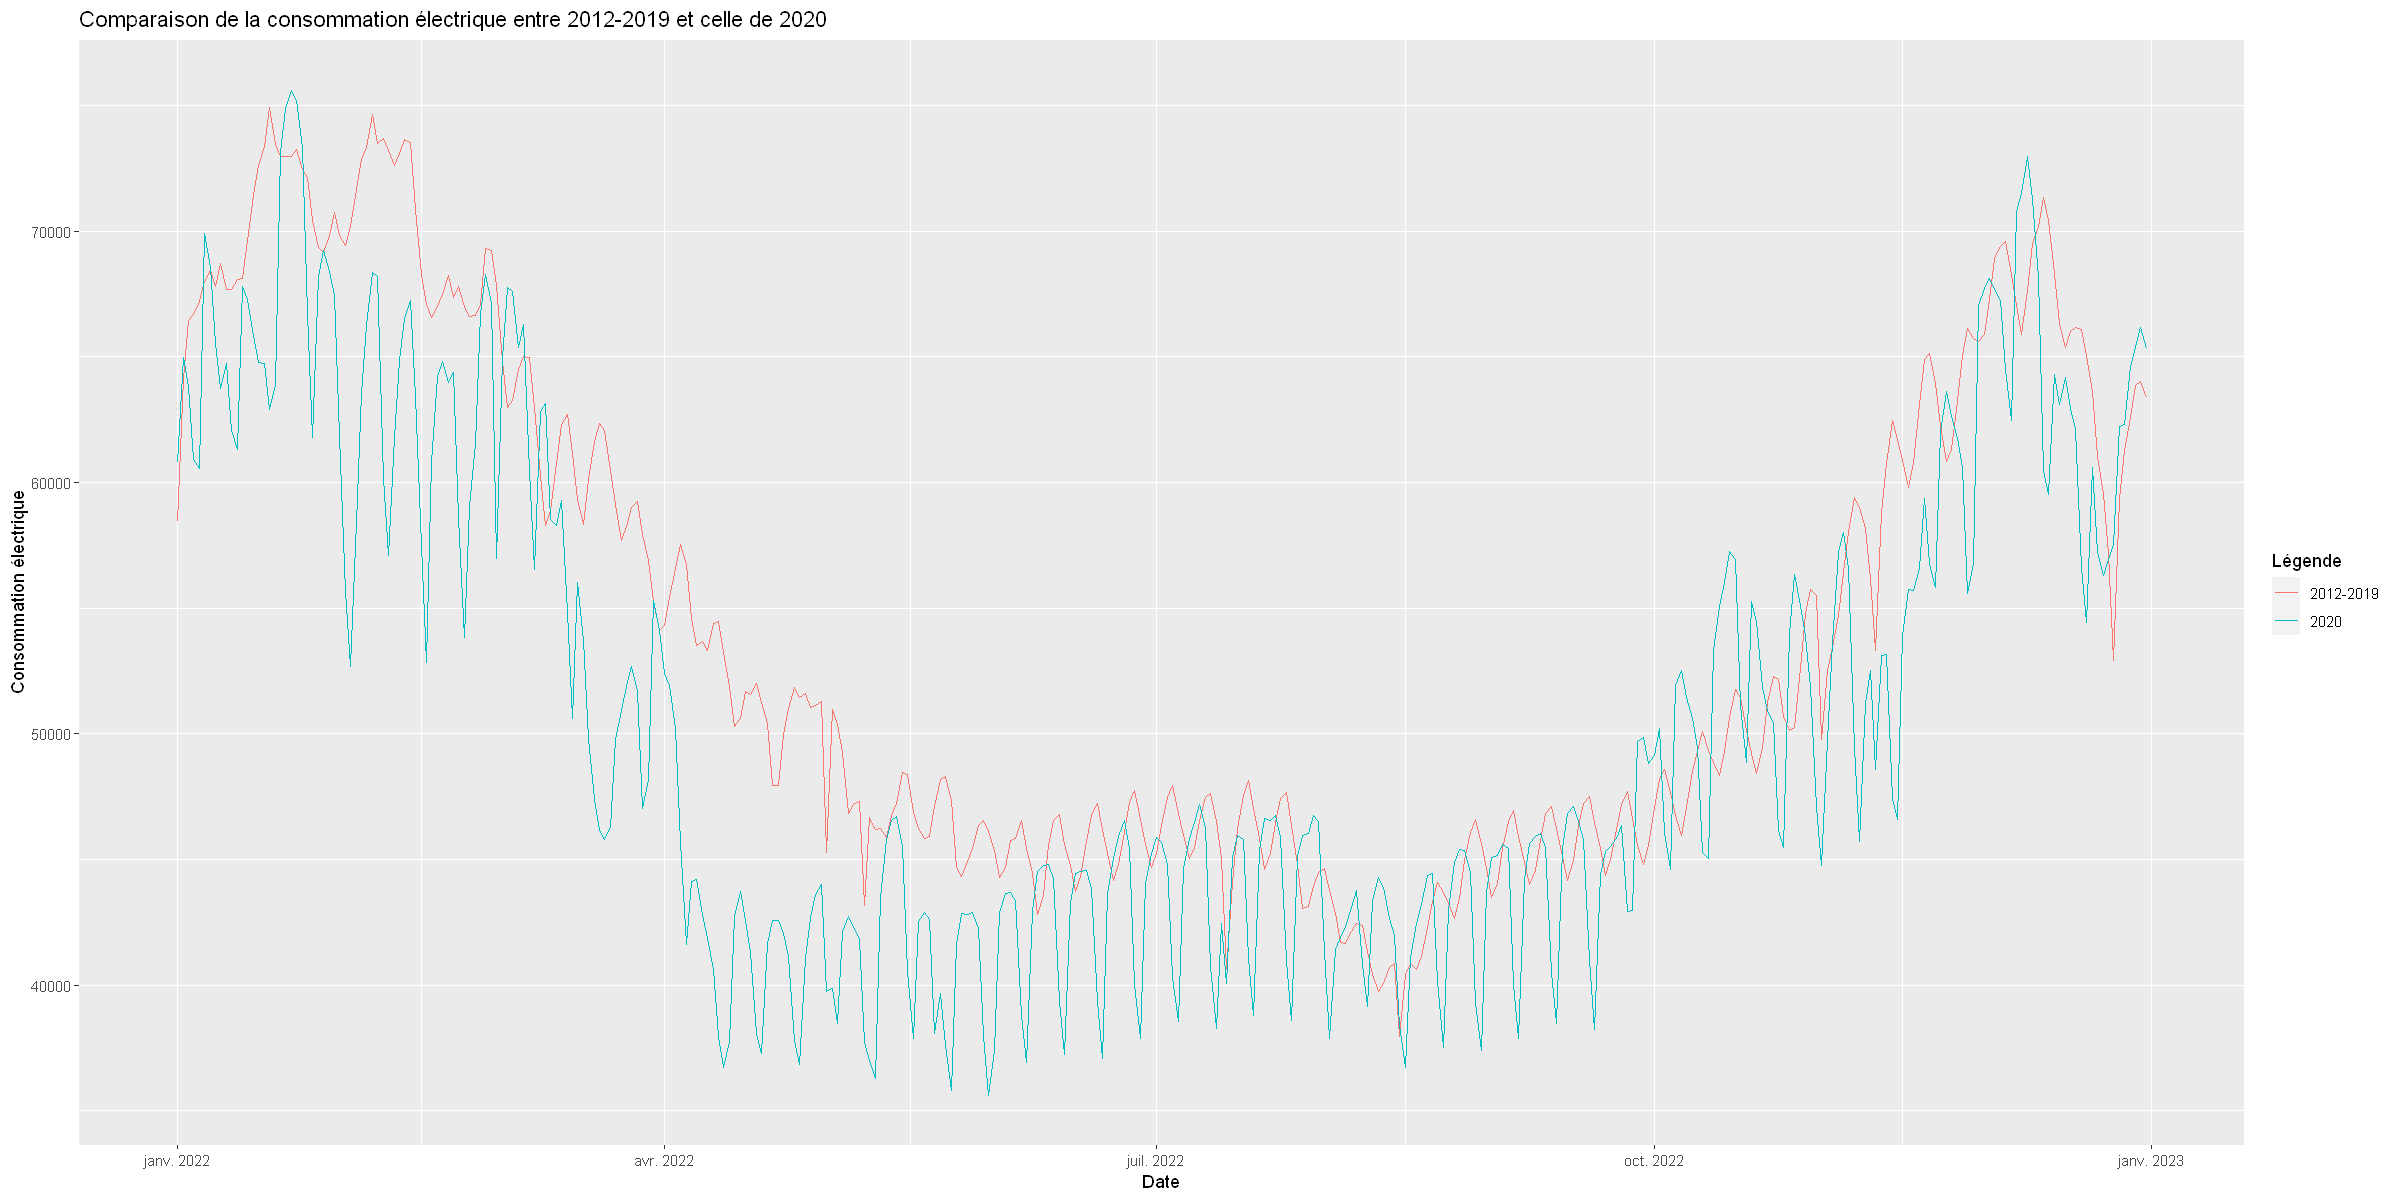

In [78]:
#Représentation graphique de la consommmation électrique en 2020, par rapport à la consommation électrique moyenne des autres années (2012-2019)
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_ev_ex, aes(x=Date, y=Consumption_no2020, group = 1, color = '2012-2019')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_2020, colour = '2020')) +
    labs(colour = "Légende") +
    labs(title = "Comparaison de la consommation électrique entre 2012-2019 et celle de 2020") +
    ylab("Consommation électrique")

On remarque nettement une forte diminution de la consommation électrique en 2020 par rapport à la moyenne 2012-2019 à partir de mars 2020 et puis un "retour à la normal" à partir de juin-juillet 2020

##### Température lissée et retardée

In [121]:
#Température lissée
alpha = 0.1
n = nrow(data_train_1)
data_train_1$Temperature_lissee[1] <- data_train_1$Temperature[1]
for (i in 2:n) {
     data_train_1$Temperature_lissee[i] <- alpha*data_train_1$Temperature[i]+(1-alpha)*data_train_1$Temperature_lissee[i-1]
}

`geom_smooth()` using formula 'y ~ x'



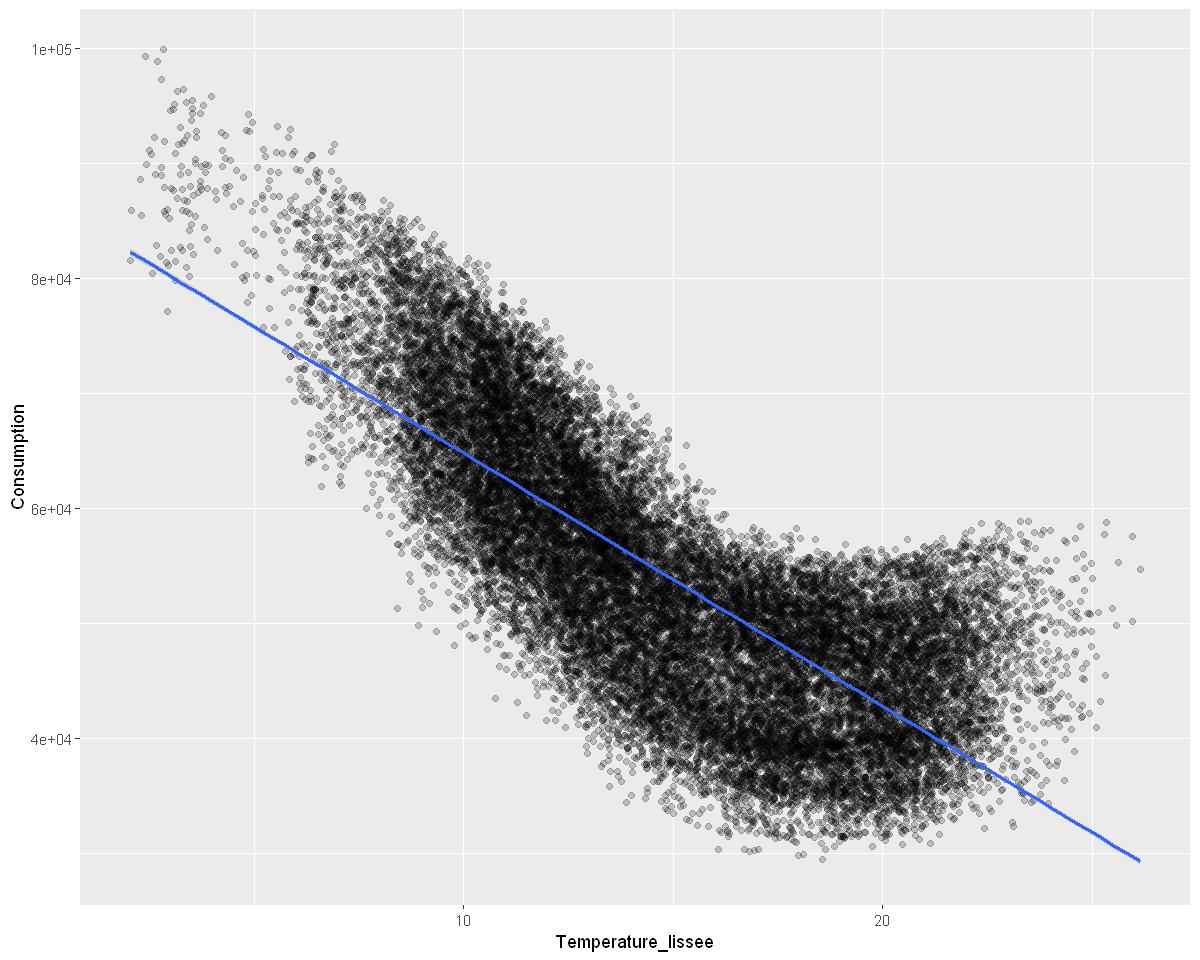

In [109]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train_1, aes(x = Temperature_lissee, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")
#Corrélation négative

In [91]:
#Température retardée: prenons un retard d'un jour
n = nrow(data_train_1)
data_train_1$Temperature_retardee <- 0
for (i in 1:8) {
    data_train_1$Temperature_retardee[i] <- data_train_1$Temperature[i]
}
for (i in 9:n){
    data_train_1$Temperature_retardee[i] <- data_train_1$Temperature[i]-data_train_1$Temperature[i-8]
}

`geom_smooth()` using formula 'y ~ x'



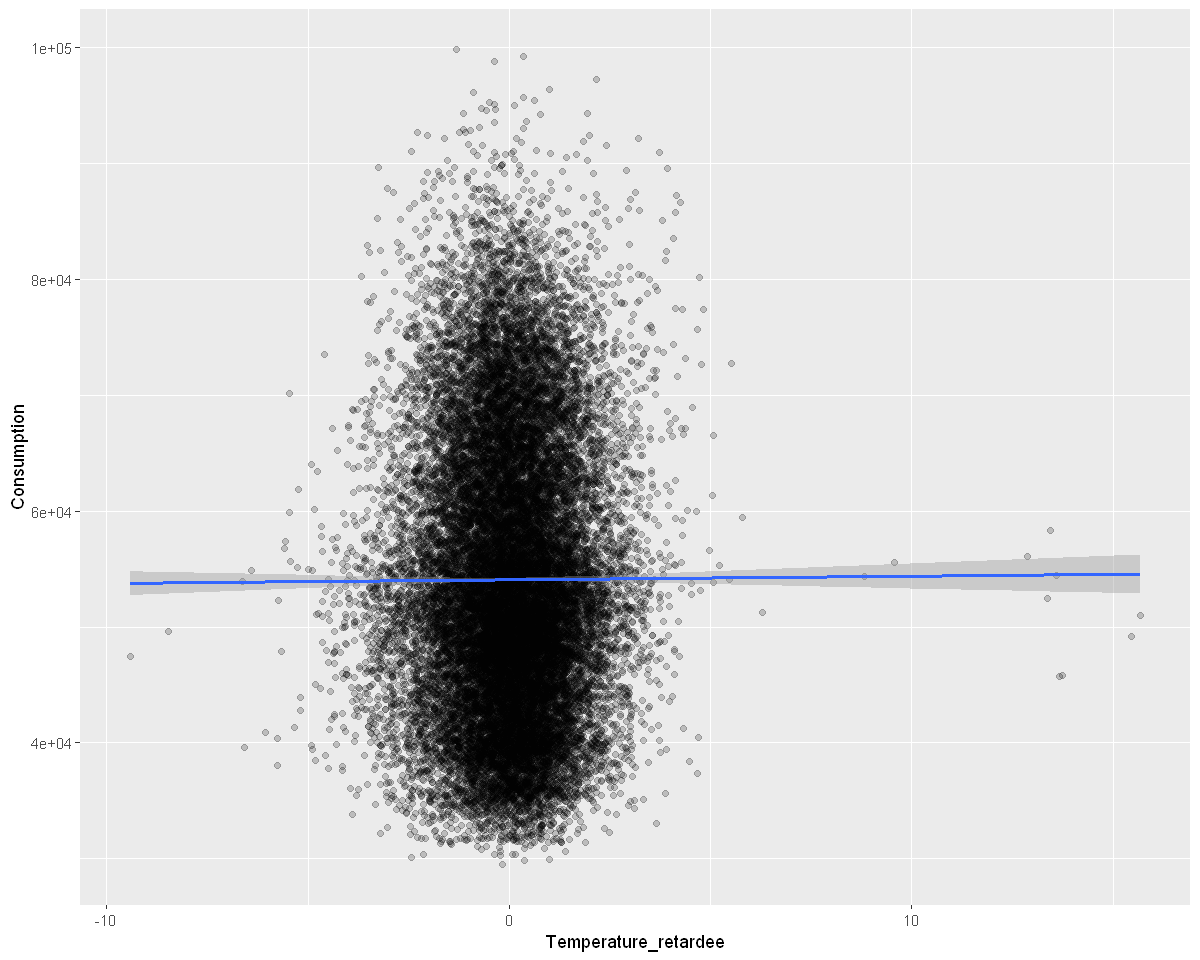

In [92]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train_1, aes(x = Temperature_retardee, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")
#Pas de corrélation visible

### Modèles GAM

In [22]:
library(mgcv)
library(mgcViz)
library(visreg)

Warning message:
"le package 'mgcv' a été compilé avec la version R 4.1.3"
Le chargement a nécessité le package : nlme

Warning message:
"le package 'nlme' a été compilé avec la version R 4.1.3"

Attachement du package : 'nlme'


L'objet suivant est masqué depuis 'package:dplyr':

    collapse


This is mgcv 1.8-39. For overview type 'help("mgcv-package")'.

Warning message:
"le package 'mgcViz' a été compilé avec la version R 4.1.3"
Le chargement a nécessité le package : qgam

Warning message:
"le package 'qgam' a été compilé avec la version R 4.1.3"
Le chargement a nécessité le package : ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registered S3 method overwritten by 'mgcViz':
  method from  
  +.gg   GGally


Attachement du package : 'mgcViz'


Les objets suivants sont masqués depuis 'package:stats':

    qqline, qqnorm, qqplot


Warning message:
"le package 'visreg' a été compilé avec la version R 4.1.3"


In [23]:
#Année, Mois et Jour sous format numérique
data_train$Year <- as.integer(data_train$Year)
data_train$Month <- as.integer(data_train$Month)
data_train$Day <- as.integer(data_train$Day)

data_test$Year <- as.integer(data_test$Year)
data_test$Month <- as.integer(data_test$Month)
data_test$Day <- as.integer(data_test$Day)

data_train_1$Year <- as.integer(data_train_1$Year)
data_train_1$Month <- as.integer(data_train_1$Month)
data_train_1$Day <- as.integer(data_train_1$Day)

data_test_1$Year <- as.integer(data_test_1$Year)
data_test_1$Month <- as.integer(data_test_1$Month)
data_test_1$Day <- as.integer(data_test_1$Day)

In [24]:
#Création de la variable Position dans l'année
jours_année <- data.table(data_train_1)[ , .(jours = length(unique(Date))), by = Year]
jours_mois <- data.table(data_train_1)[ , .(jours = length(unique(Day))), by = Month]
for (i in 2012:2020){
    l=0
    nb_jours_annee = jours_année$jours[jours_année$Year==i]
    for (j in 1:12){
        nb_jours_mois = jours_mois$jours[jours_mois$Month==j]
        for (k in 1:nb_jours_mois){
            data_train_1$Position_year[data_train_1$Year==i & data_train_1$Month==j & data_train_1$Day==k] <- l
            l=l+(1/nb_jours_annee)
        }
    }
}

jours_année <- data.table(data_train)[ , .(jours = length(unique(Date))), by = Year]
jours_mois <- data.table(data_train)[ , .(jours = length(unique(Day))), by = Month]
for (i in 2012:2020){
    l=0
    nb_jours_annee = jours_année$jours[jours_année$Year==i]
    for (j in 1:12){
        nb_jours_mois = jours_mois$jours[jours_mois$Month==j]
        for (k in 1:nb_jours_mois){
            data_train$Position_year[data_train$Year==i & data_train$Month==j & data_train$Day==k] <- l
            l=l+(1/nb_jours_annee)
        }
    }
}

In [25]:
jours_année <- data.table(data_test)[ , .(jours = length(unique(Date))), by = Year]
jours_mois <- data.table(data_test)[ , .(jours = length(unique(Day))), by = Month]
for (i in 2021:2021){
    l=0
    nb_jours_annee = jours_année$jours[jours_année$Year==i]
    for (j in 1:12){
        nb_jours_mois = jours_mois$jours[jours_mois$Month==j]
        for (k in 1:nb_jours_mois){
            data_test$Position_year[data_test$Year==i & data_test$Month==j & data_test$Day==k] <- l
            l=l+(1/nb_jours_annee)
        }
    }
}

jours_année <- data.table(data_test_1)[ , .(jours = length(unique(Date))), by = Year]
jours_mois <- data.table(data_test_1)[ , .(jours = length(unique(Day))), by = Month]
for (i in 2021:2021){
    l=0
    nb_jours_annee = jours_année$jours[jours_année$Year==i]
    for (j in 1:12){
        nb_jours_mois = jours_mois$jours[jours_mois$Month==j]
        for (k in 1:nb_jours_mois){
            data_test_1$Position_year[data_test_1$Year==i & data_test_1$Month==j & data_test_1$Day==k] <- l
            l=l+(1/nb_jours_annee)
        }
    }
}

In [26]:
#Check valeurs NA
sum(is.na(data_train$Position_year)) ; sum(is.na(data_test$Position_year))
sum(is.na(data_train_1$Position_year)) ; sum(is.na(data_test_1$Position_year))

[1] 0

[1] 0

[1] 0

[1] 0

In [27]:
#Définition Day_number comme dans les Statistiques Descriptives
data_train <- data_train %>%
  mutate(Day_number = case_when(
    data_train$Weekday == "lundi" ~ 1,
    data_train$Weekday == "mardi" ~ 2,
    data_train$Weekday == "mercredi" ~ 3,
    data_train$Weekday == "jeudi" ~ 4,
    data_train$Weekday == "vendredi" ~ 5,
    data_train$Weekday == "samedi" ~ 6,
    data_train$Weekday == "dimanche" ~ 7,
    ))
data_test <- data_test %>%
  mutate(Day_number = case_when(
    data_test$Weekday == "lundi" ~ 1,
    data_test$Weekday == "mardi" ~ 2,
    data_test$Weekday == "mercredi" ~ 3,
    data_test$Weekday == "jeudi" ~ 4,
    data_test$Weekday == "vendredi" ~ 5,
    data_test$Weekday == "samedi" ~ 6,
    data_test$Weekday == "dimanche" ~ 7,
    ))

data_train_1 <- data_train_1 %>%
  mutate(Day_number = case_when(
    data_train_1$Weekday == "lundi" ~ 1,
    data_train_1$Weekday == "mardi" ~ 2,
    data_train_1$Weekday == "mercredi" ~ 3,
    data_train_1$Weekday == "jeudi" ~ 4,
    data_train_1$Weekday == "vendredi" ~ 5,
    data_train_1$Weekday == "samedi" ~ 6,
    data_train_1$Weekday == "dimanche" ~ 7,
    ))
data_test_1 <- data_test_1 %>%
  mutate(Day_number = case_when(
    data_test_1$Weekday == "lundi" ~ 1,
    data_test_1$Weekday == "mardi" ~ 2,
    data_test_1$Weekday == "mercredi" ~ 3,
    data_test_1$Weekday == "jeudi" ~ 4,
    data_test_1$Weekday == "vendredi" ~ 5,
    data_test_1$Weekday == "samedi" ~ 6,
    data_test_1$Weekday == "dimanche" ~ 7,
    ))

data_train$Day_number <- as.integer(data_train$Day_number)
data_test$Day_number <- as.integer(data_test$Day_number)
data_train_1$Day_number <- as.integer(data_train_1$Day_number)
data_test_1$Day_number <- as.integer(data_test_1$Day_number)

In [28]:
#Création d'une variable Time en nombre entier
data_train$Time_hour <- as.integer(substr(data_train$Time,1,2))
data_train$Time_minutes <- as.double(substr(data_train$Time,4,5))/60
data_train$Time_number <- as.double(data_train$Time_hour + data_train$Time_minutes)
data_train <- subset(data_train,select=-c(Time_hour, Time_minutes))

data_test$Time_hour <- as.integer(substr(data_test$Time,1,2))
data_test$Time_minutes <- as.double(substr(data_test$Time,4,5))/60
data_test$Time_number <- as.double(data_test$Time_hour + data_test$Time_minutes)
data_test <- subset(data_test,select=-c(Time_hour, Time_minutes))

data_train_1$Time_hour <- as.integer(substr(data_train_1$Time,1,2))
data_train_1$Time_minutes <- as.double(substr(data_train_1$Time,4,5))/60
data_train_1$Time_number <- as.double(data_train_1$Time_hour + data_train_1$Time_minutes)
data_train_1 <- subset(data_train_1,select=-c(Time_hour, Time_minutes))

data_test_1$Time_hour <- as.integer(substr(data_test_1$Time,1,2))
data_test_1$Time_minutes <- as.double(substr(data_test_1$Time,4,5))/60
data_test_1$Time_number <- as.double(data_test_1$Time_hour + data_test_1$Time_minutes)
data_test_1 <- subset(data_test_1,select=-c(Time_hour, Time_minutes))

In [29]:
#Création d'une dummy jour férié
data_train <- data_train %>%
  mutate(jour_ferie = case_when(
    data_train$jour_ferie == 0 ~ 0,
    data_train$jour_ferie != 0 ~ 1,
    ))

data_test <- data_test %>%
  mutate(jour_ferie = case_when(
    data_test$jour_ferie == 0 ~ 0,
    data_test$jour_ferie != 0 ~ 1,
    ))

data_train_1 <- data_train_1 %>%
  mutate(jour_ferie = case_when(
    data_train_1$jour_ferie == 0 ~ 0,
    data_train_1$jour_ferie != 0 ~ 1,
    ))

data_test_1 <- data_test_1 %>%
  mutate(jour_ferie = case_when(
    data_test_1$jour_ferie == 0 ~ 0,
    data_test_1$jour_ferie != 0 ~ 1,
    ))

In [123]:
#Régression linéaire
mod_lm <- lm(Consumption ~ Temperature + Humidity + Nebulosity + Position_year + Day_number + Time_number + jour_ferie + Holidays, data=data_train_1)
summary(mod_lm)


Call:
lm(formula = Consumption ~ Temperature + Humidity + Nebulosity + 
    Position_year + Day_number + Time_number + jour_ferie + Holidays, 
    data = data_train_1)

Residuals:
     Min       1Q   Median       3Q      Max 
-26521.4  -5401.5     36.7   5398.3  25890.5 

Coefficients:
                Estimate Std. Error  t value Pr(>|t|)    
(Intercept)   122386.536    690.534  177.235  < 2e-16 ***
Temperature    -2164.005     13.638 -158.670  < 2e-16 ***
Humidity        -574.749      7.598  -75.644  < 2e-16 ***
Nebulosity       116.956      3.228   36.229  < 2e-16 ***
Position_year    262.653    176.719    1.486    0.137    
Day_number     -1092.406     23.771  -45.955  < 2e-16 ***
Time_number      292.587      7.889   37.089  < 2e-16 ***
jour_ferie     -7825.468    278.649  -28.084  < 2e-16 ***
Holidays        -776.210     99.498   -7.801 6.35e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7678 on 26277 degrees of freedom
Multip

Toutes les variables sont significatives au seuil de 1% sauf la variable Position_year

In [113]:
#Modèle GAM
mod_gam <- gam(Consumption ~ s(Temperature, bs="cr", k=6) +  
                              s(Humidity, bs="cr", k=6) + 
                              s(Nebulosity, bs="cr", k=6) + 
                              s(Position_year, bs="cc",k=6) +  
                              as.factor(Day_number) + 
                              as.factor(Time_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays), 
                data=data_train_1)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 12 iterations.
The RMS GCV score gradient at convergence was 1.741438 .
The Hessian was positive definite.
Model rank =  40 / 40 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                        k'  edf k-index p-value    
s(Temperature)        5.00 4.55    0.98   0.055 .  
s(Temperature_lissee) 5.00 4.96    0.99   0.305    
s(Humidity)           5.00 4.76    1.01   0.710    
s(Nebulosity)         5.00 4.73    1.00   0.420    
s(Position_year)      4.00 3.98    0.81  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
12.3  total = 13.3 

GCV score: 9876069     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
27.6  total = 28.57 

GCV score: 9835095     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9876735     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9876735     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Position_year, k = 40)

Estimated degrees of freedom:
36.1  total = 37.12 

GCV score: 8328706     

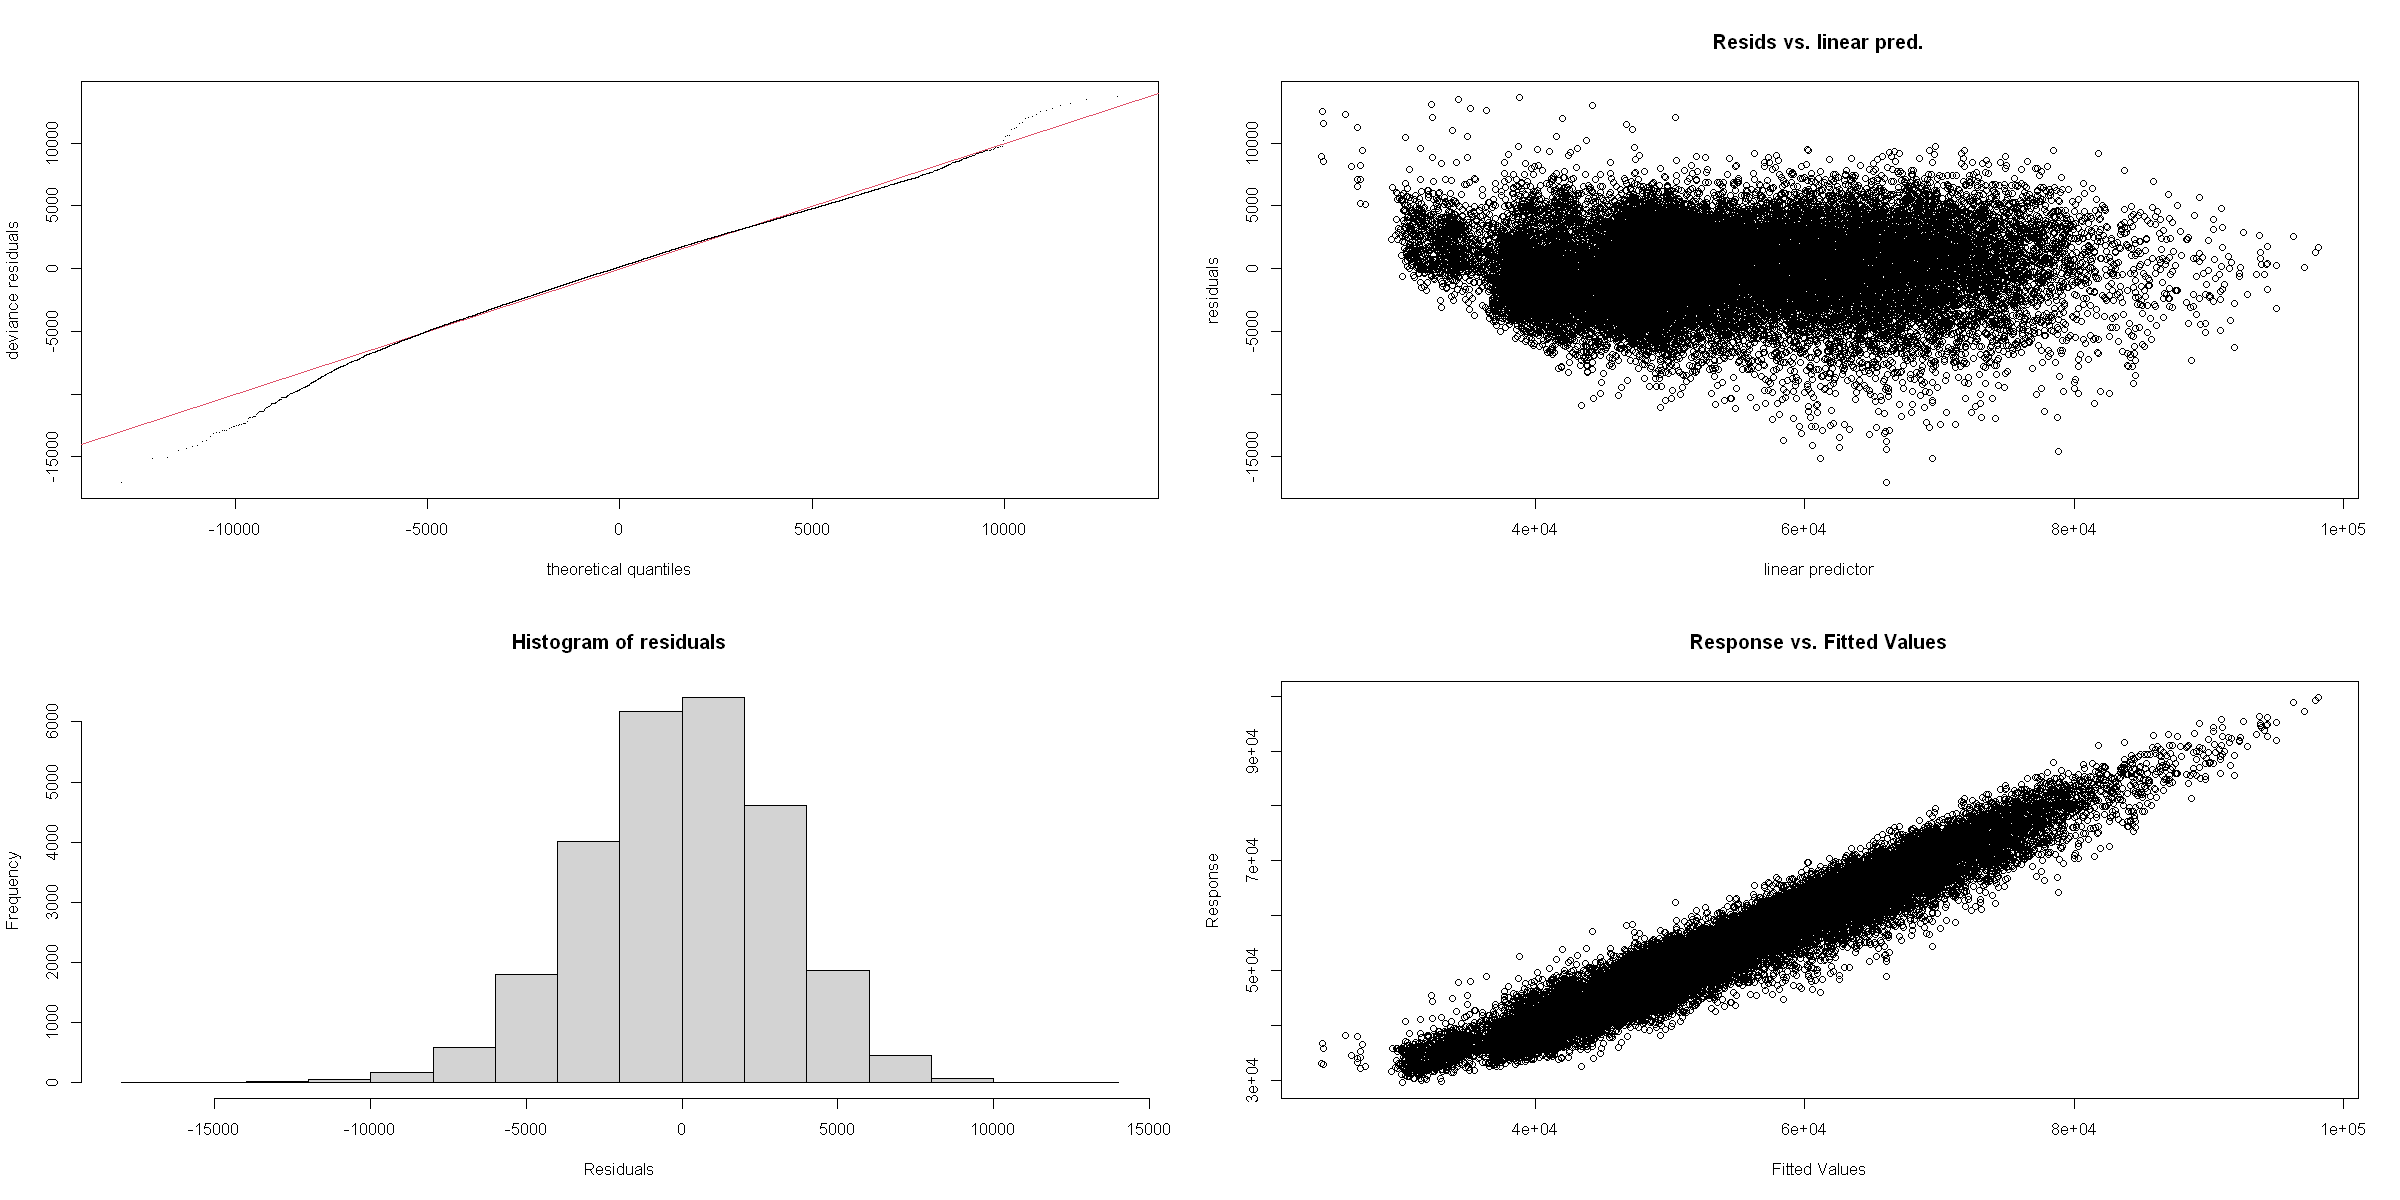

In [114]:
#Vérification du nombre de noeuds k
gam.check(mod_gam)
gam(residuals(mod_gam)~s(Temperature,k=40),gamma=1.4,data=data_train_1) ## k trop petit
gam(residuals(mod_gam)~s(Humidity,k=40),gamma=1.4,data=data_train_1) ## ok
gam(residuals(mod_gam)~s(Nebulosity,k=40),gamma=1.4,data=data_train_1) ## ok
gam(residuals(mod_gam)~s(Position_year,k=40),gamma=1.4,data=data_train_1) ## k trop petit

In [124]:
#Augmentation des noeuds k pour Position_year, Temperature, Nebulosity
mod_gam <- gam(Consumption ~ s(Temperature, bs="cr", k=12) + 
                              s(Humidity, bs="cr", k=6) + 
                              s(Nebulosity, bs="cr", k=12) +                
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) +
                              as.factor(Time_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays), 
                data=data_train_1)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 8 iterations.
The RMS GCV score gradient at convergence was 4.137676 .
The Hessian was positive definite.
Model rank =  264 / 264 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                          k'    edf k-index p-value  
s(Temperature)         23.00  14.93    1.00   0.355  
s(Temperature_lissee)  11.00  10.45    0.99   0.310  
s(Humidity)             5.00   4.84    1.00   0.525  
s(Nebulosity)          11.00   6.84    1.00   0.520  
s(Position_year)      198.00 127.86    0.97   0.015 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8026671     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8026671     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8026671     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8026671     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Position_year, k = 200)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8026663     

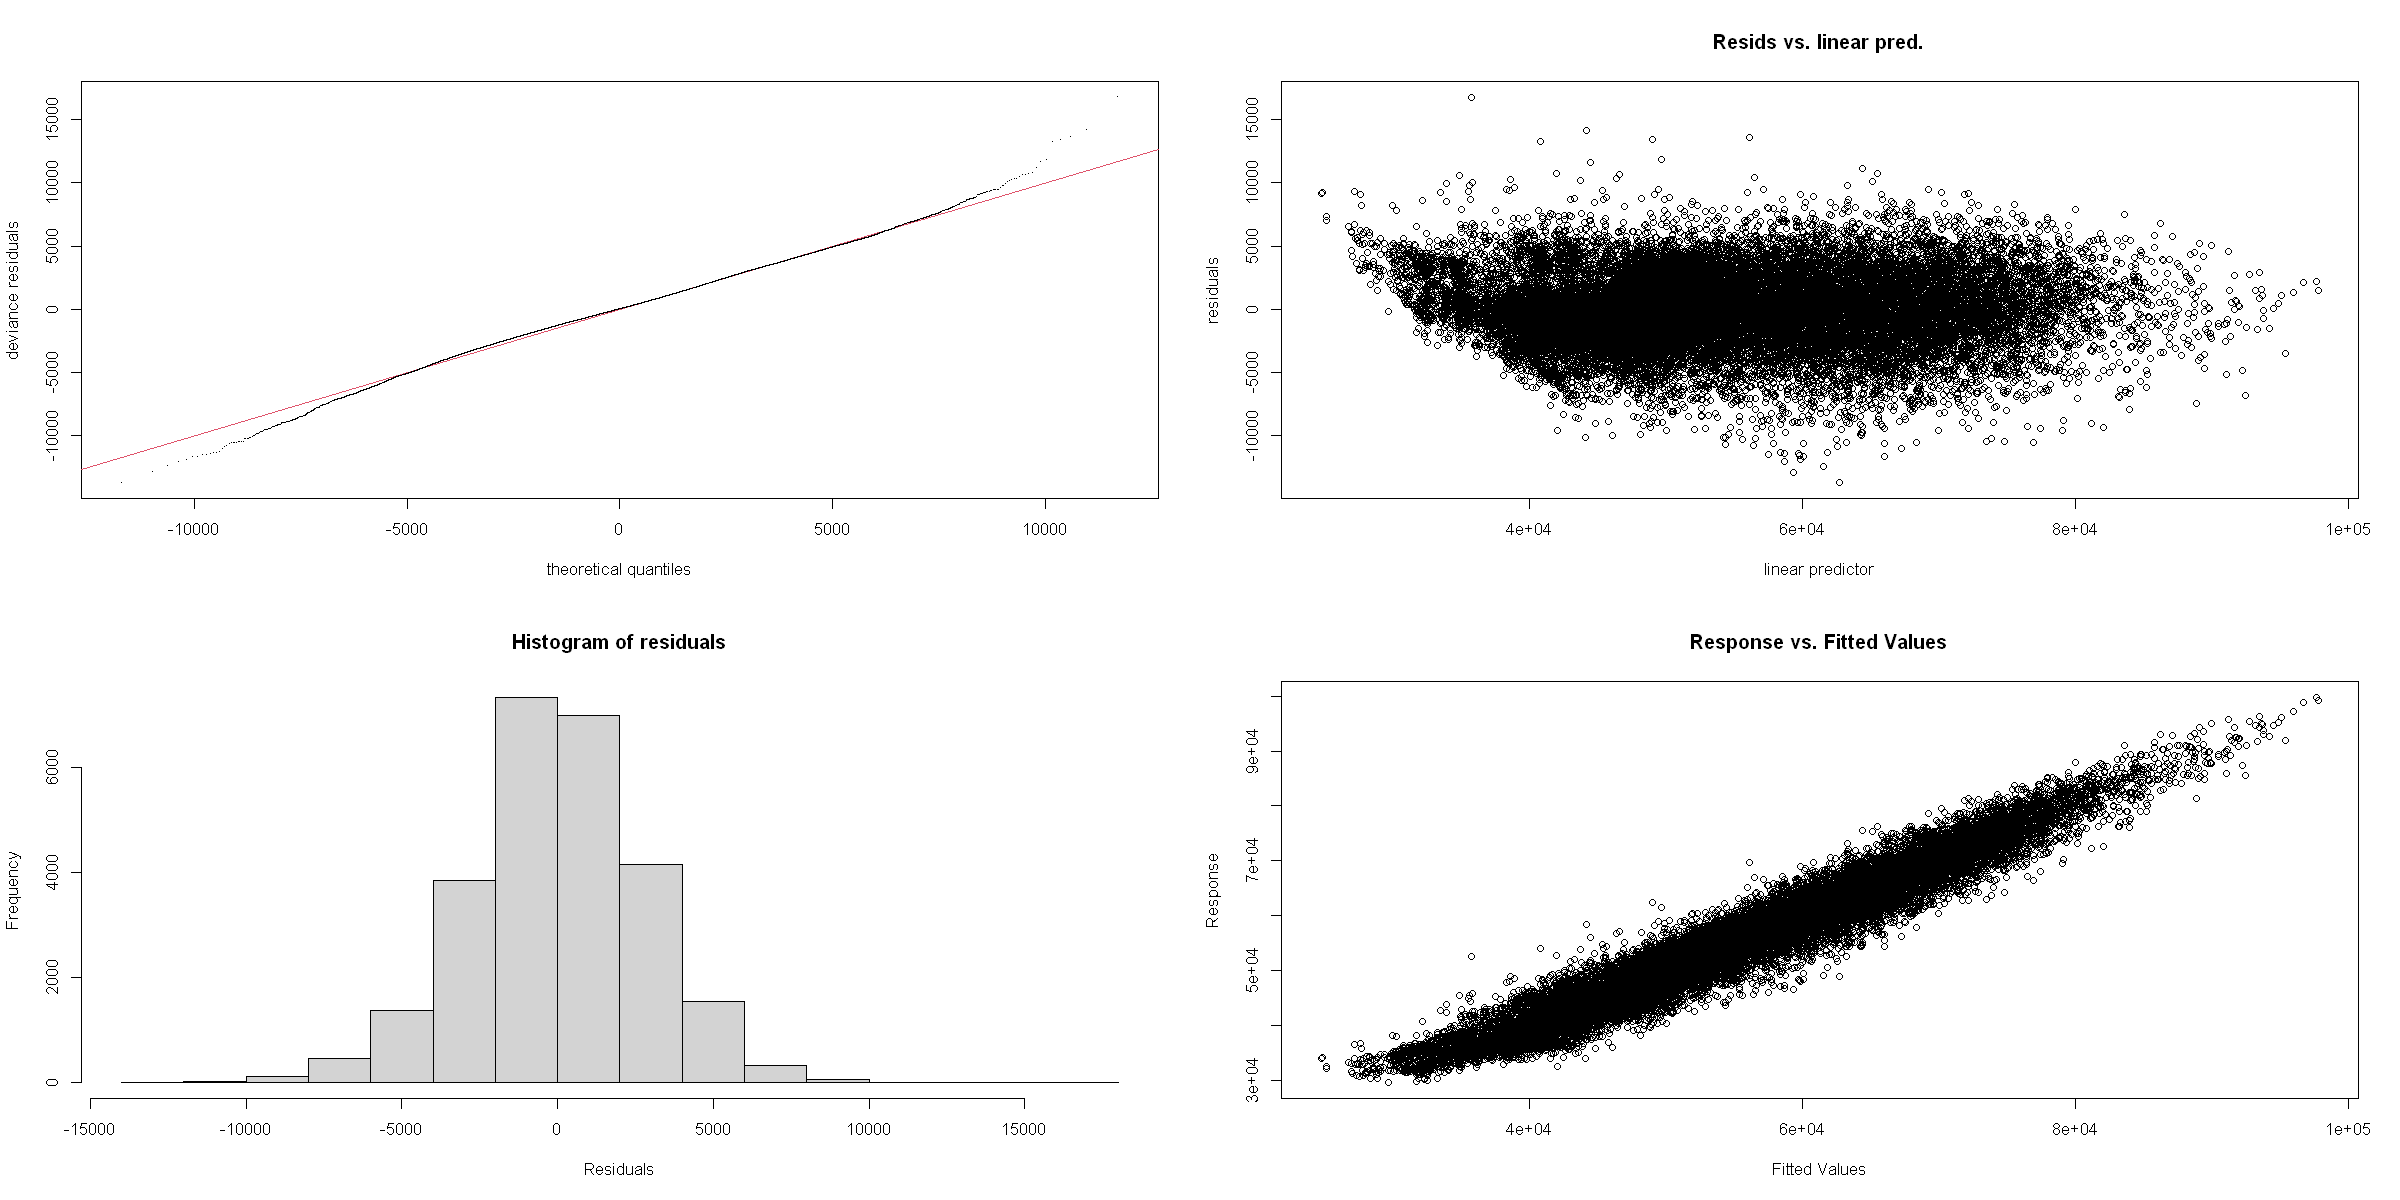

In [118]:
gam.check(mod_gam)
gam(residuals(mod_gam)~s(Temperature,k=40),gamma=1.4,data=data_train_1) ## ok
gam(residuals(mod_gam)~s(Humidity,k=40),gamma=1.4,data=data_train_1) ## ok
gam(residuals(mod_gam)~s(Nebulosity,k=40),gamma=1.4,data=data_train_1) ## ok
gam(residuals(mod_gam)~s(Position_year,k=200),gamma=1.4,data=data_train_1) ## ok

In [125]:
#Prediction
fits = predict(mod_gam, newdata=data_test_1, type='response', se=T)
predicts = data.frame(data_test_1, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
#Comparaison Prédiction - Benchmark
predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
comparison_mod_gam = left_join(predicts,benchmark,c("Date","Time"))
#Calcul MAPE
mean(abs((comparison_mod_gam$Consumption-comparison_mod_gam$fit)/comparison_mod_gam$Consumption)) * 100

[1] 2.63365

Bon résultat. Affinons le en essayant de prédire tous les demi-horaires. Pour cela, nous allons utiliser l'interpolation linéaire pour obtenir les données de Température, Nébulosité et Humidité tous les demi-horaires. Intégrons également la Température lissée.

In [127]:
#Interpolation linéaire 
data_train <- data_train %>%
        mutate(Temperature = as.double(na.approx(data_train$Temperature, na.rm=FALSE)))

data_train <- data_train %>%
        mutate(Nebulosity = as.double(na.approx(data_train$Nebulosity, na.rm=FALSE)))

data_train <- data_train %>%
        mutate(Humidity = as.double(na.approx(data_train$Humidity, na.rm=FALSE)))

data_test <- data_test %>%
        mutate(Temperature = as.double(na.approx(data_test$Temperature, na.rm=FALSE)))

data_test <- data_test %>%
        mutate(Nebulosity = as.double(na.approx(data_test$Nebulosity, na.rm=FALSE)))

data_test <- data_test %>%
        mutate(Humidity = as.double(na.approx(data_test$Humidity, na.rm=FALSE)))

In [128]:
data_train <- data_train %>% drop_na()
data_test <- data_test %>% drop_na()

In [130]:
#Température lissée
alpha = 0.1

n = nrow(data_train)
data_train$Temperature_lissee[1] <- data_train$Temperature[1]
for (i in 2:n) {
     data_train$Temperature_lissee[i] <- alpha*data_train$Temperature[i]+(1-alpha)*data_train$Temperature_lissee[i-1]
}

n = nrow(data_test)
data_test$Temperature_lissee[1] <- data_test$Temperature[1]
for (i in 2:n) {
     data_test$Temperature_lissee[i] <- alpha*data_test$Temperature[i]+(1-alpha)*data_test$Temperature_lissee[i-1]
}

In [131]:
#Régression linéaire
mod_lm_2 <- lm(Consumption ~ Temperature + Temperature_lissee + Humidity + Nebulosity + Position_year + Day_number + Time_number + jour_ferie + Holidays, data=data_train)
summary(mod_lm_2)


Call:
lm(formula = Consumption ~ Temperature + Temperature_lissee + 
    Humidity + Nebulosity + Position_year + Day_number + Time_number + 
    jour_ferie + Holidays, data = data_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-22502.1  -4765.5   -177.5   4664.8  29398.8 

Coefficients:
                    Estimate Std. Error  t value Pr(>|t|)    
(Intercept)        95267.005    281.840  338.018   <2e-16 ***
Temperature          898.642     16.094   55.838   <2e-16 ***
Temperature_lissee -3023.010     15.049 -200.874   <2e-16 ***
Humidity            -181.876      3.394  -53.581   <2e-16 ***
Nebulosity            43.825      1.242   35.292   <2e-16 ***
Position_year       -936.340     64.083  -14.611   <2e-16 ***
Day_number         -1151.469      8.586 -134.106   <2e-16 ***
Time_number          528.022      2.813  187.682   <2e-16 ***
jour_ferie         -8050.809    100.679  -79.965   <2e-16 ***
Holidays            -297.752     36.025   -8.265   <2e-16 ***
---
Signif.

Toutes les variables sont significatives au seuil de 1%

In [135]:
#Modèle GAM avec interpolation linéaire
mod_gam_2 <- gam(Consumption ~ s(Temperature, bs="cr", k=24) + 
                              s(Temperature_lissee, bs="cr", k=24) +
                              s(Humidity, bs="cr", k=24) + 
                              s(Nebulosity, bs="cr", k=24) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays), 
                data=data_train)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 13 iterations.
The RMS GCV score gradient at convergence was 27.16346 .
The Hessian was not positive definite.
Model rank =  346 / 346 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                         k'   edf k-index p-value    
s(Temperature)         23.0  21.9    0.98    0.14    
s(Temperature_lissee)  23.0  21.3    0.98    0.07 .  
s(Humidity)            23.0  13.6    1.02    0.88    
s(Nebulosity)          23.0  17.6    1.00    0.38    
s(Position_year)      198.0 182.0    0.91  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9228223     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9228223     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9228223     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9228223     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Position_year, k = 200)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9228218     

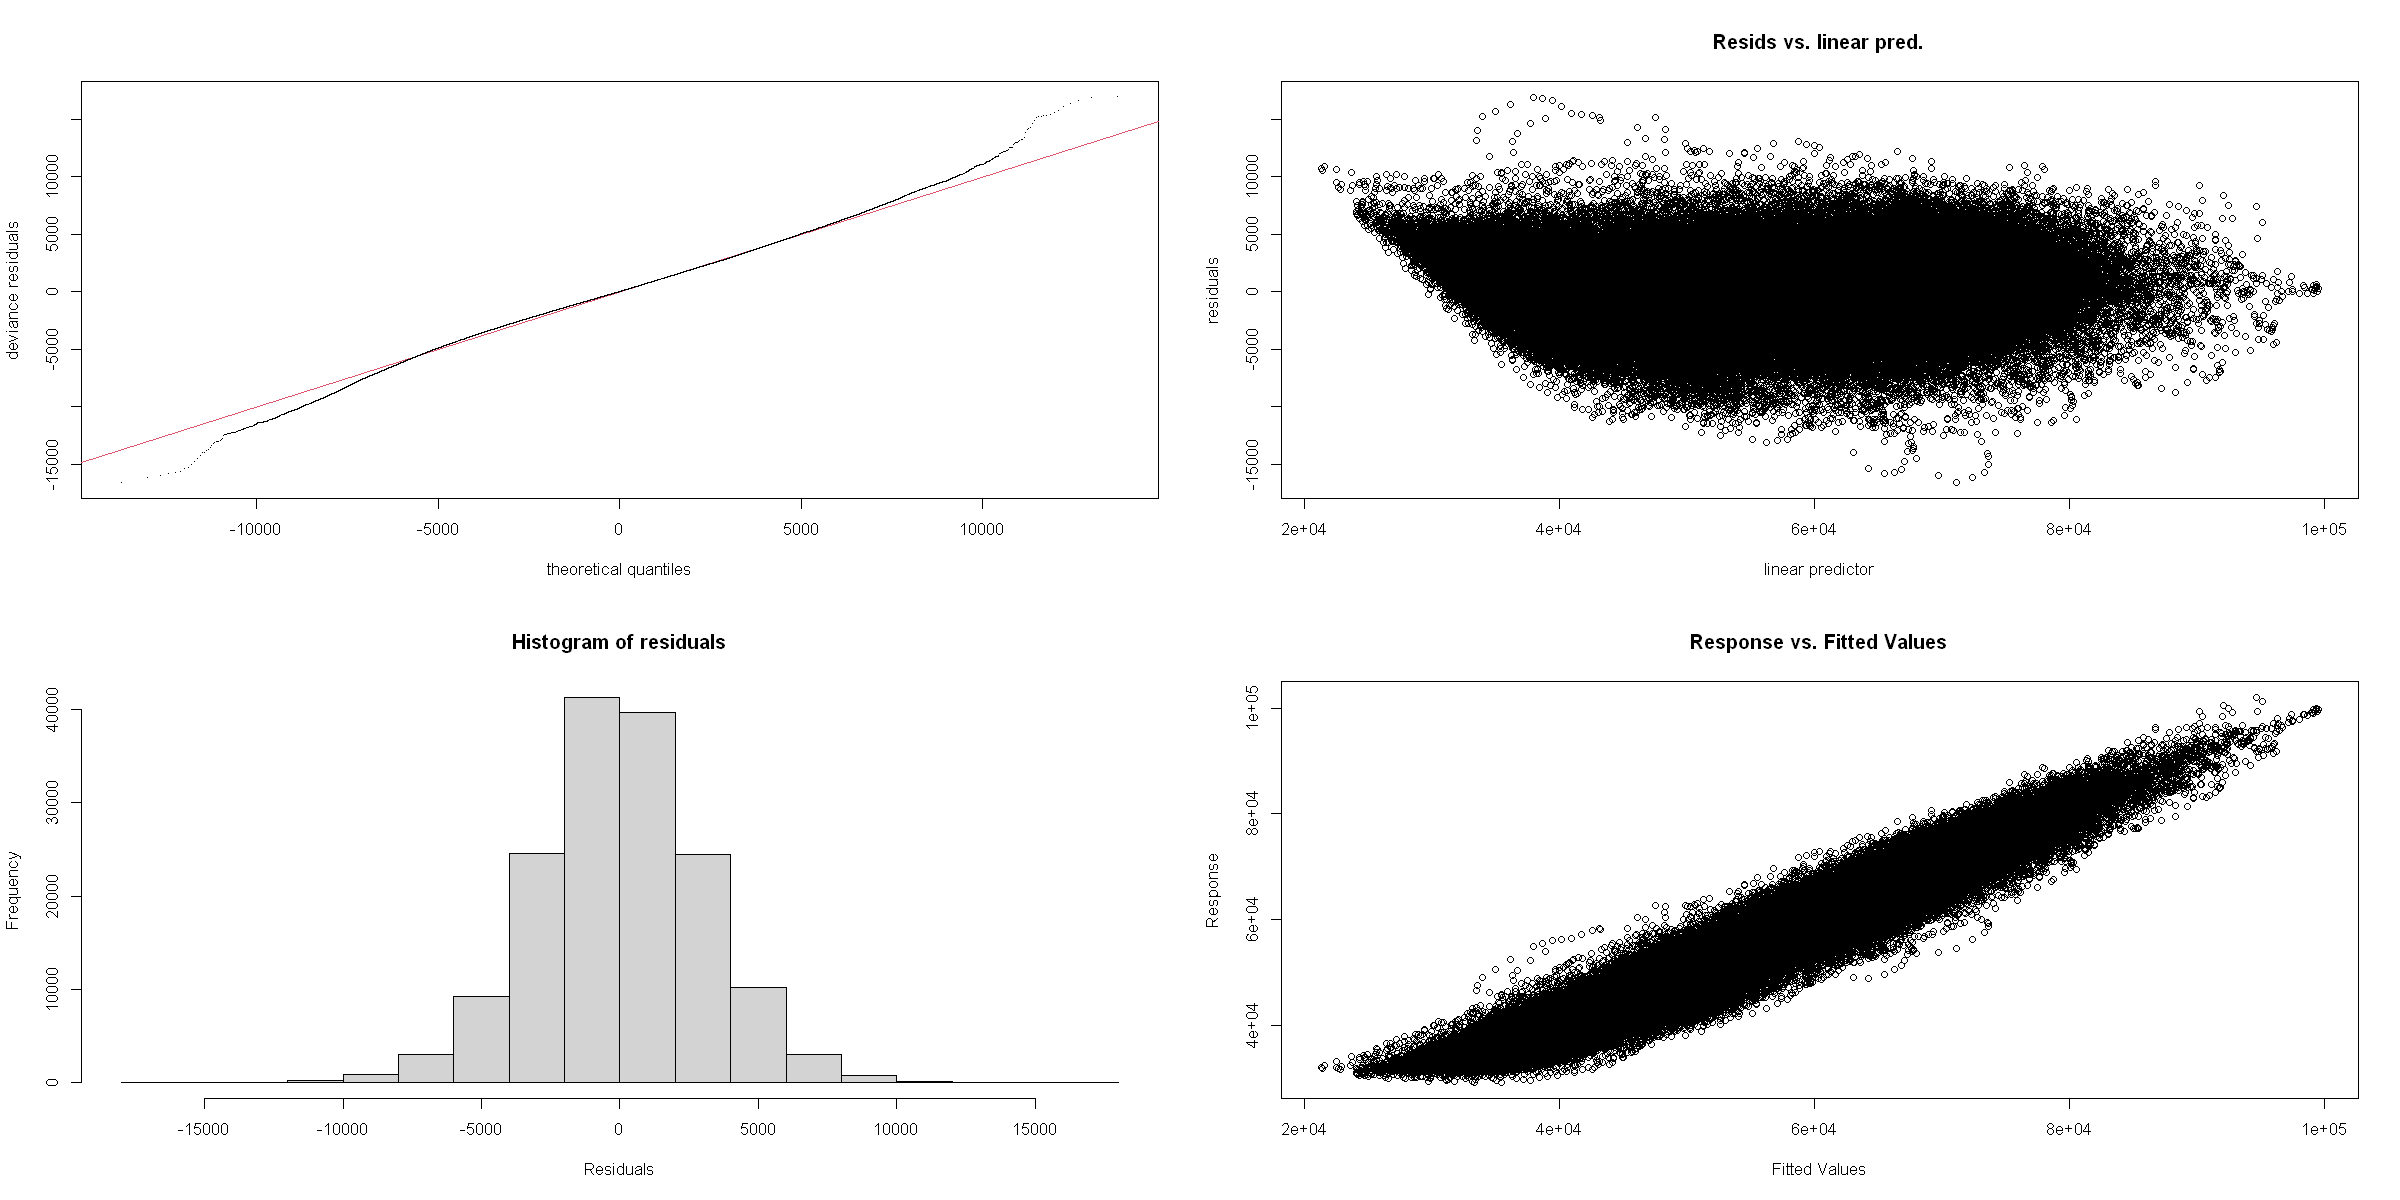

In [136]:
gam.check(mod_gam_2)
gam(residuals(mod_gam_2)~s(Temperature,k=40),gamma=1.4,data=data_train) ## ok
gam(residuals(mod_gam_2)~s(Temperature_lissee,k=40),gamma=1.4,data=data_train) ## ok
gam(residuals(mod_gam_2)~s(Humidity,k=40),gamma=1.4,data=data_train) ## ok
gam(residuals(mod_gam_2)~s(Nebulosity,k=40),gamma=1.4,data=data_train) ## ok
gam(residuals(mod_gam_2)~s(Position_year,k=200),gamma=1.4,data=data_train) ## ok ?

In [137]:
#Prediction
fits = predict(mod_gam_2, newdata=data_test, type='response', se=T)
predicts = data.frame(data_test, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
#Comparaison Prédiction - Benchmark
predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
comparison_mod_gam_2 = left_join(predicts,benchmark,c("Date","Time"))
#Calcul MAPE
mean(abs((comparison_mod_gam_2$Consumption-comparison_mod_gam_2$fit)/comparison_mod_gam_2$Consumption)) * 100

[1] 4.042799